In [2]:
import time
import warnings
import numpy as np
import pandas as pd
# import nasdaqdatalink
from nselib.capital_market import bhav_copy_with_delivery, index_data, price_volume_and_deliverable_position_data
from datetime import datetime, timedelta, date
from joblib import Parallel, delayed
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 300

### Functions

In [4]:
def reposition_column(dataframe, col_name, col_pos):
    col2repos = dataframe.pop(col_name)
    dataframe.insert(col_pos, col_name, col2repos.values)
    return dataframe

In [5]:
def intersection(lst1, lst2):
    lst3 = list(set(lst1) & set(lst2))
    return lst3

In [6]:
def get_bhavcopy(date):    
    try:
        return bhav_copy_with_delivery(date)
    except KeyError:
        col_names = ['SYMBOL', 'SERIES', 'OPEN_PRICE', 'HIGH_PRICE', 
                     'LOW_PRICE', 'CLOSE_PRICE', 'PREV_CLOSE', 'TTL_TRD_QNTY', 
                     'TURNOVER_LACS', 'NO_OF_TRADES', 'DELIV_QTY', 
                     'DELIV_PER', 'DATE1']
        return pd.DataFrame(columns = col_names)

In [7]:
def add_features(ticker_df):
    ticker_df['Delivery_60SMA'] = ticker_df['Delivery_Qty'].rolling(window = 60,
                                                                    min_periods = 1).mean().round(0)
    return ticker_df.sort_values('Date', ascending=False)

In [8]:
def high_delivery_l1m(data):
# High and consistent deliveries in last 1 month

    lookback_period = 30
    del_thresh1 = 3
    del_thresh2 = 7
    del_thresh3 = 10

    high_del_df = data.loc[data.index.unique()[0:lookback_period], :].sort_values('Delivery_Mult', ascending=False).copy()
    high_del_df1 = high_del_df[high_del_df['Delivery_Mult'] > del_thresh1]
    high_del_df2 = high_del_df[high_del_df['Delivery_Mult'] > del_thresh2]
    high_del_df3 = high_del_df[high_del_df['Delivery_Mult'] > del_thresh3]

    symbol_list1 = pd.DataFrame(high_del_df1['Symbol'].value_counts())
    symbol_list2 = pd.DataFrame(high_del_df2['Symbol'].value_counts())
    symbol_list3 = pd.DataFrame(high_del_df3['Symbol'].value_counts())
    symbol_list = pd.concat([symbol_list1, symbol_list2, symbol_list3], axis = 1)
    symbol_list.columns = ['Del_Mult_3', 'Del_Mult_7', 'Del_Mult_10']

    high_del_sym = symbol_list[(symbol_list['Del_Mult_3'] > 2) & 
                                   (symbol_list['Del_Mult_7'] > 1) &
                                   (~symbol_list['Del_Mult_10'].isnull())].sort_values('Del_Mult_10', ascending=False)
    
    high_del_sym = high_del_sym.reset_index()
    high_del_sym.columns = ['Symbol', high_del_sym.columns[1], high_del_sym.columns[2], high_del_sym.columns[3]]
    
    return high_del_sym

In [9]:
def peak_deliveries(data, lookback_period, nsymbols):
# Very high delivery multiple in the lookback period
    del_df = data.loc[data.index.unique()[0:lookback_period], :].sort_values('Delivery_Mult', ascending=False).copy()
    return del_df.head(nsymbols)

In [10]:
def high_delv_low_price_change(data, delv_threshold, price_change_upper, price_change_lower):
 # High Delivery multiple but low price change
    current_date_data = data.loc[data.index.unique()[0]].copy()
    output_df = (current_date_data[(current_date_data['Delivery_Mult'] > delv_threshold) &
                                   (current_date_data['Price_Change'] < price_change_upper) &
                                   (current_date_data['Price_Change'] > price_change_lower)]\
                 .sort_values('Delivery_Mult', ascending=False))
    return output_df

In [11]:
def high_delv_high_price_change(data, min_delv_mult, min_delv_pct, min_price_change, date = None):
 # High Delivery multiple but low price change
    
    if date == None:
        ref_date_data = data.loc[data.index.unique()[0]].copy()
    else:
        ref_date_data = data.loc[pd.to_datetime(date)].copy()
        
    output_df = (ref_date_data[(ref_date_data['Delivery_Mult'] > min_delv_mult) &
                                  (ref_date_data['Delivery%'] > min_delv_pct) &
                                  (ref_date_data['Price_Change'] > min_price_change)]\
                 .sort_values('Delivery_Mult', ascending=False))
    
    return output_df

In [12]:
def high_freq_accum(data, lookback_period, freq_threshold, count_threshold):
# High occurance of high delivery percentage
    
    high_accum_df = data.loc[data.index.unique()[0:lookback_period], :].copy()
    high_accum_df['High_Accum_Flag'] = np.where(high_accum_df['Delivery%'] > 0.5, 1, 0)
    high_accum_df['Delv_Mult_3x_Flag'] = np.where(high_accum_df['Delivery_Mult'] > 2.999, 1, 0)
    high_accum_stocks = (high_accum_df.pivot_table(index='Symbol', 
                                                  values='High_Accum_Flag',
                                                  aggfunc=np.mean)\
                         .merge(high_accum_df.pivot_table(index='Symbol', 
                                                  values='Delv_Mult_3x_Flag',
                                                  aggfunc=np.sum), 
                                on='Symbol', how='left'))
    high_accum_stocks.columns = ['High Delivery Occurance', 'Delivery Multiple Above 3x Count']
    high_accum_stocks = high_accum_stocks[(high_accum_stocks['High Delivery Occurance'] > freq_threshold) & 
                                          (high_accum_stocks['Delivery Multiple Above 3x Count'] > count_threshold)]
    abnormaly_high_del_idx = high_accum_stocks[high_accum_stocks['High Delivery Occurance'] > 0.98].index
    high_accum_stocks.drop(index = abnormaly_high_del_idx, inplace=True)
    
    high_accum_stocks = high_accum_stocks.reset_index()
    high_accum_stocks.columns = ['Symbol', high_accum_stocks.columns[1], high_accum_stocks.columns[2]]
    high_accum_stocks = high_accum_stocks.sort_values('Delivery Multiple Above 3x Count', ascending=False)
    
    return high_accum_stocks.reset_index(drop=True)

In [13]:
def run_scanner(data, lookback_period_far, lookback_period_near):
    
    high_del_l1m_df = high_delivery_l1m(data)
    high_del_l1m_df['High_Delv_L1M'] = 1
    
    peak_del_near_lookback_df = peak_deliveries(data, lookback_period_near, 20)
    peak_del_near_lookback_df['Peak_Delv_Near_Lookback'] = 1
    
    high_delv_low_price_chg_df = high_delv_low_price_change(data, 3, 0.05, -0.02)
    high_delv_low_price_chg_df['High_Delv_Low_Price_Chg'] = 1
    
    high_accum_far_lookback_df = high_freq_accum(data, lookback_period_far, 0.45, 10)
    high_accum_far_lookback_df['High_Accum_Far_Lookback'] = 1
    
    ticker_df = (high_del_l1m_df[['Symbol', 'High_Delv_L1M']]\
                 .merge(peak_del_near_lookback_df[['Symbol', 'Peak_Delv_Near_Lookback']], on='Symbol', how='outer')\
                 .merge(high_accum_far_lookback_df[['Symbol', 'High_Accum_Far_Lookback']], on='Symbol', how='outer')\
                 .merge(high_delv_low_price_chg_df[['Symbol', 'High_Delv_Low_Price_Chg']], on='Symbol', how='outer'))
    
    ticker_df['Hits'] = ticker_df.iloc[:,1:].sum(axis=1)
    ticker_df = ticker_df.sort_values('Hits', ascending=False)
    ticker_df = ticker_df.reset_index(drop=True)
    
    # Adding columns for Delivery Multiple and Delivery% for far lookback period
    lookback_df = data.loc[data.index.unique()[0:lookback_period_far], :].copy()
    lookback_df['High_Deliveries'] = np.where(lookback_df['Delivery%'] > 0.5, 1, 0)
    lookback_df['Delv_Mult_3x'] = np.where(lookback_df['Delivery_Mult'] > 2.9999, 1, 0)
    lookback_df['Delv_Mult_7x'] = np.where(lookback_df['Delivery_Mult'] > 6.9999, 1, 0)
    lookback_df['Delv_Mult_10x'] = np.where(lookback_df['Delivery_Mult'] > 9.9999, 1, 0)
    feature_df = (lookback_df.pivot_table(index='Symbol', 
                                          values='High_Deliveries',
                                          aggfunc=np.mean)\
                 .merge(lookback_df.pivot_table(index='Symbol', 
                                          values='Delv_Mult_3x',
                                          aggfunc=np.sum), 
                        on='Symbol', how='left')\
                 .merge(lookback_df.pivot_table(index='Symbol', 
                                          values='Delv_Mult_7x',
                                          aggfunc=np.sum), 
                        on='Symbol', how='left')\
                 .merge(lookback_df.pivot_table(index='Symbol', 
                                          values='Delv_Mult_10x',
                                          aggfunc=np.sum), 
                        on='Symbol', how='left'))
    
    feature_df = feature_df.reset_index()
    ticker_df = ticker_df.merge(feature_df, on='Symbol', how='left')
    ticker_df.drop_duplicates('Symbol', inplace=True)
    
    return ticker_df

In [14]:
pd.to_datetime('2022-7-11').isoweekday()

1

In [15]:
def adjust_for_split(dataframe, symbol, split_date, split_ratio):
    
    temp_df = dataframe.copy()
    
    split_date = pd.to_datetime(split_date)
    pre_split_date = split_date - np.timedelta64(1, 'D')
    day_num = pre_split_date.isoweekday()
    if day_num in list([6,7]):
        day_factor = day_num - 5
        pre_split_date = pre_split_date - np.timedelta64(day_factor, 'D')
#         pre_split_date = pd.to_datetime(pre_split_date) - np.timedelta64(day_factor, 'D')
#         pre_split_date = datetime.date(pre_split_date)
      
    ticker_df = temp_df[temp_df['Symbol'] == symbol].copy()
    try:
        ticker_df.index.get_loc(pre_split_date)
    except KeyError:
        pre_split_date = pre_split_date - np.timedelta64(1, 'D')
#         pre_split_date = pd.to_datetime(pre_split_date) - np.timedelta64(1, 'D')
#         pre_split_date = datetime.date(pre_split_date)
        ticker_df.index.get_loc(pre_split_date)
        
    ticker_df.loc[pre_split_date:, 
                 ['Open', 'High', 'Low', 'Close', 'Prev_Close']] = ticker_df.loc[pre_split_date:,
                                                                           ['Open', 'High', 'Low', 
                                                                            'Close', 'Prev_Close']]/split_ratio
    ticker_df.loc[split_date, 'Prev_Close'] = ticker_df.loc[split_date, 'Prev_Close']/split_ratio
    
    temp_df = temp_df[temp_df['Symbol'] != symbol]
    temp_df = pd.concat([temp_df, ticker_df], axis = 0)
    
    return temp_df

In [16]:
def plot_ticker(data_df, symbol, lookback_period, candle_width):
    
    warnings.filterwarnings("ignore")
    
    ticker_df = data_df[data_df['Symbol'] == symbol].iloc[0:lookback_period].copy()
    ticker_df.sort_index(ascending=True, inplace=True)

    fig, ax = plt.subplots(3, 1, figsize=(12, 9))
    ax[0].set_position([0, 0.4, 1, 0.6])
    ax[1].set_position([0, 0.2, 1, 0.2])
    ax[2].set_position([0, 0, 1, 0.2])
    
    #Plotting price candlesticks
    for date in ticker_df.index:

        ax[0].vlines(x = str(date), ymin = ticker_df.loc[date, 'Low'],
                     ymax = ticker_df.loc[date, 'High'], color = 'k', lw = 1)

        if ticker_df.loc[date, 'Close'] > ticker_df.loc[date, 'Open']:
            ymin_val = ticker_df.loc[date, 'Open']
            ymax_val = ticker_df.loc[date, 'Close']
            body_color = 'green'
        elif ticker_df.loc[date, 'Close'] < ticker_df.loc[date, 'Open']:
            ymin_val = ticker_df.loc[date, 'Close']
            ymax_val = ticker_df.loc[date, 'Open']
            body_color = 'red'
        else:
            ymin_val = ticker_df.loc[date, 'Open']
            ymax_val = ticker_df.loc[date, 'Close']
            body_color = 'black'

        ax[0].vlines(x = str(date), ymin = ymin_val,
                     ymax = ymax_val, color = body_color, lw = candle_width)
    
#     title_str = ax[0].set_title(symbol + ' (' + ticker_df['Group'].unique()[0].strip() + ')')
    title_str = ax[0].set_title(symbol)
    
#     ax[0].plot([str(x) for x in ticker_df.index],
#                ticker_df['Close_200SMA'],
#                lw=2, color='purple')
    
    ax[0].yaxis.tick_right()
    xmin = ax[0].get_xlim()[0]
    xmax = ax[0].get_xlim()[1]
    ax[0].set_xlim([xmin, xmax])
    ax[0].set_yticklabels(['{:,.0f}'.format(y) for y in ax[0].get_yticks()])   
    
    # Plotting delivery multiple bars
    high_del_mult_dates = ticker_df[ticker_df['Delivery_Mult'] > 2.99].index
    colors = ["steelblue" if d in high_del_mult_dates else "lightgrey" for d in ticker_df.index]
    ticker_df['Delivery_Mult'].plot(kind='bar', ax=ax[1], color = colors)
    ax[1].yaxis.tick_right()
    ax[1].grid(axis='y', alpha=0.33)
    ax[1].set_xlim([xmin, xmax])
    
    ax[1].text(x = ax[1].get_xlim()[0] + 0.5,
               y = ax[1].get_ylim()[1] - 1.3,
               s = 'Delivery Multiple',
               verticalalignment = 'bottom',
               fontfamily = 'sans-serif',
               fontsize = 12)
    
    
    # Plotting delivery% multiple bars 
    high_del_pct_dates1 = ticker_df[ticker_df['Delivery%'] > 0.599].index
    high_del_pct_dates2 = ticker_df[(ticker_df['Delivery%'] > 0.5) & 
                                    (ticker_df['Delivery%'] <= 0.599)].index
   # colors = ["steelblue" if d in high_del_pct_dates1 else "lightgrey" for d in ticker_df.index]
    colors = np.select([ticker_df.index.isin(high_del_pct_dates1),
                        ticker_df.index.isin(high_del_pct_dates2)],  
                       ["steelblue", "lightblue"], "lightgrey")
    ticker_df['Delivery%'].plot(kind='bar', ax=ax[2], color = colors)
    ax[2].yaxis.tick_right()
    ax[2].grid(axis='y', alpha=0.33)
    ax[2].set_xlim([xmin, xmax])
    ax[2].set_ylim([0, 1])
    
    ax[2].text(x = ax[2].get_xlim()[0] + 0.5,
               y = ax[2].get_ylim()[1] - .15,
               s = 'Delivery%',
               verticalalignment = 'bottom',
               fontfamily = 'sans-serif',
               fontsize = 12)
    
    label_list = ax[2].get_xticklabels()
    ax[2].set_xticklabels([pd.to_datetime(label_list[i].get_text()[:10]).strftime('%d-%m-%y') \
                           if (np.mod(i, 5) == 0) | (i == len(label_list) - 1) else '' \
                           for i in range(len(label_list)) ])
    
    warnings.resetwarnings()
    
    return ax

In [17]:
def chart(ticker_list, data, length = 180, width = 4):
    
    for ticker in ticker_list:
        try:
            ax = plot_ticker(data, ticker, length, candle_width = width)
            plt.gcf().set_figwidth(20)
            plt.show()
        except ValueError:
            continue
        except IndexError:
            continue
        
    return ax

### Dates

In [18]:
# global start_date_str, end_date_str

In [19]:
start_date = '2022-7-1'
start_date = pd.to_datetime(start_date).date()
date_today = date.today()
day_num = date_today.isoweekday()
if day_num in list([6,7]):
    end_date = date.today() - timedelta(days = day_num - 5)
elif (day_num == 1) & (datetime.today().hour < 19):
    end_date = date_today - timedelta(days = 3)
elif datetime.today().hour < 19:
    end_date = date_today - timedelta(days = 1)
else:
    end_date = date_today
    
start_date_str = start_date.strftime('%d-%m-%Y')
end_date_str = end_date.strftime('%d-%m-%Y')

In [20]:
[start_date_str, end_date_str]

['01-07-2022', '13-11-2023']

### Data Processing

In [21]:
nifty = index_data('NIFTY 50', period = '1Y')
dates = nifty['TIMESTAMP']

In [22]:
# bhavcopy_list = Parallel(n_jobs = -1, verbose = 5)(delayed(bhav_copy_with_delivery)(datestr) for datestr in dates)

In [23]:
t1 = time.time()
with ThreadPoolExecutor() as executor:
    try:
        bhavcopy_list = list(executor.map(get_bhavcopy, dates))
    except:
        try:
            bhavcopy_list = list(executor.map(get_bhavcopy, dates))
        except:
            bhavcopy_list = list(executor.map(get_bhavcopy, dates))
executor.shutdown()
print(f"Elapsed time: {time.time() - t1:0.2}s")

Elapsed time: 6.1e+01s


In [24]:
bhavcopy_df = pd.concat(bhavcopy_list, ignore_index = True)

In [25]:
bhavcopy_df['SERIES'].unique()

array(['EQ', 'GS', 'SM', 'BE', 'E1', 'X1', 'BZ', 'RR', 'N3', 'N6', 'N7',
       'N8', 'NW', 'NY', 'Y5', 'MF', 'NG', 'NI', 'NJ', 'NK', 'NO', 'NP',
       'NR', 'NS', 'N5', 'N4', 'W3', 'N2', 'N9', 'NE', nan, 'NC', 'Y1',
       'YM', 'YT', 'YZ', 'NH', 'NL', 'NF', 'IV', 'ST', 'N1', 'ND', 'NQ',
       'NU', 'Y7', 'Y9', 'NB', 'GB', 'NV', 'Y8', 'YI', 'YK', 'YL', 'YN',
       'YO', 'YV', 'Z3', 'Z8', 'Z9', 'ZD', 'ZG', 'NX', 'YG', 'YH', 'YR',
       'Z2', 'Z5', 'ZB', 'ZH', 'NN', 'IT', 'YA', 'YP', 'ZL', 'Y3', 'YS',
       'YY', 'Z7', 'ZK', 'NT', 'YX', 'YB', 'Z4', 'ZI', 'NM', 'ZE', 'Y6',
       'ZA', 'ZJ', 'YU', 'YW', 'NZ', 'YC', 'ZC', 'Y2', 'ZF', 'ZN', 'ZR',
       'N0', 'ZP', 'ZY', 'P1', 'SZ', 'ZW', 'ZU', 'ZS', 'ZZ', 'AC', 'W1',
       'AN', 'AA', 'BO', 'AG', 'ZX', 'AB', 'AI', 'Y0', 'AJ', 'AT', 'AR',
       'BC', 'AP', 'AZ', 'AV', 'AX', 'AH', 'AL', 'AY', 'AW', 'BG', 'BF',
       'BJ', 'BM', 'Y4', 'BV', 'BI'], dtype=object)

In [26]:
valid_series = ['EQ', 'BE', 'SM', 'BZ', 'ST']
bhavcopy_df = bhavcopy_df[bhavcopy_df['SERIES'].isin(valid_series)].replace('-', np.nan)
bhavcopy_df['Date'] = pd.to_datetime(bhavcopy_df['DATE1'], format = "%d-%b-%Y")
bhavcopy_df['DELIV_PER'] = bhavcopy_df['DELIV_PER'].astype(float) / 100 
bhavcopy_df = bhavcopy_df.sort_values(['SYMBOL', 'Date'])

# Excluding symbols whose date is not 2023-11-07
max_date_df = bhavcopy_df.groupby('SYMBOL', as_index=False)['Date'].max()
sym_exclude = max_date_df[max_date_df['Date'] != bhavcopy_df['Date'].max()]['SYMBOL']
bhavcopy_df = bhavcopy_df[~bhavcopy_df['SYMBOL'].isin(sym_exclude)]

bhavcopy_df.drop(columns = ['SERIES', 'DATE1'], inplace = True)
bhavcopy_df.drop_duplicates(['SYMBOL', 'Date'], inplace = True)
bhavcopy_df = reposition_column(bhavcopy_df, 'Date', 1)

# Renaming columns
bhavcopy_df.columns = ['Symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Prev_Close', 
                       'Volume', 'Turnover', 'Total_Trades', 'Delivery_Qty', 
                       'Delivery%']

In [27]:
# bhavcopy_df[bhavcopy_df['Symbol'] == 'MAANALU']

In [28]:
# gna_df = bhavcopy_df[bhavcopy_df['Symbol'] == 'GNA']

In [29]:
# adjust_for_split(dataframe = gna_df.set_index('Date').sort_index(ascending = False), 
#                  symbol = 'GNA', 
#                  split_date = '2023-09-01', 
#                  split_ratio = 2)

In [30]:
# Removing Gsec / fund / ETF symbols
sym_list = bhavcopy_df['Symbol'].unique()

gsec_syms = ['GSEC10YEAR', 'ICICI5GSEC', 'MOGSEC']

fund_syms = ['ICICICONSU',
             'MOQUALITY',
             'ABSLNN50ET',
             'HDFCLOWVOL',
             'HDFCMID150',
             'MOLOWVOL',
             'HDFCMOMENT',
             'MOM50',
             'MOMOMENTUM',
             'ICICI5GSEC',
             'HDFCNEXT50',
             'NPBET',
             'ICICIBANKP']

etf_syms = [i for i in sym_list if 'ETF' in i]

nifty_syms = [i for i in sym_list if 'NIFTY' in i]

uti_syms = [i for i in sym_list if 'UTI' in i]
sym2rem = ['BFUTILITIE', 'MARUTI', 'UTIAMC']
uti_syms = [i for i in uti_syms if i not in sym2rem]

icici_syms = [i for i in sym_list if 'ICICI' in i]
sym2rem = ['ICICIBANK', 'ICICIPRULI', 'ICICITECH']
icici_syms = [i for i in icici_syms if i not in sym2rem]

hdfc_syms = [i for i in sym_list if 'HDFC' in i]
sym2rem = ['HDFCAMC', 'HDFCBANK', 'HDFCLIFE']
hdfc_syms = [i for i in hdfc_syms if i not in sym2rem]

kotak_syms = [i for i in sym_list if 'KOTAK' in i]
sym2rem = ['KOTAKBANK']
kotak_syms = [i for i in kotak_syms if i not in sym2rem]

axis_syms = [i for i in sym_list if 'AXIS' in i]
sym2rem = ['AXISCADES', 'AXISBANK', 'PRAXIS']
axis_syms = [i for i in axis_syms if i not in sym2rem]

sbi_syms = ['LIQUIDSBI']

sym2rem = (gsec_syms + fund_syms + etf_syms + nifty_syms + icici_syms \
           + hdfc_syms + kotak_syms + sbi_syms + uti_syms)
bhavcopy_df = bhavcopy_df[~bhavcopy_df['Symbol'].isin(sym2rem)]

In [31]:
t1 = time.time()
symbol_list = bhavcopy_df['Symbol'].unique().tolist()
ticker_df_list = [bhavcopy_df[bhavcopy_df['Symbol'] == symbol].copy() for symbol in symbol_list]
with ThreadPoolExecutor() as executor:
    df_list = list(executor.map(add_features, ticker_df_list))
executor.shutdown()
bhavcopy_df = pd.concat(df_list, ignore_index = True)
print(f"Elapsed time: {time.time() - t1:0.2}s")

Elapsed time: 1.8e+02s


In [32]:
bhavcopy_df['Delivery_Mult'] = (bhavcopy_df['Delivery_Qty'].astype(float) / bhavcopy_df['Delivery_60SMA']).round(2)
bhavcopy_df.set_index('Date', inplace = True)

In [33]:
data_backup = bhavcopy_df.copy()
data = bhavcopy_df.copy()

### Adjusting Prices for Splits

In [34]:
data.index.min()

Timestamp('2022-11-14 00:00:00')

In [35]:
# data = adjust_for_split(data, 'AXITA', '2022-10-21', 10)
# data = adjust_for_split(data, 'SAKSOFT', '2022-9-23', 10)
# data = adjust_for_split(data, 'SONATSOFTW', '2022-9-8', 4/3)
# data = adjust_for_split(data, 'MGEL', '2022-8-18', 5)
data = adjust_for_split(data, 'PRECWIRE', '2022-12-22', 1.5)
# data = adjust_for_split(data, 'ECLERX', '2022-9-21', 1.5)
# data = adjust_for_split(data, 'BANSWRAS', '2022-9-8', 2)
# data = adjust_for_split(data, 'HNDFDS', '2022-7-21', 5)
data = adjust_for_split(data, 'KPIGREEN', '2023-1-18', 2)
# data = adjust_for_split(data, 'NYKAA', '2022-11-10', 6)
# data = adjust_for_split(data, 'BEL', '2022-9-15', 3)
# data = adjust_for_split(data, 'STEELXIND', '2022-7-12', 10)
# data = adjust_for_split(data, 'TPLPLAST', '2022-10-19', 5)
# data = adjust_for_split(data, 'DEVIT', '2022-11-25', 2)
# data = adjust_for_split(data, 'SOTL', '2022-9-1', 5)
# data = adjust_for_split(data, 'SECURCRED', '2023-1-4', 4)
data = adjust_for_split(data, 'HITECH', '2023-3-17', 10)
# data = adjust_for_split(data, 'HARDWYN', '2022-7-25', 1.5)
data = adjust_for_split(data, 'BLS', '2022-12-8', 2)
data = adjust_for_split(data, 'RAMASTEEL', '2023-1-6', 5)
data = adjust_for_split(data, 'TIPSINDLTD', '2023-4-21', 10)
data = adjust_for_split(data, 'VISHNU', '2023-1-13', 5)
data = adjust_for_split(data, 'VSSL', '2023-5-26', 2)
data = adjust_for_split(data, 'GNA', '2023-09-01', 2)
data = adjust_for_split(data, 'GREENPOWER', '2023-08-18', 543/500)
data = adjust_for_split(data, 'APTECHT', '2023-07-14', 7/5)
data = adjust_for_split(data, 'TALBROAUTO', '2023-10-27', 5)
data = adjust_for_split(data, 'SARDAEN', '2023-08-04', 10)
data = adjust_for_split(data, 'MAANALU', '2023-07-27', 4)
data = adjust_for_split(data, 'THEMISMED', '2023-10-10', 10)
data = adjust_for_split(data, 'FOCUS', '2023-10-6', 5)
data = adjust_for_split(data, 'SIGACHI', '2023-10-9', 10)
data = adjust_for_split(data, 'BEPL', '2023-07-5', 1.5)
data = adjust_for_split(data, 'MKPL', '2023-11-10', 10)
data = adjust_for_split(data, 'OSWALSEEDS', '2023-08-18', 5)

In [36]:
count_df = data.groupby('Symbol')[['Close']].count()
sym2drop = count_df[count_df['Close'] < 72].index.tolist()
data = data[~data['Symbol'].isin(sym2drop)]

In [37]:
data['Symbol'].nunique()

2048

In [38]:
data['Price_Change'] = (data['Close'] / data['Prev_Close']) - 1

### Scanners

In [39]:
securities = run_scanner(data, lookback_period_far=66, lookback_period_near=10)
securities = securities.sort_values('Delv_Mult_10x', ascending = False)
# securities = securities.merge(tickers.drop_duplicates('Symbol')[['Symbol', 'Group']], 
#                               on='Symbol', 
#                               how='left')
# securities = reposition_column(securities, 'Group', 1)
securities

,Symbol,High_Delv_L1M,Peak_Delv_Near_Lookback,High_Accum_Far_Lookback,High_Delv_Low_Price_Chg,Hits,High_Deliveries,Delv_Mult_3x,Delv_Mult_7x,Delv_Mult_10x
78,JSWHL,NaN,NaN,1.0,NaN,1.0,0.757576,20,6,4
15,HBSL,1.0,1.0,NaN,NaN,2.0,0.424242,6,3,3
33,UNIINFO,1.0,NaN,NaN,NaN,1.0,0.348485,8,3,3
76,NITCO,NaN,NaN,1.0,NaN,1.0,0.757576,14,5,3
1,DPSCLTD,1.0,1.0,NaN,1.0,3.0,0.560606,10,4,3
69,AUSOMENT,1.0,NaN,NaN,NaN,1.0,0.287879,6,3,3
10,BYKE,1.0,NaN,1.0,NaN,2.0,0.727273,12,4,3
12,ISHAN,1.0,1.0,NaN,NaN,2.0,0.937500,10,4,3
0,SEAMECLTD,1.0,1.0,NaN,1.0,3.0,0.545455,6,2,2
70,SHALPAINTS,1.0,NaN,NaN,NaN,1.0,0.803030,6,3,2


In [40]:
securities.shape[0]

89

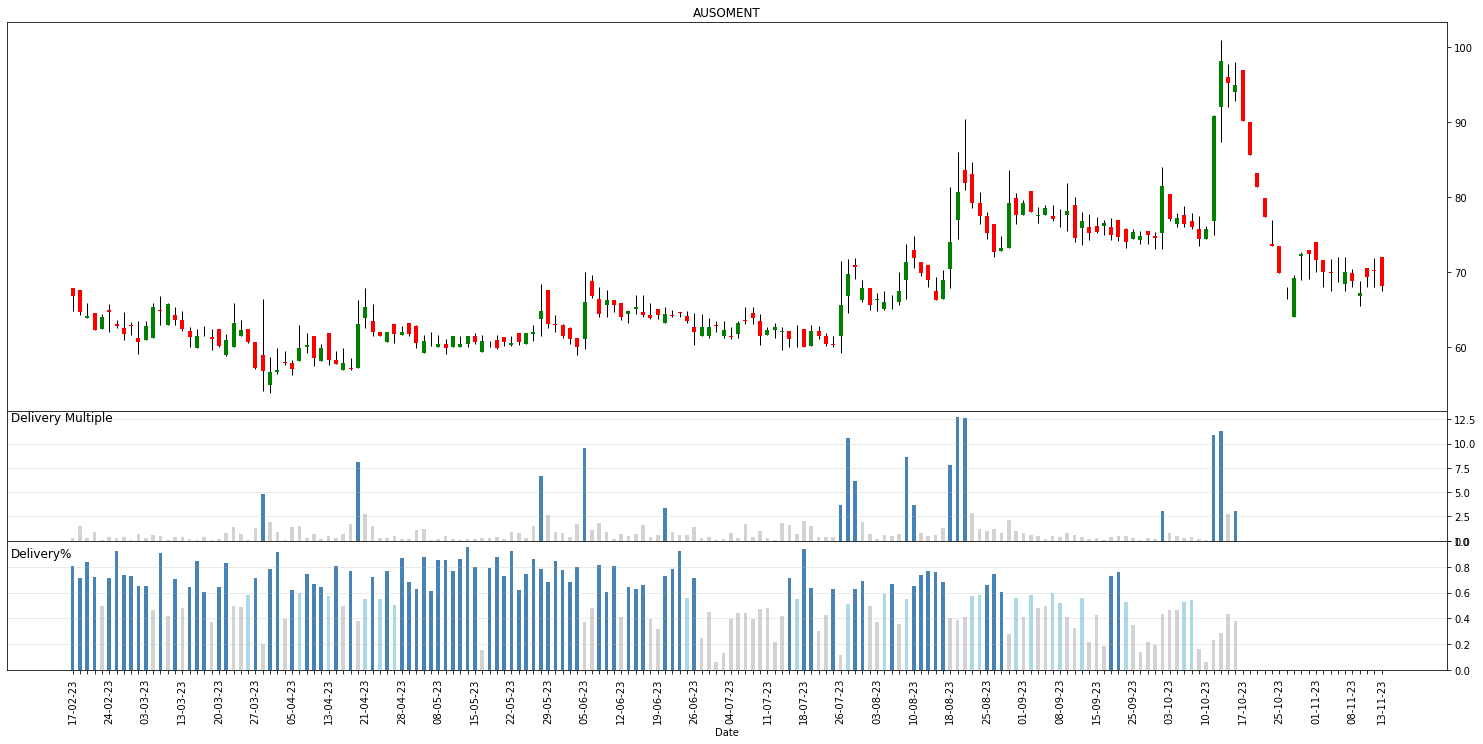

In [41]:
ax = plot_ticker(data, 'AUSOMENT', 180, candle_width = 4)
plt.gcf().set_figwidth(20)

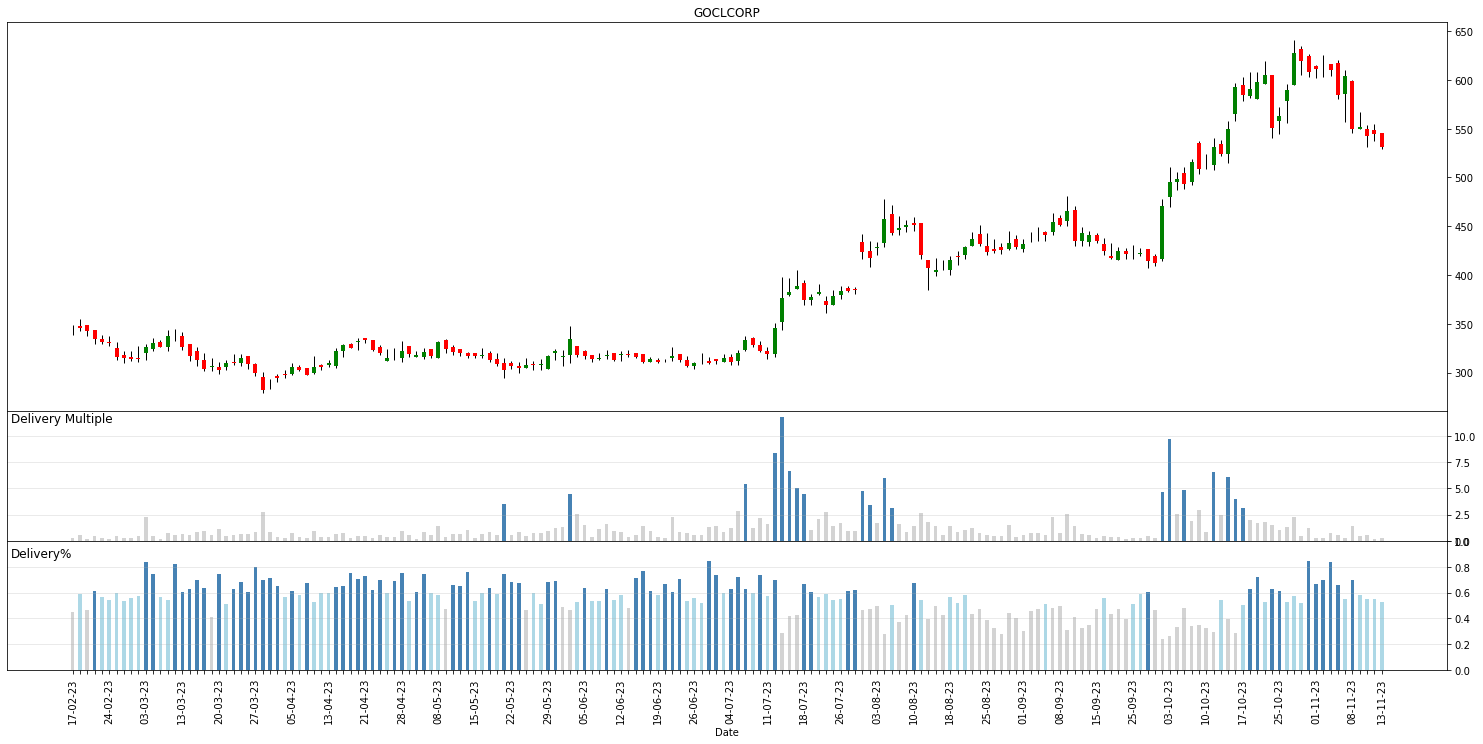

In [42]:
ax = plot_ticker(data, 'GOCLCORP', 180, candle_width = 4)
plt.gcf().set_figwidth(20)

In [43]:
# High delivery multiple but low price change
output_df = high_delv_low_price_change(data, 3, 0.05, -0.02)
# output_df = output_df.merge(tickers.drop_duplicates('Symbol')[['Symbol', 'Group']], 
#                             on='Symbol', 
#                             how='left')
# output_df = reposition_column(output_df, 'Group', 1)
output_df[['Symbol', 'Delivery_Qty', 'Delivery%', 
           'Delivery_Mult', 'Price_Change']].sort_values('Delivery_Mult', 
                                                         ascending = False)

,Symbol,Delivery_Qty,Delivery%,Delivery_Mult,Price_Change
Date,,,,,
2023-11-13,ROML,37505,0.6860,5.67,0.043433
2023-11-13,HARIOMPIPE,249613,0.3170,5.32,0.005930
2023-11-13,SEAMECLTD,223274,0.5500,5.29,0.031233
2023-11-13,LUMAXIND,33452,0.7023,5.28,0.027444
2023-11-13,ISMTLTD,1337579,0.3461,4.94,0.048193
2023-11-13,ROTO,277147,0.5246,4.87,-0.000368
2023-11-13,AUROIMPEX,147200,0.8288,4.79,-0.002094
2023-11-13,DPSCLTD,2216988,0.3773,4.79,-0.009434
2023-11-13,BCLIND,779842,0.4073,4.59,0.004850


In [44]:
high_del_high_pchange_df = high_delv_high_price_change(data, 
                                                       min_delv_mult = 3, 
                                                       min_delv_pct = 0.6, 
                                                       min_price_change = 0.03)
# high_del_high_pchange_df

In [45]:
high_del_high_pchange_df['Symbol']

Date
2023-11-13          ROML
2023-11-13         THEJO
2023-11-13      LOTUSEYE
2023-11-13     JAYAGROGN
2023-11-13       BURNPUR
2023-11-13      CUBEXTUB
2023-11-13           JHS
2023-11-13      MADHUCON
2023-11-13         DUCON
2023-11-13    SINDHUTRAD
2023-11-13      KARMAENG
Name: Symbol, dtype: object

In [46]:
# Very high delivery multiple in last 10 days
monster_del_df = peak_deliveries(data[np.logical_not(data['Symbol'].str.contains('ETF'))], 10, 20)
monster_del_df[['Symbol', 'Delivery_Qty', 'Delivery_Mult']].sort_values('Delivery_Mult', 
                                                                        ascending = False)

,Symbol,Delivery_Qty,Delivery_Mult
Date,,,
2023-11-02,BLISSGVS,2940577,18.10
2023-11-03,ATFL,103172,16.32
2023-11-10,TRACXN,6608333,16.00
2023-11-08,HBSL,301405,15.13
2023-11-08,INFOLLION,526400,14.48
2023-11-13,DUGLOBAL,482500,14.46
2023-11-07,SEAMECLTD,457815,14.43
2023-11-09,HBSL,356243,14.27
2023-11-13,VINEETLAB,412055,14.24


In [47]:
high_accum_stocks = high_freq_accum(data, 66, 0.45, 10)
high_accum_stocks

,Symbol,High Delivery Occurance,Delivery Multiple Above 3x Count
0,JSWHL,0.757576,20
1,THEMISMED,0.833333,17
2,FOCUS,0.893939,15
3,SIGACHI,0.500000,15
4,MKPL,0.590909,14
5,NITCO,0.757576,14
6,BLISSGVS,0.636364,12
7,BYKE,0.727273,12
8,TARMAT,0.484848,12
9,WEALTH,0.666667,12


In [48]:
# High frequency of accumulation in last 3 month
lookback_period = 66
del_thresh1 = 3
del_thresh2 = 5

high_accum_df = data.loc[data.index.unique()[0:lookback_period], :].sort_values('Delivery_Mult', ascending=False)
high_accum_df1 = high_accum_df[high_accum_df['Delivery_Mult'] > del_thresh1]
high_accum_df2 = high_accum_df[high_accum_df['Delivery_Mult'] > del_thresh2]

symbol_list1 = pd.DataFrame(high_accum_df1['Symbol'].value_counts())
symbol_list2 = pd.DataFrame(high_accum_df2['Symbol'].value_counts())
symbol_list = pd.concat([symbol_list1, symbol_list2], axis = 1)
symbol_list.columns = ['Del_Mult_3', 'Del_Mult_5']

high_del_sym = symbol_list[(symbol_list['Del_Mult_3'] > 10) & 
                               (symbol_list['Del_Mult_5'] > 3)].sort_values('Del_Mult_3', ascending=False)
high_del_sym

,Del_Mult_3,Del_Mult_5
JSWHL,20,10.0
THEMISMED,17,8.0
SIGACHI,15,5.0
FOCUS,15,7.0
MKPL,14,5.0
NITCO,14,8.0
JINDALPHOT,13,4.0
TARMAT,12,5.0
BYKE,12,4.0
SONAMCLOCK,12,7.0


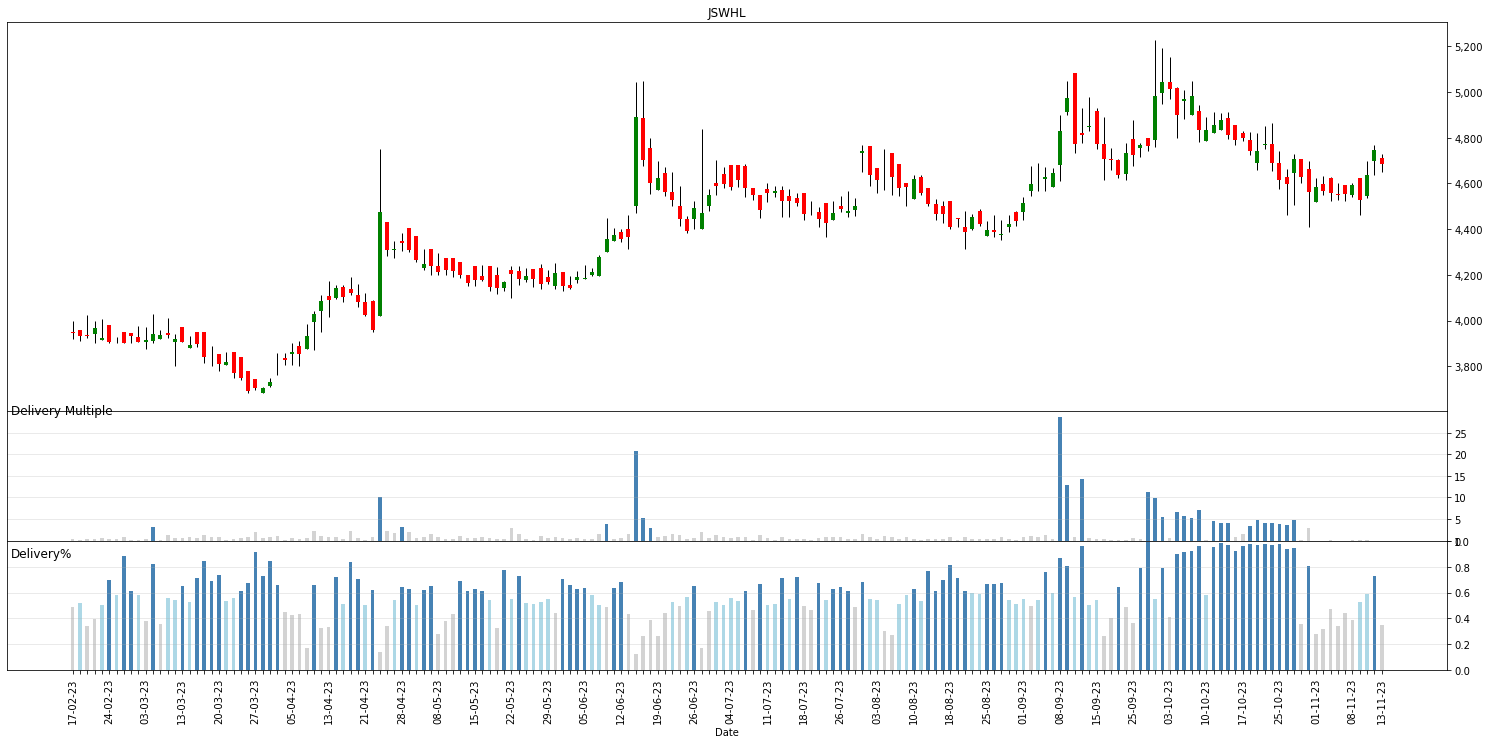

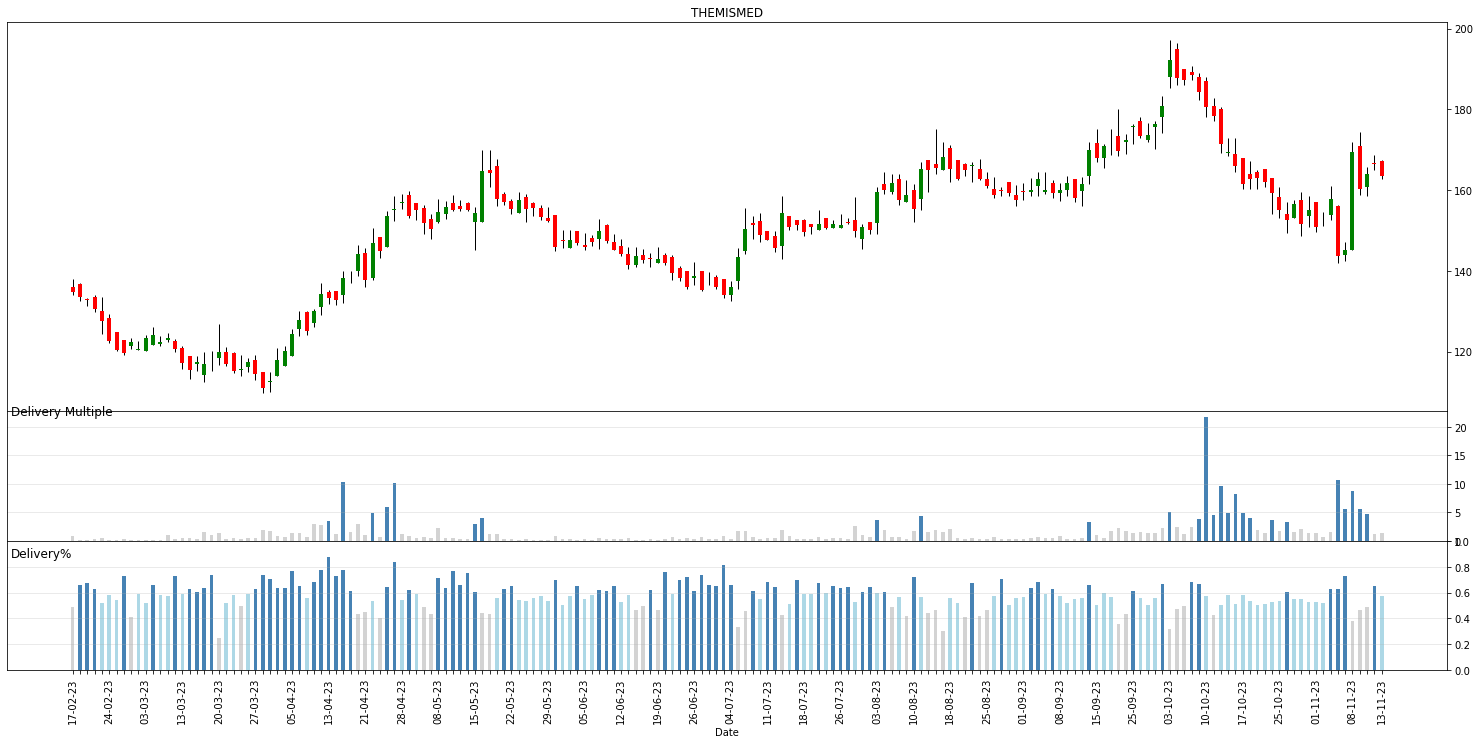

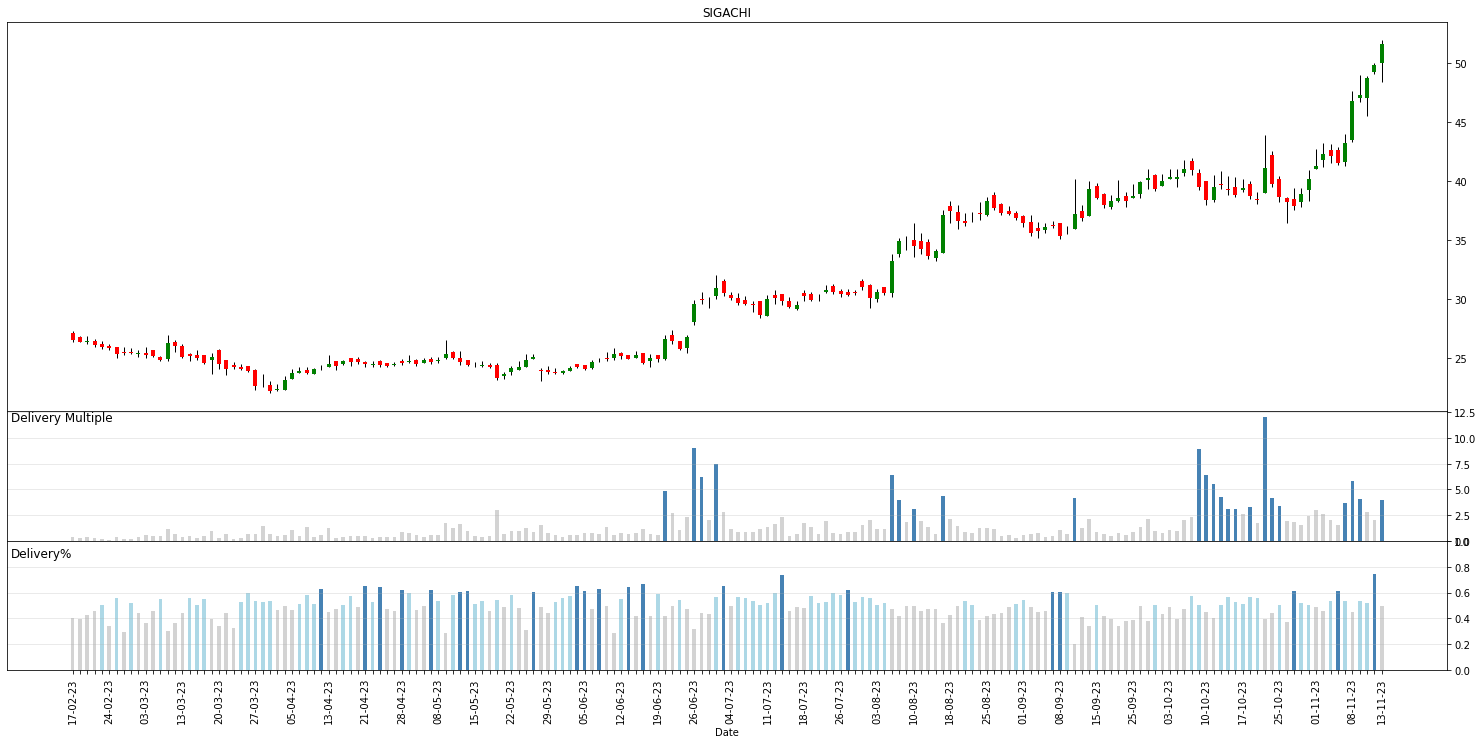

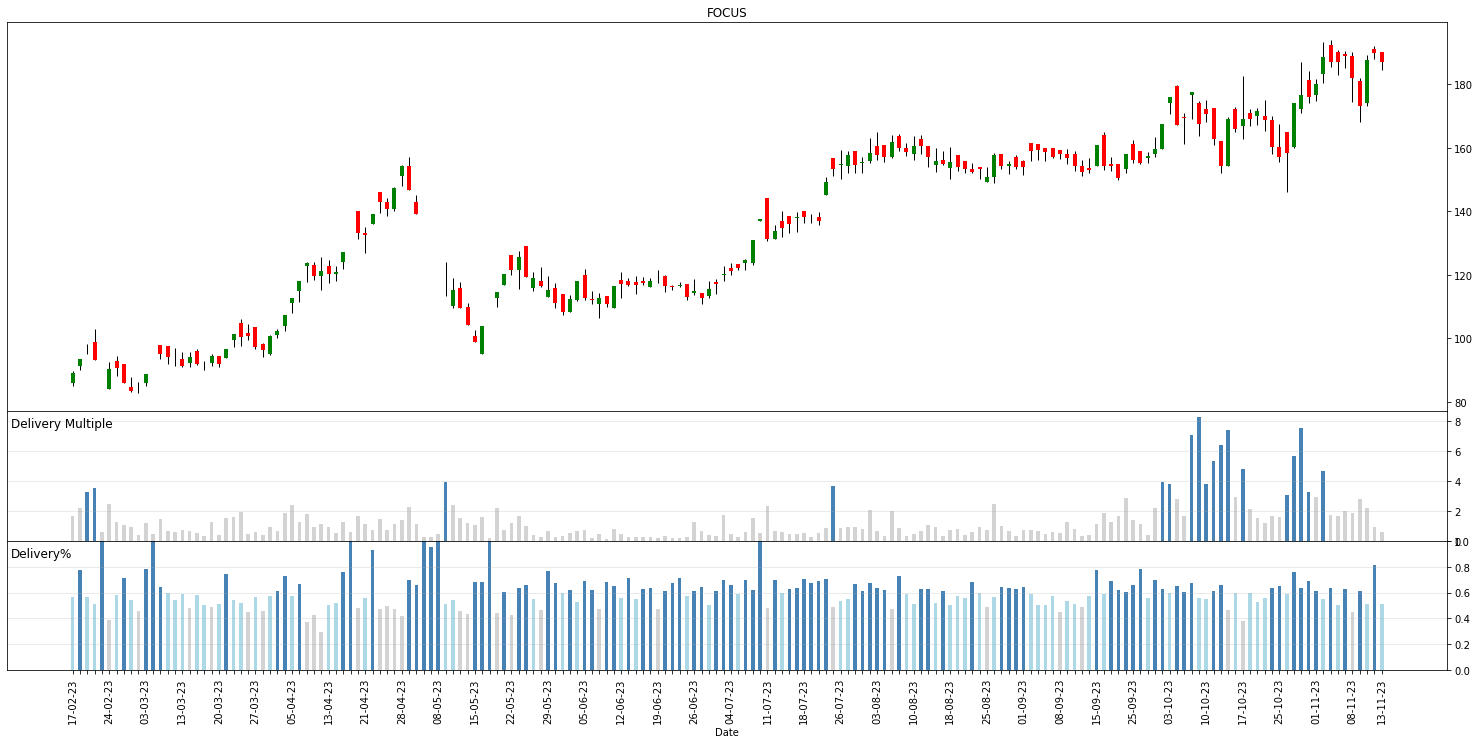

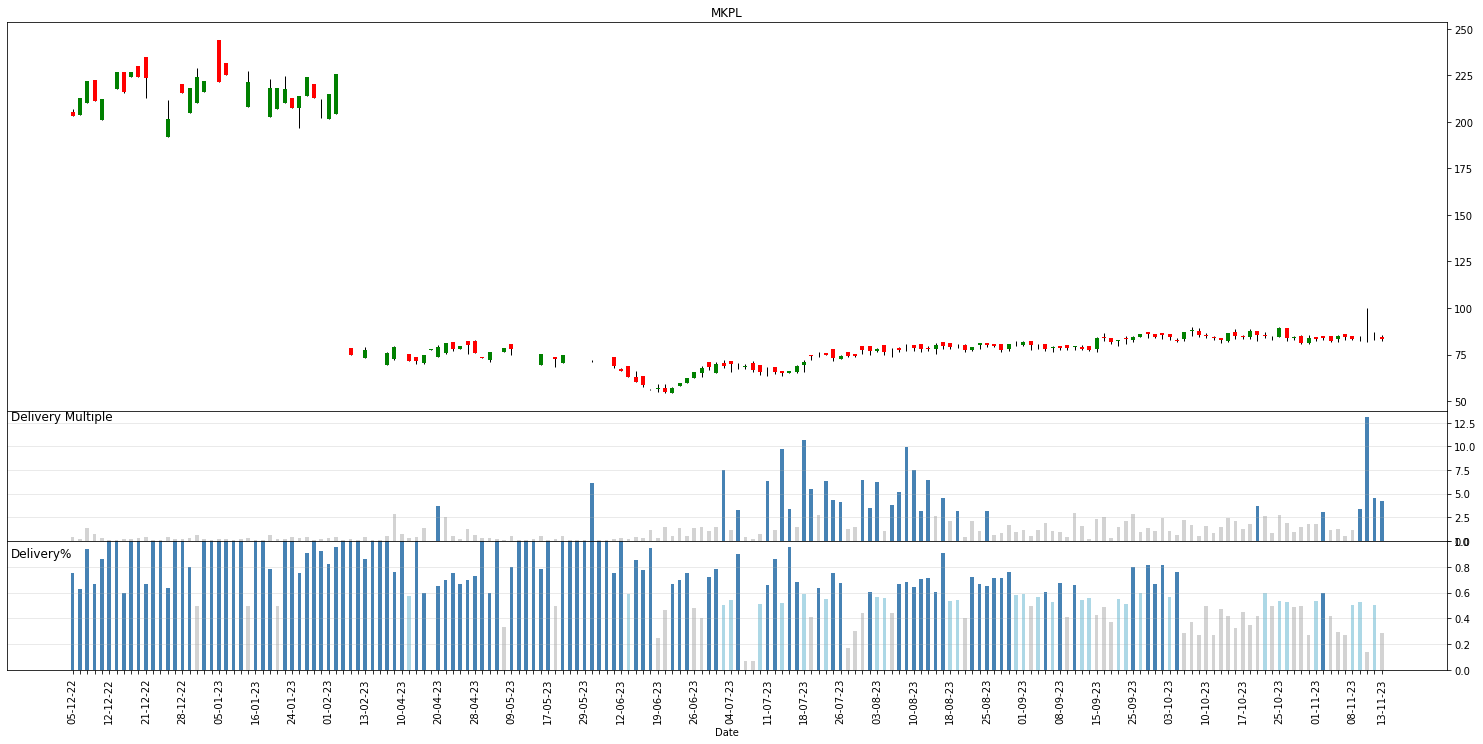

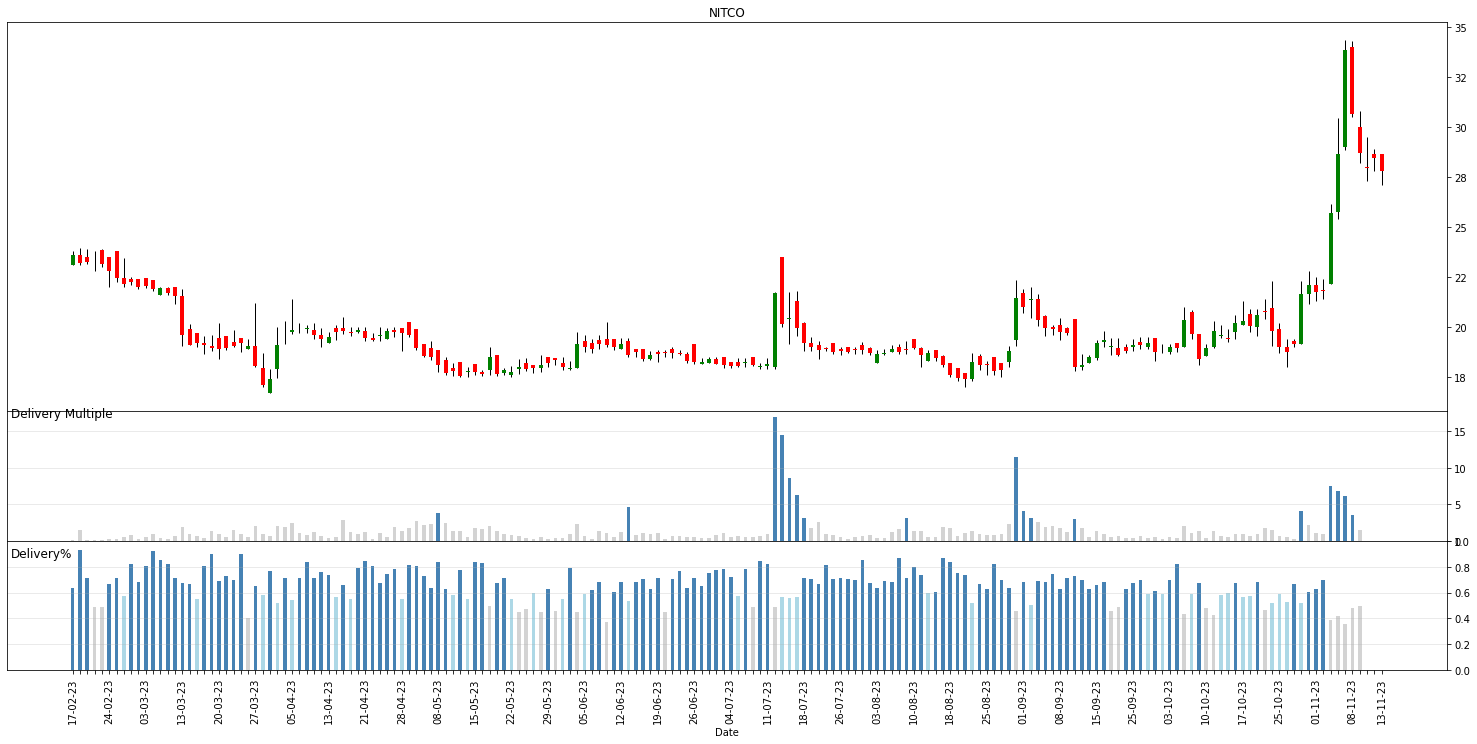

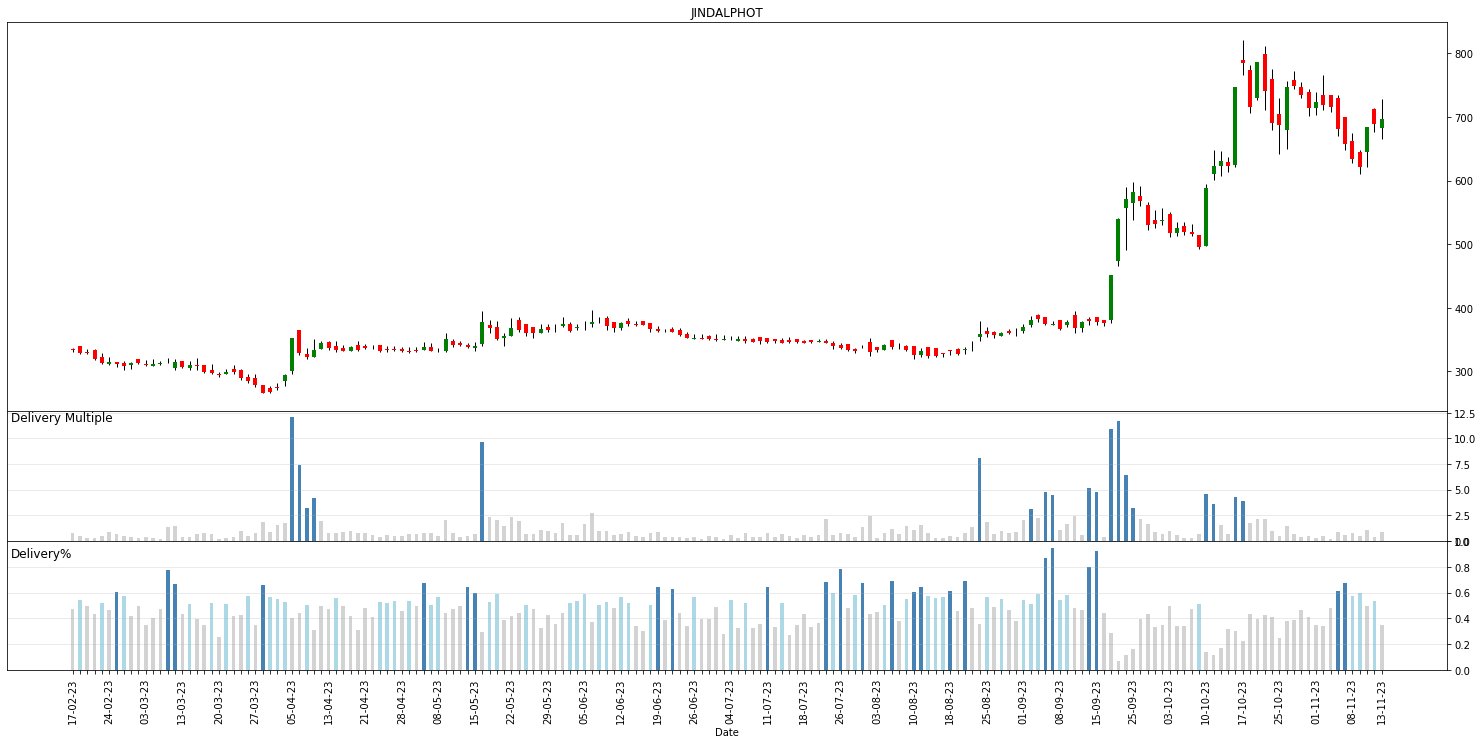

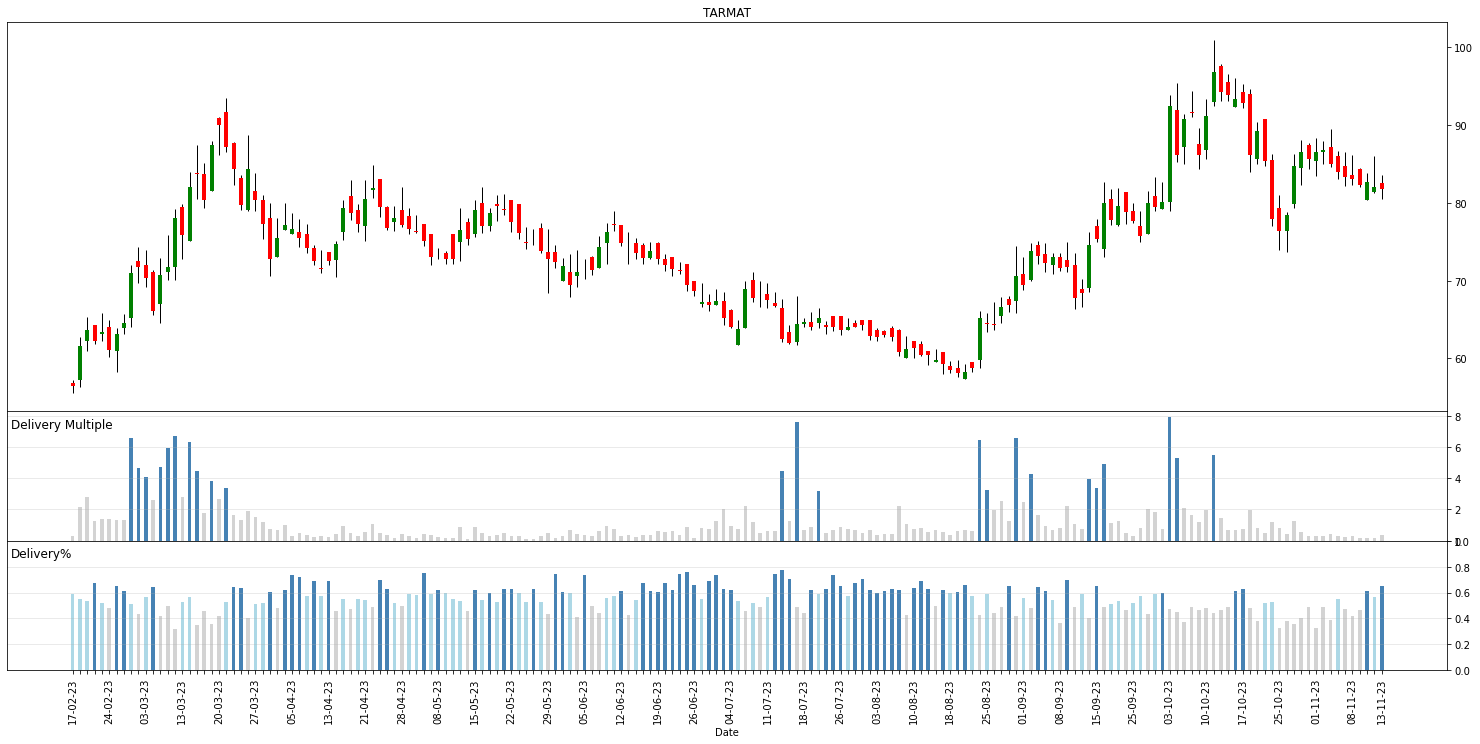

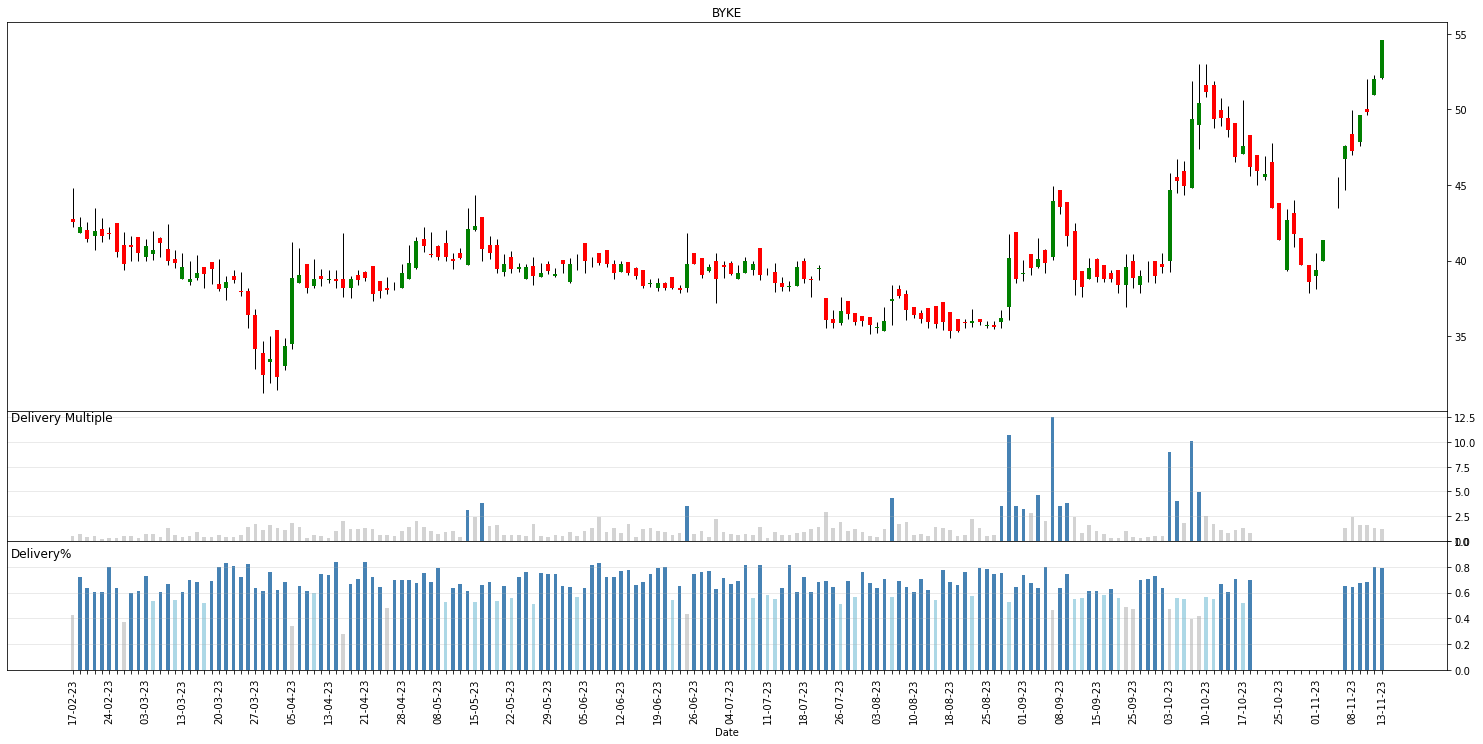

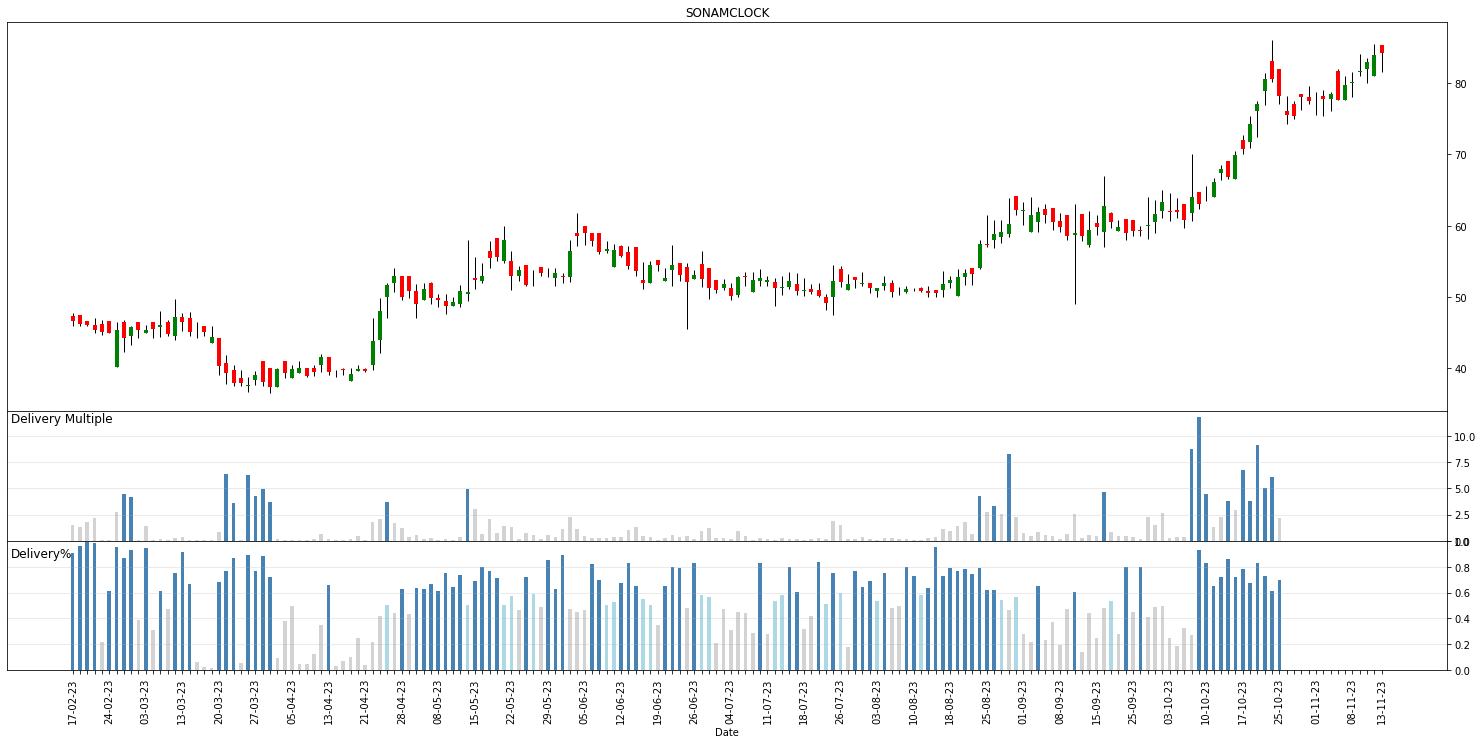

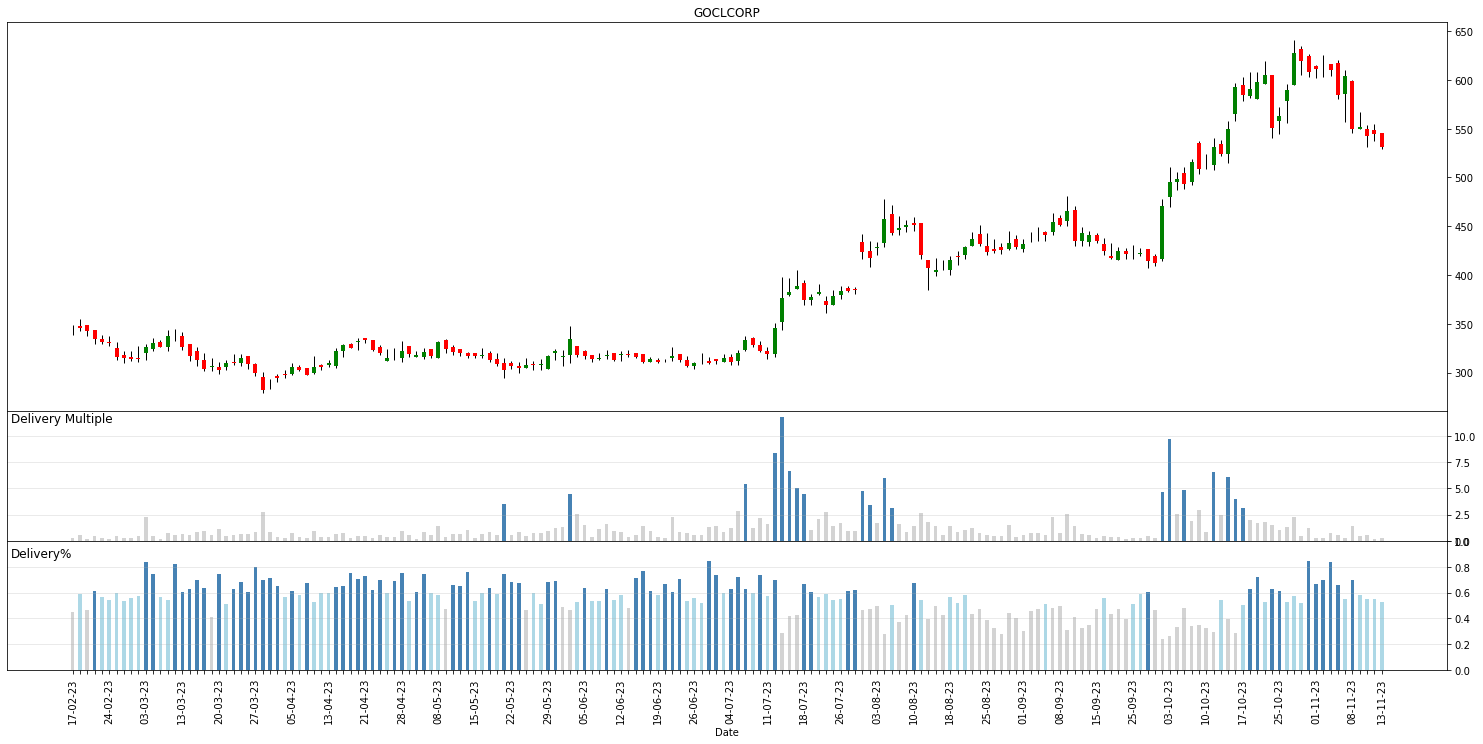

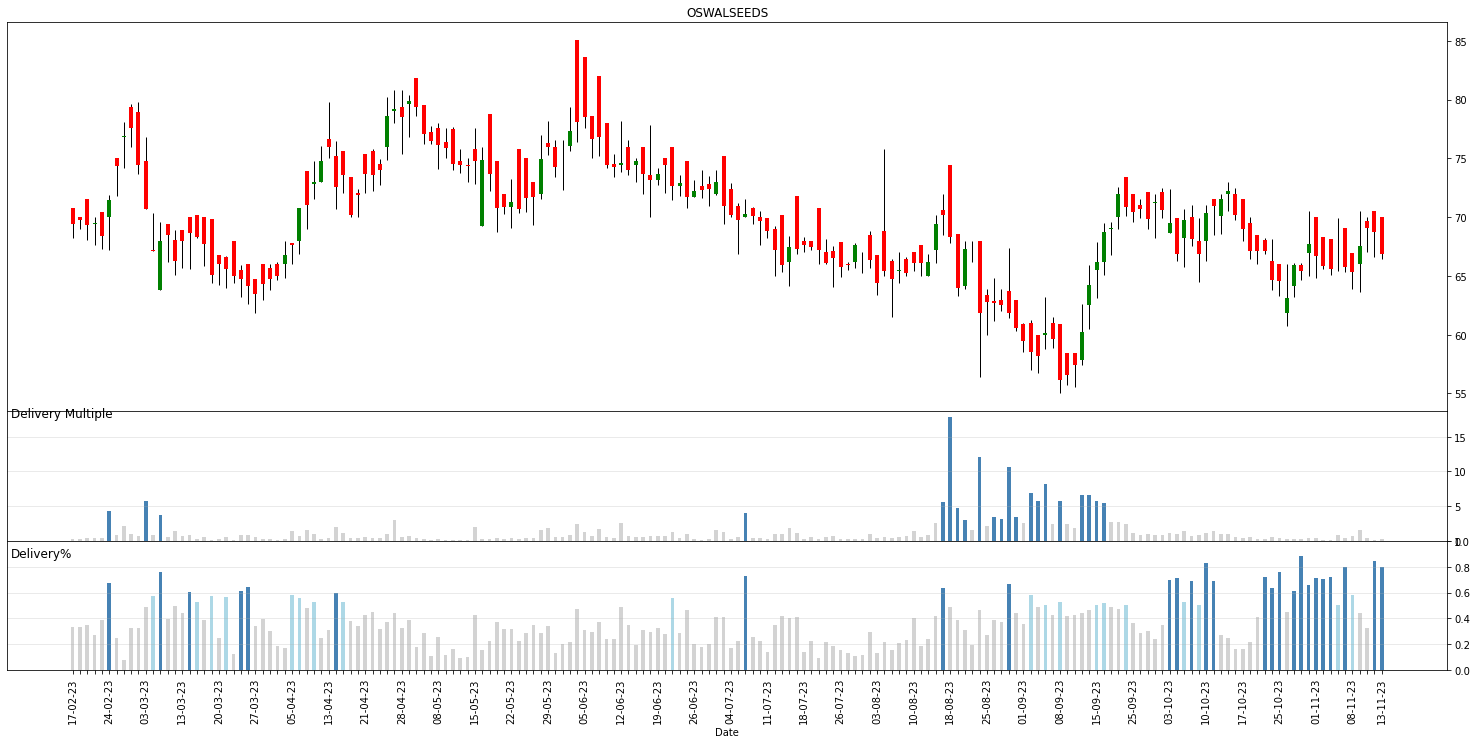

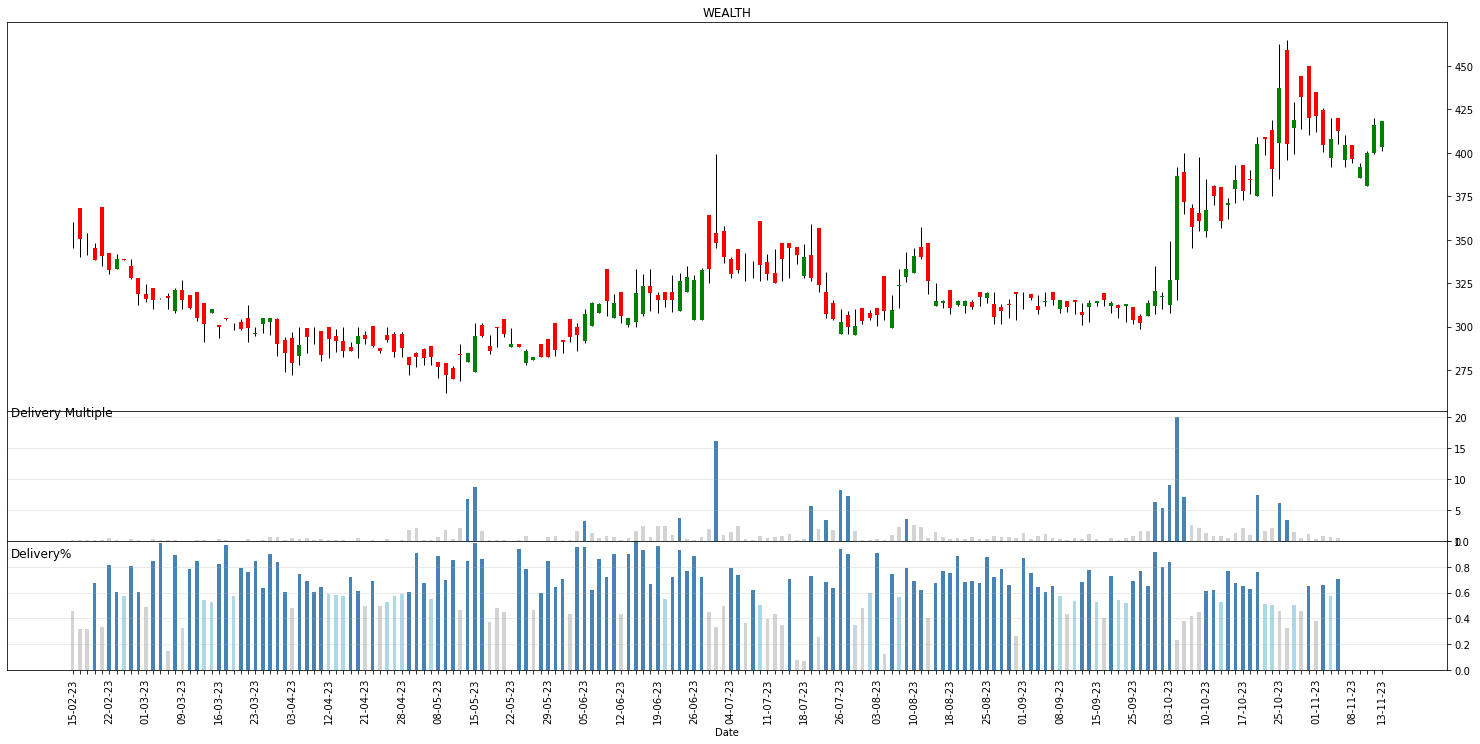

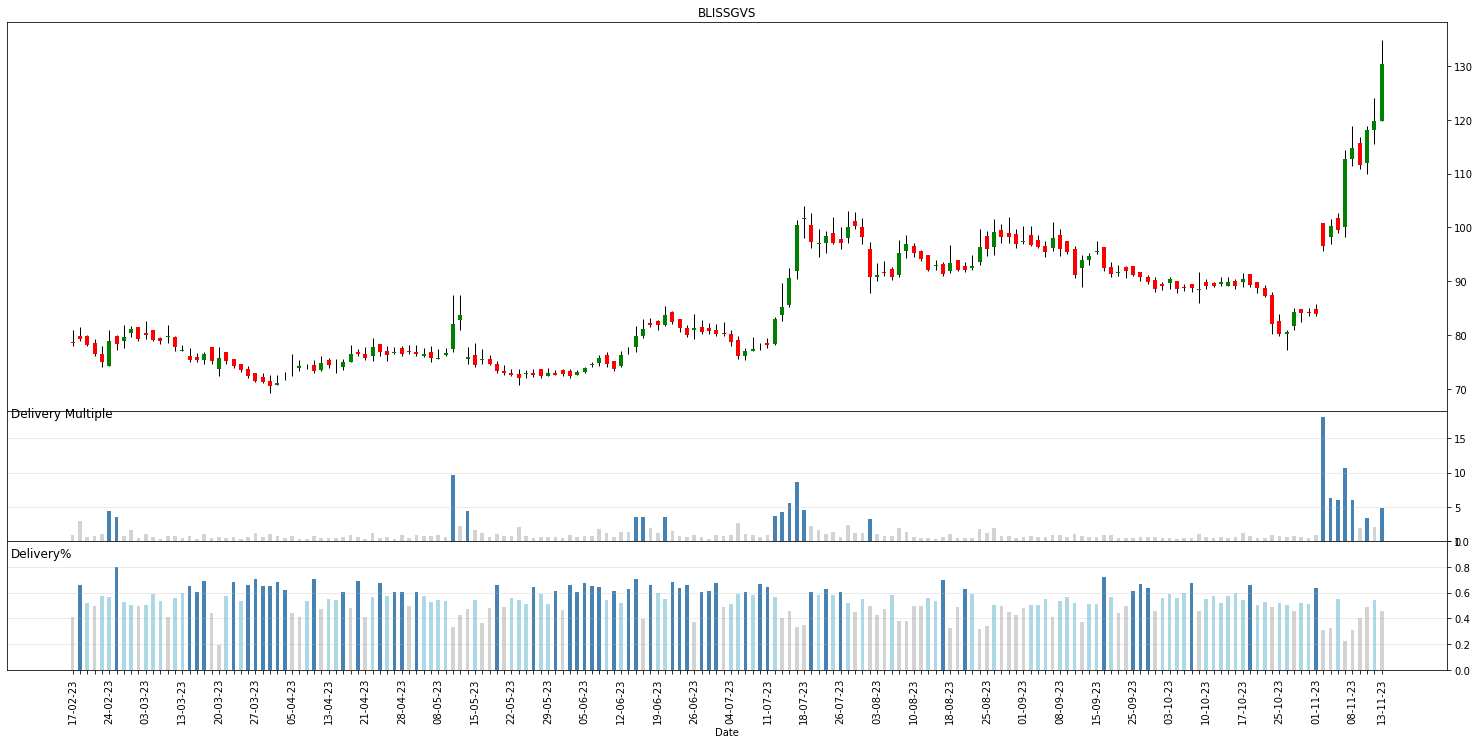

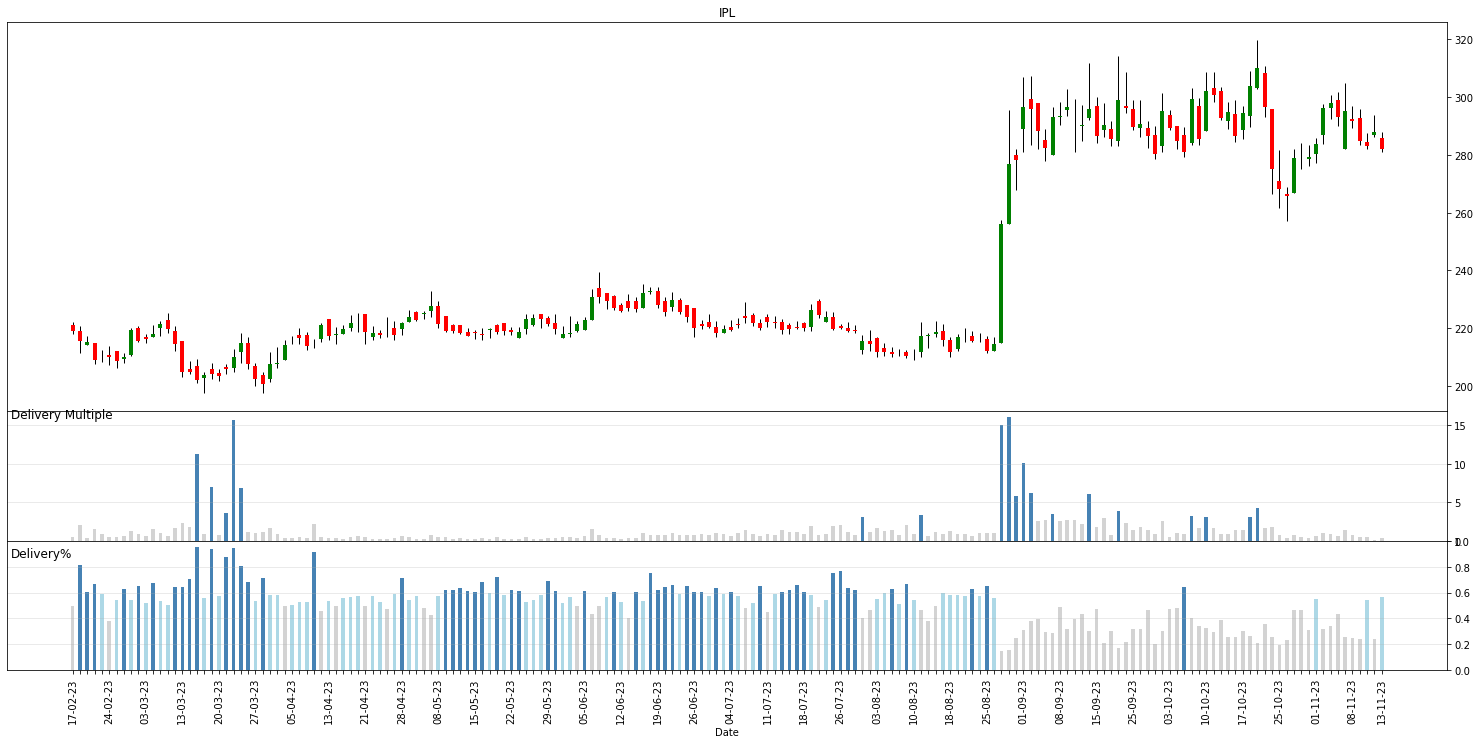

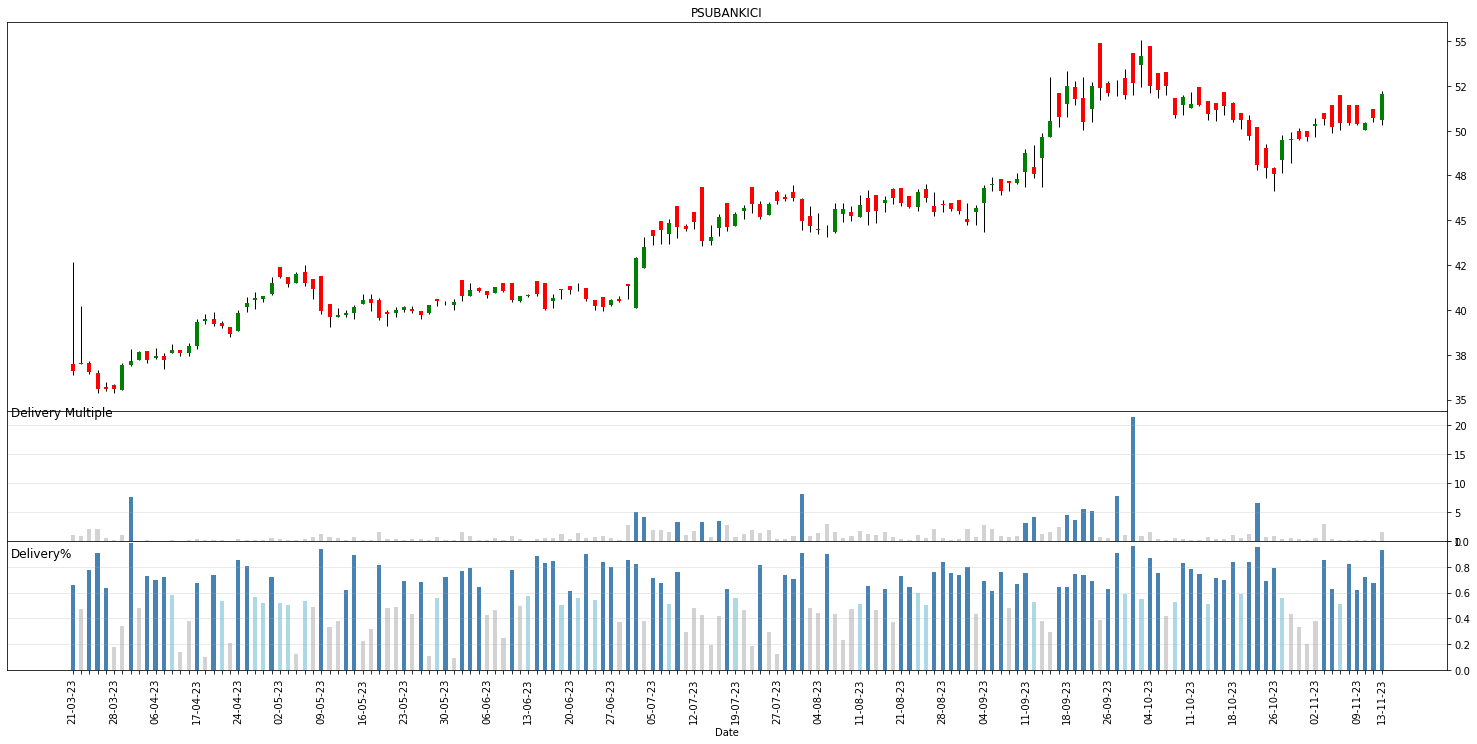

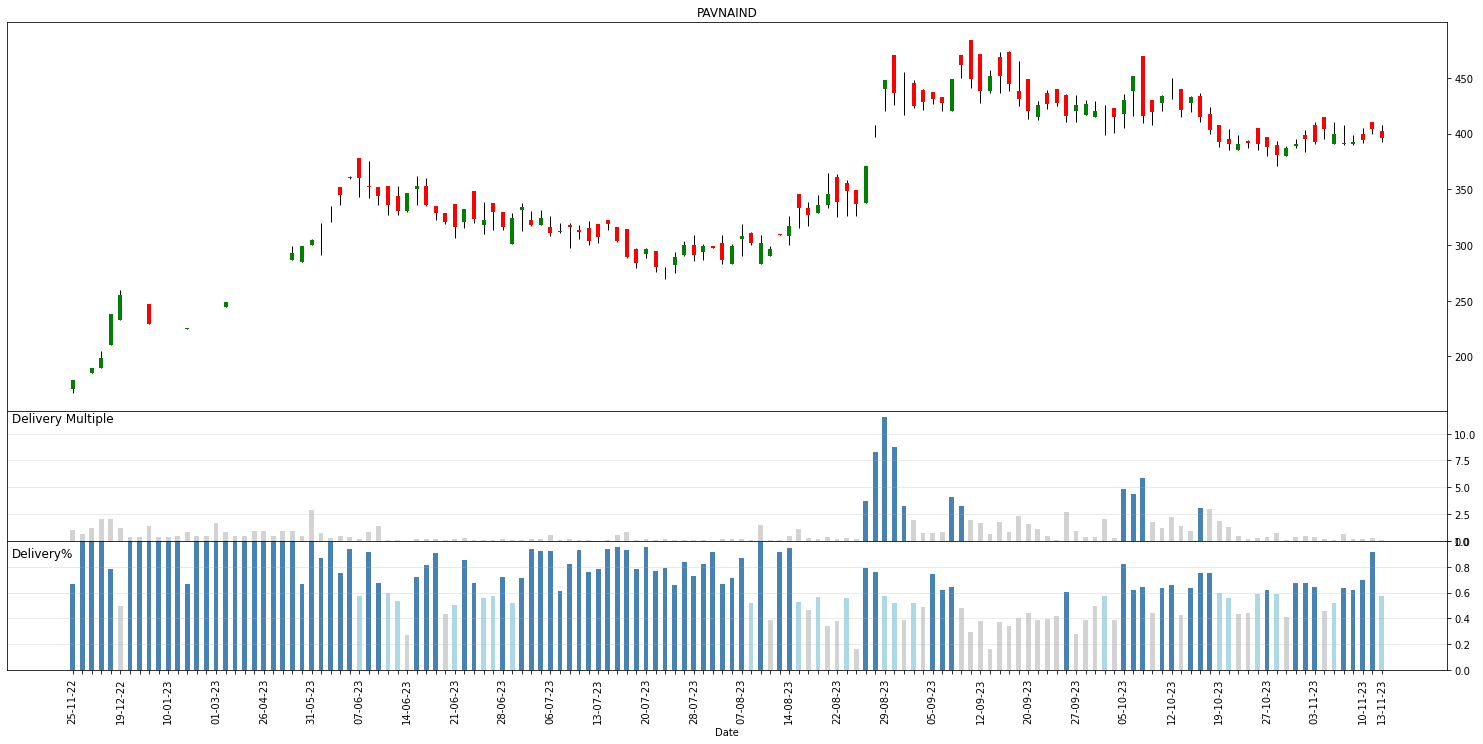

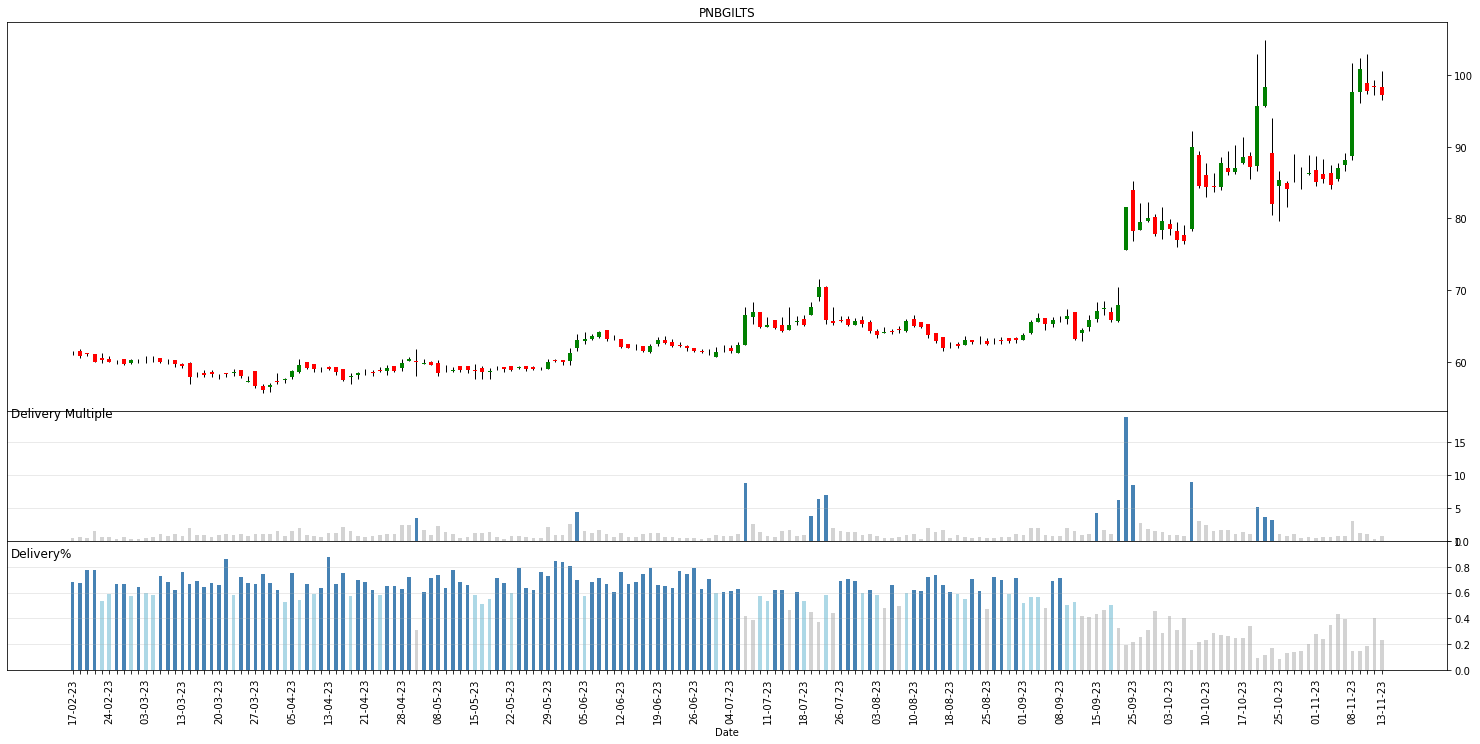

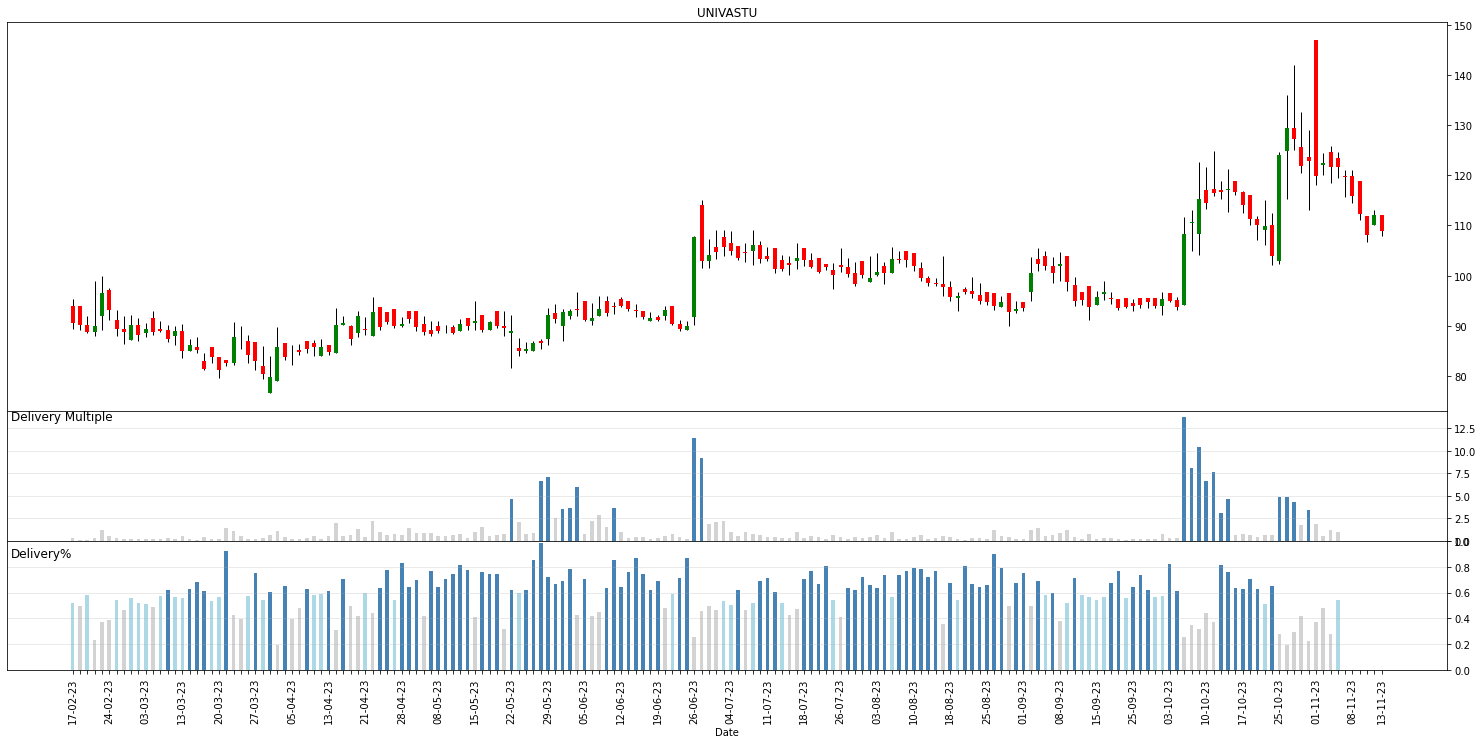

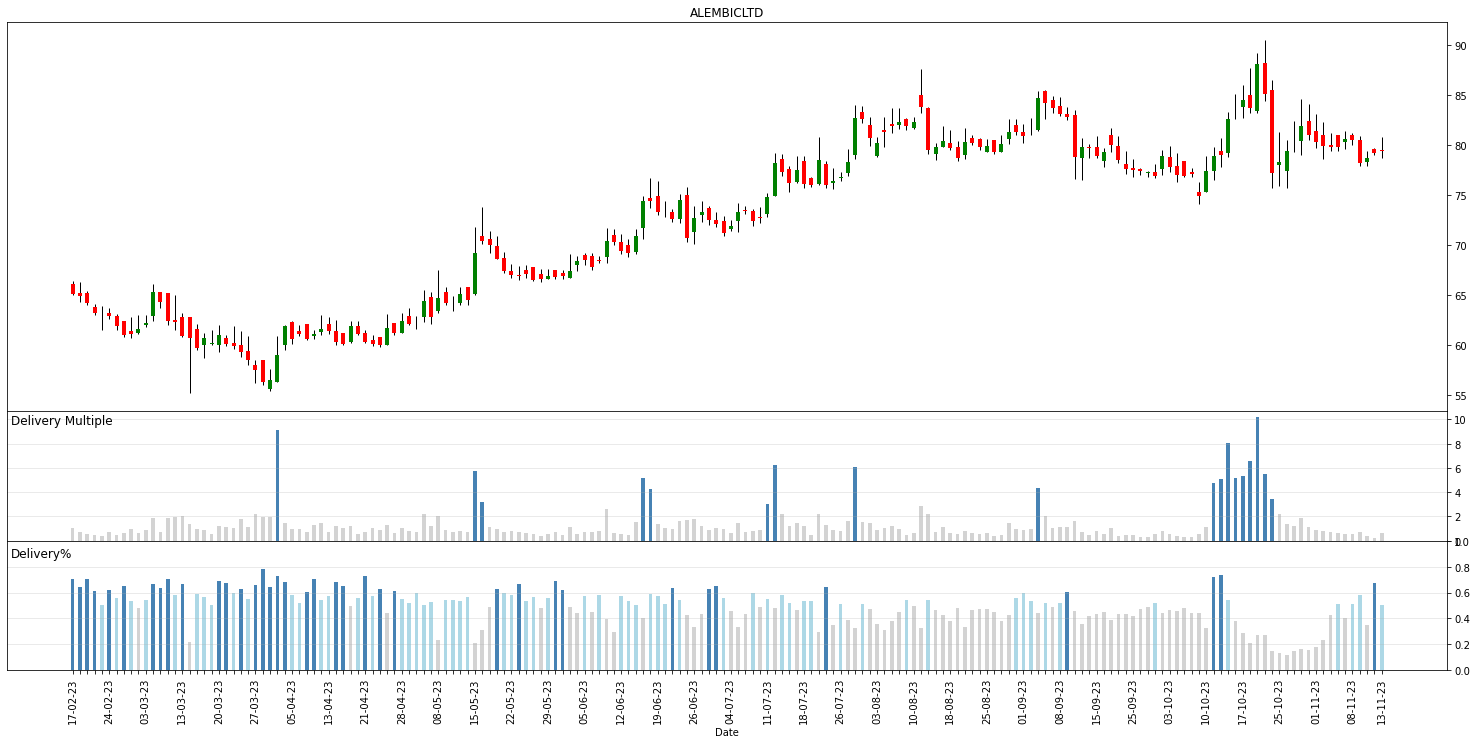

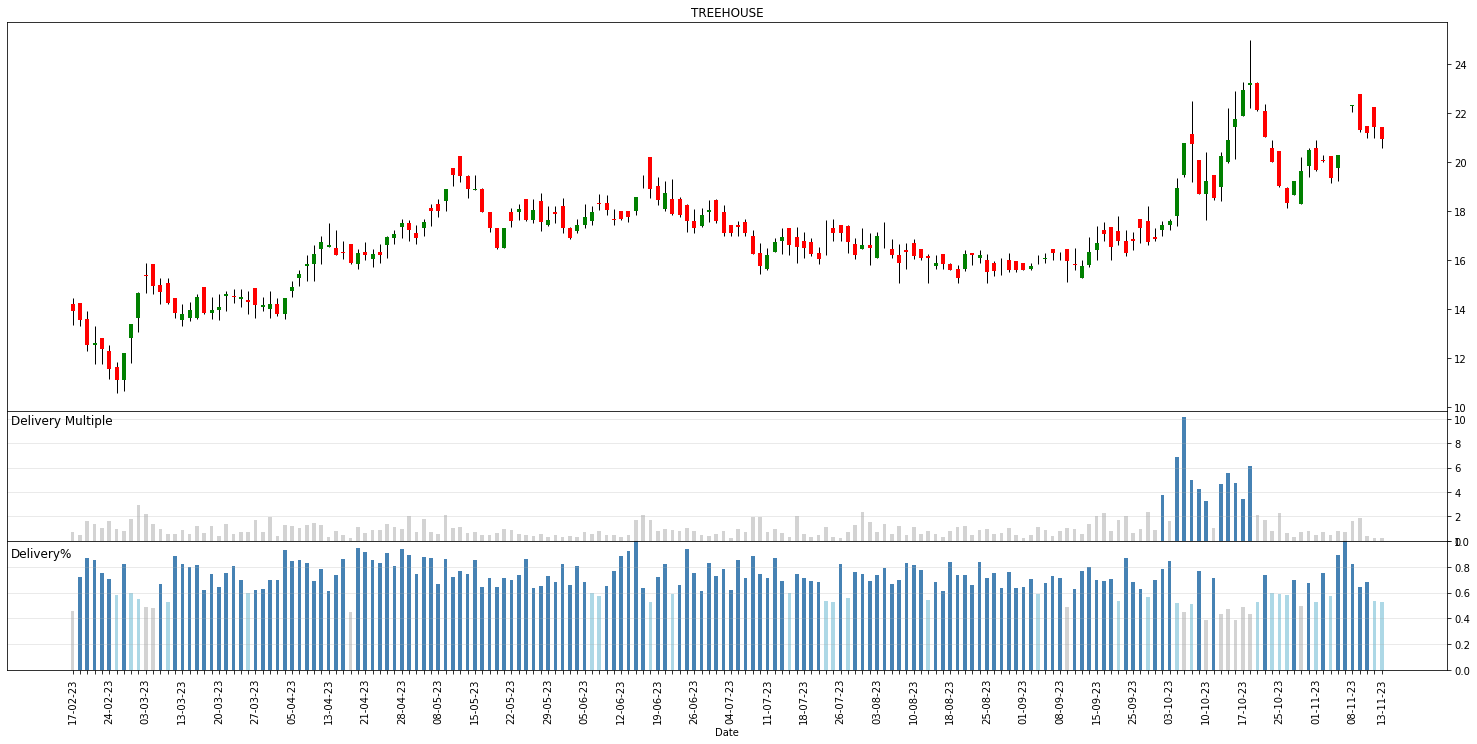

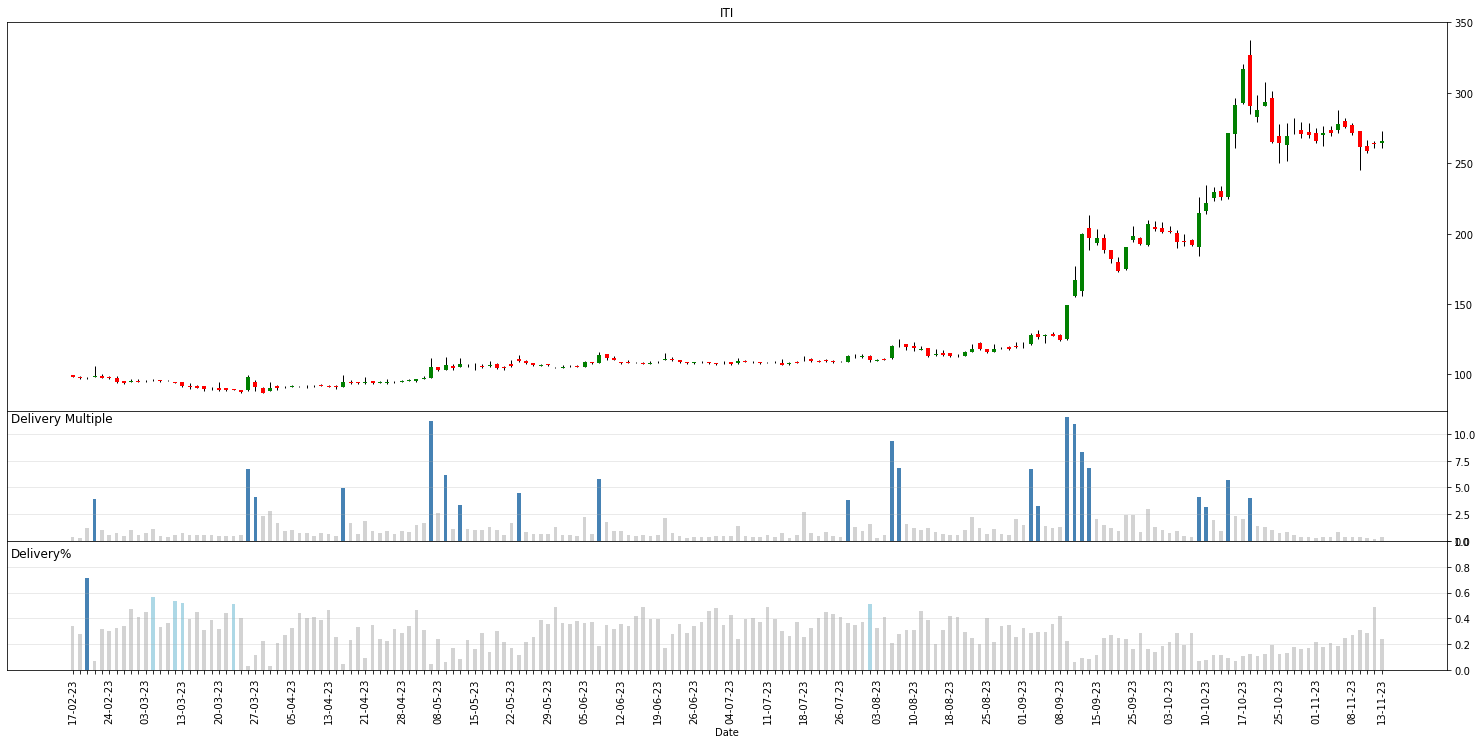

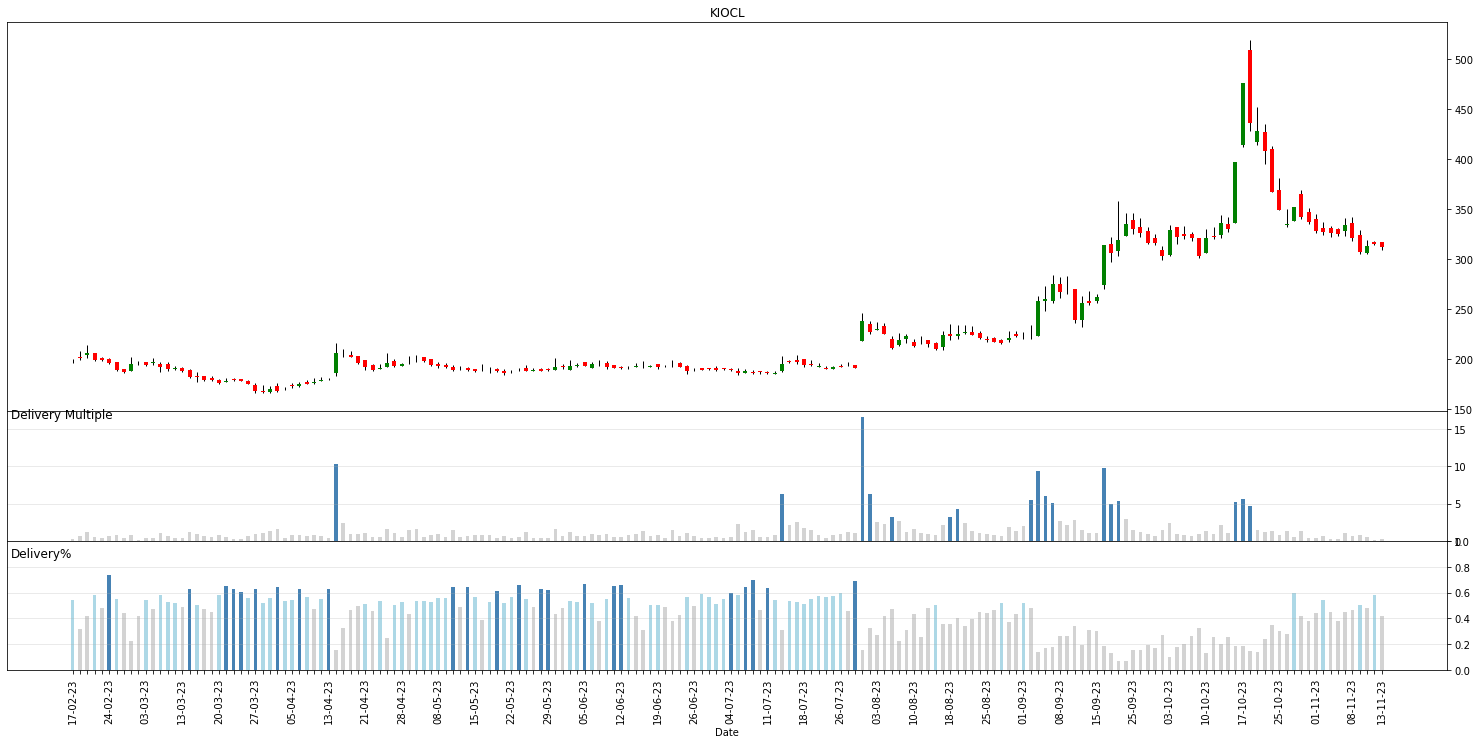

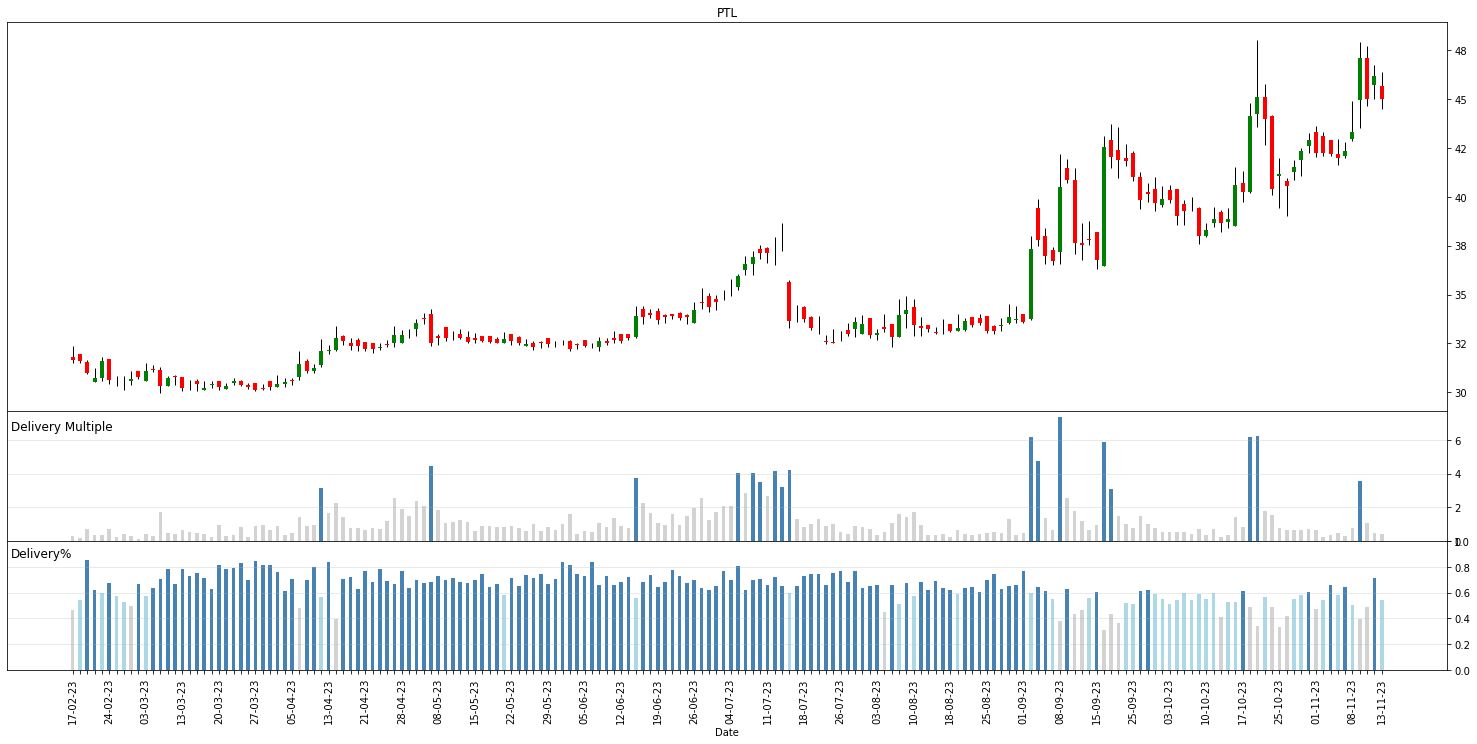

In [49]:
hax = chart(high_del_sym.index, data)

In [50]:
# High near deliveries, low far deliveries, price moving in a tight range
data['High_Dely'] = np.where(data["Delivery%"] > 0.5, 1, 0)
data['Null Dely'] = np.where(data["Delivery%"].isnull(), 1, 0)

data_near_lookback = data.loc[data.index[0:10]].copy()
df_near = data_near_lookback.groupby('Symbol').mean()['High_Dely']
df_near_high_dly_tkr = df_near[df_near > 0.8].index

data_far_lookback = data.loc[data.index[0:90]].copy()
df_far = data_far_lookback.groupby('Symbol').mean()[['High_Dely', 'Null Dely']]
df_far_high_dly_tkr = df_far[(df_far['High_Dely'] < 0.55) & 
                             (df_far['Null Dely'] < 0.05)].index

start_date = data.index.unique()[0].strftime('%Y-%m-%d')
end_date_near = data.index.unique()[5].strftime('%Y-%m-%d')
end_date_far = data.index.unique()[10].strftime('%Y-%m-%d')
#tkr_near = get_tickers(start_date, end_date_near, price_change_threshold = -0.05)
#tkr_far = get_tickers(end_date_near, end_date_far, price_change_threshold = -0.05)
#tkr_far2 = get_tickers(start_date, end_date_far, price_change_threshold = -0.05)

dly_tkr = df_near_high_dly_tkr.intersection(df_far_high_dly_tkr)
#new_found_interest = intersection(intersection(dly_tkr.tolist(), intersection(tkr_near, tkr_far)), tkr_far2)
new_found_interest = dly_tkr.tolist()
new_found_interest

['ARIES',
 'ARMANFIN',
 'BANG',
 'BEPL',
 'BHARATWIRE',
 'DCBBANK',
 'EIHAHOTELS',
 'GENUSPOWER',
 'HSCL',
 'ICIL',
 'IDFC',
 'LANDMARK',
 'MENONBE',
 'TARC',
 'VINYLINDIA',
 'ZUARI']

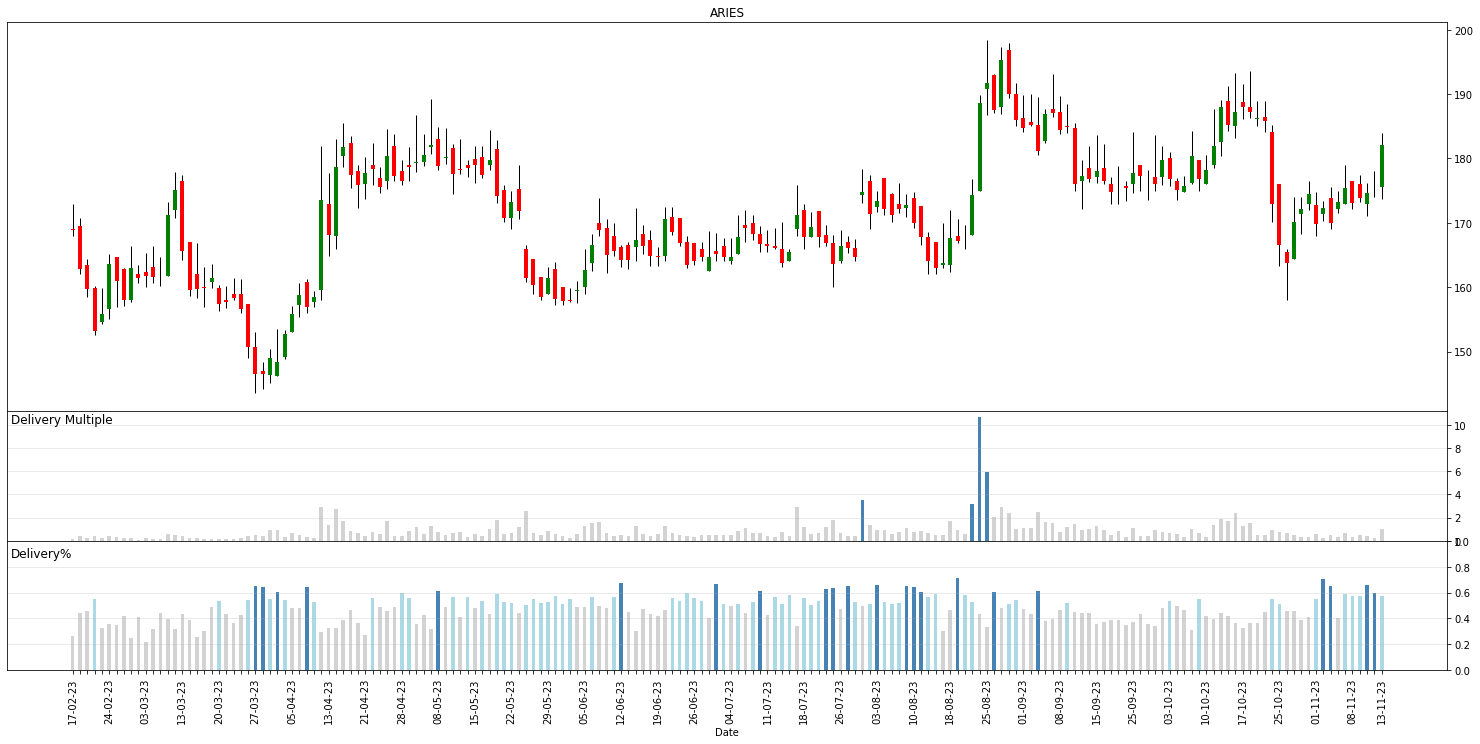

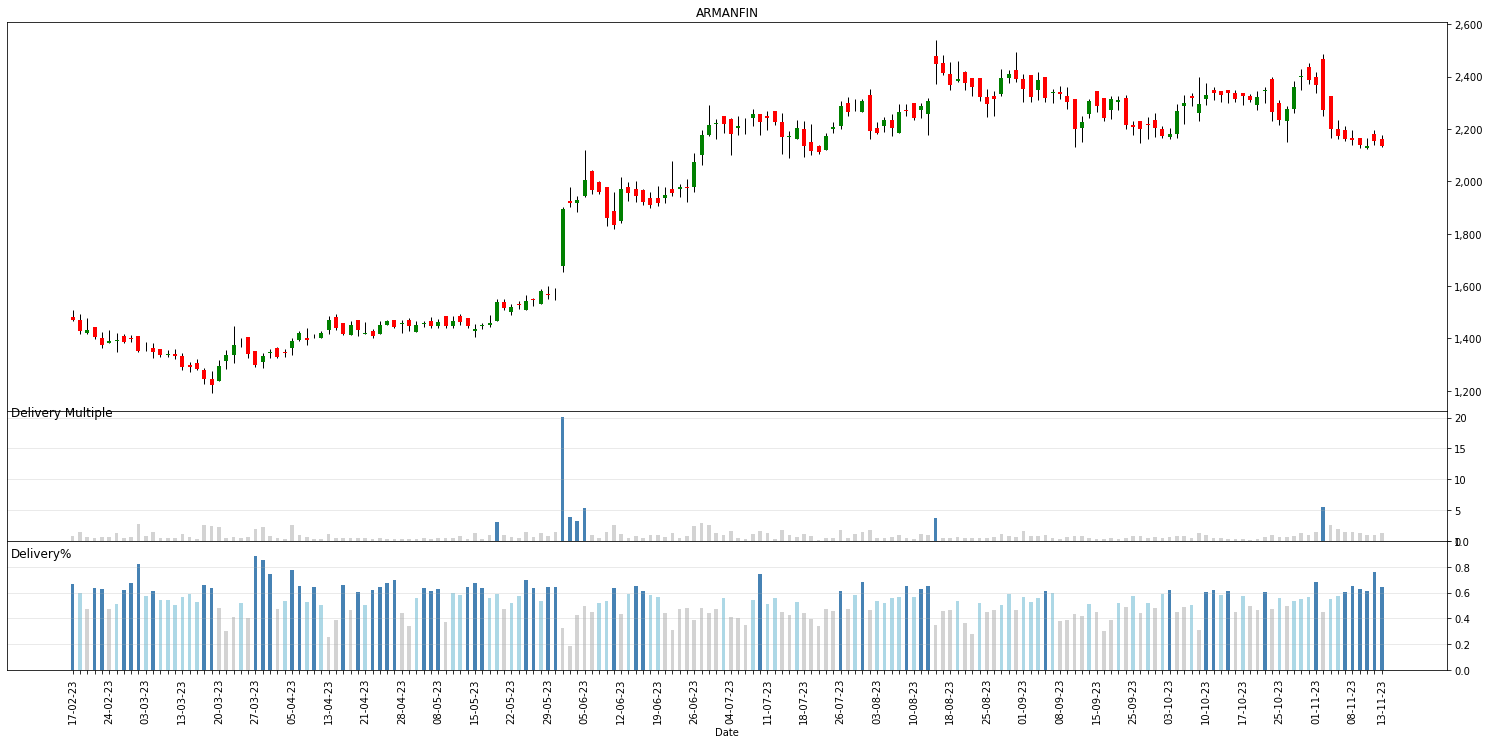

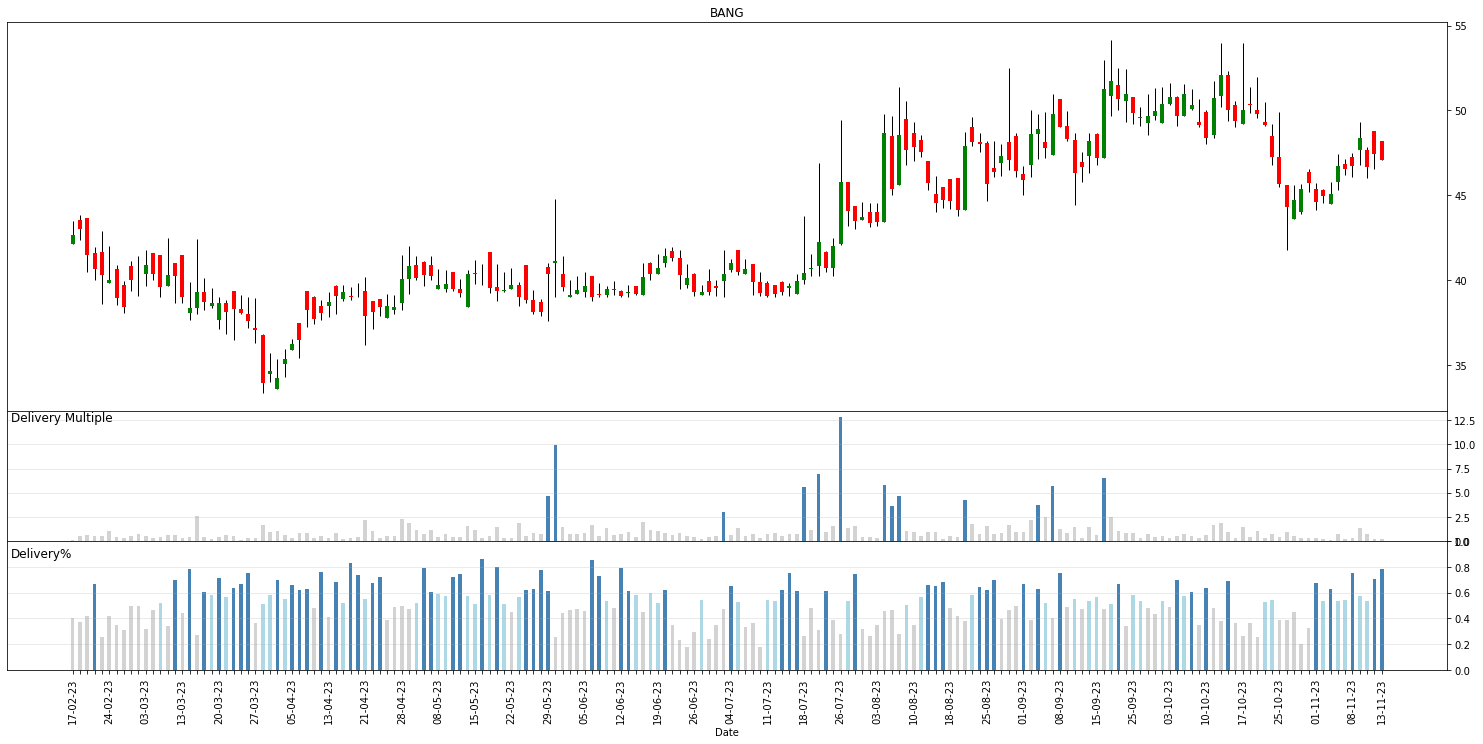

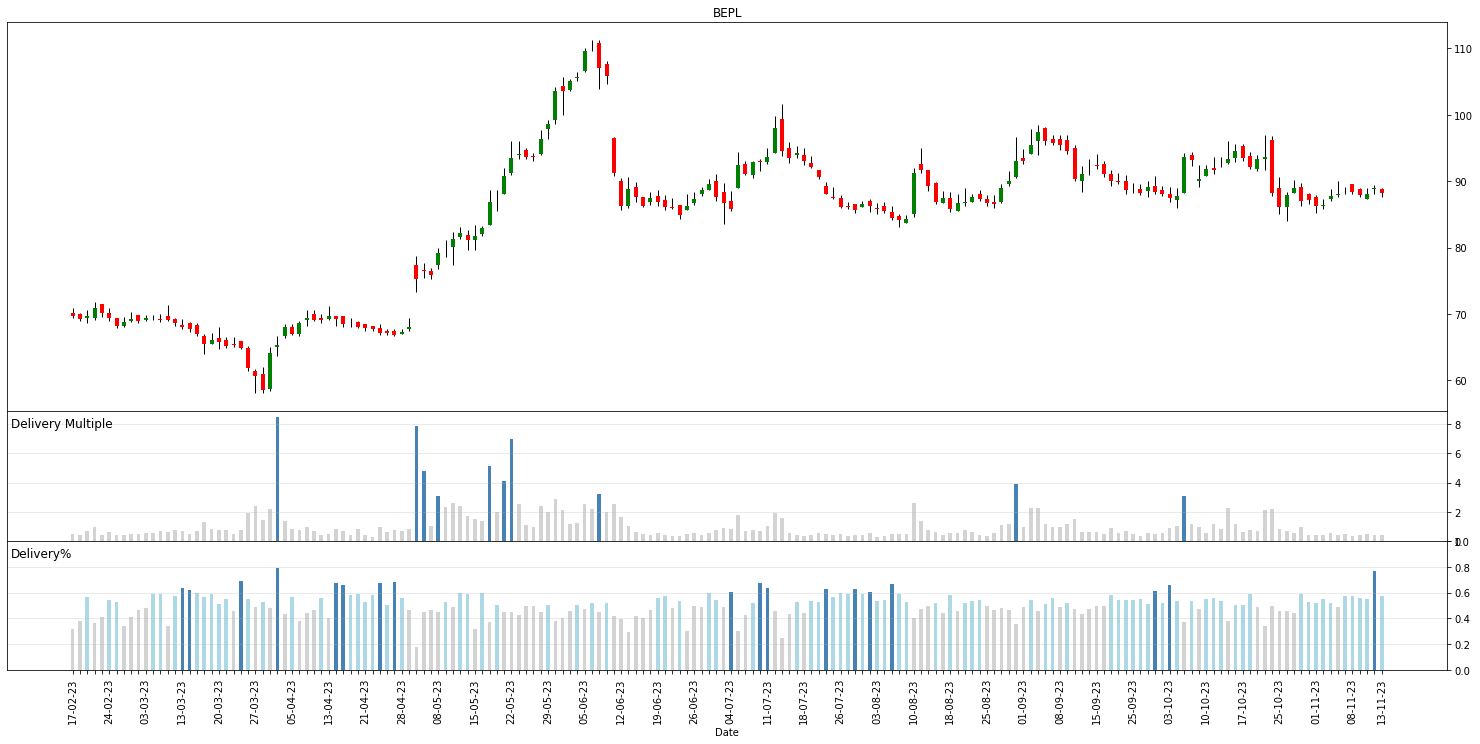

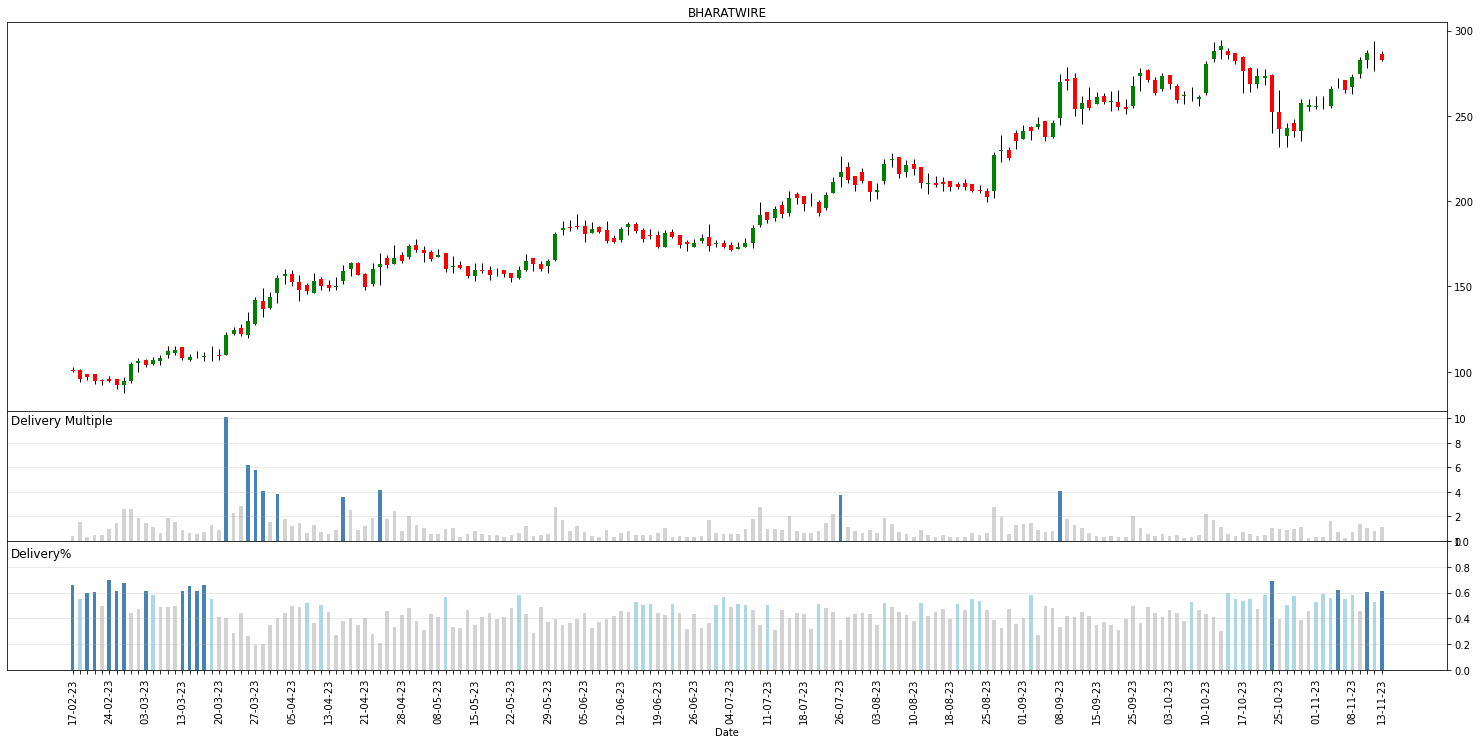

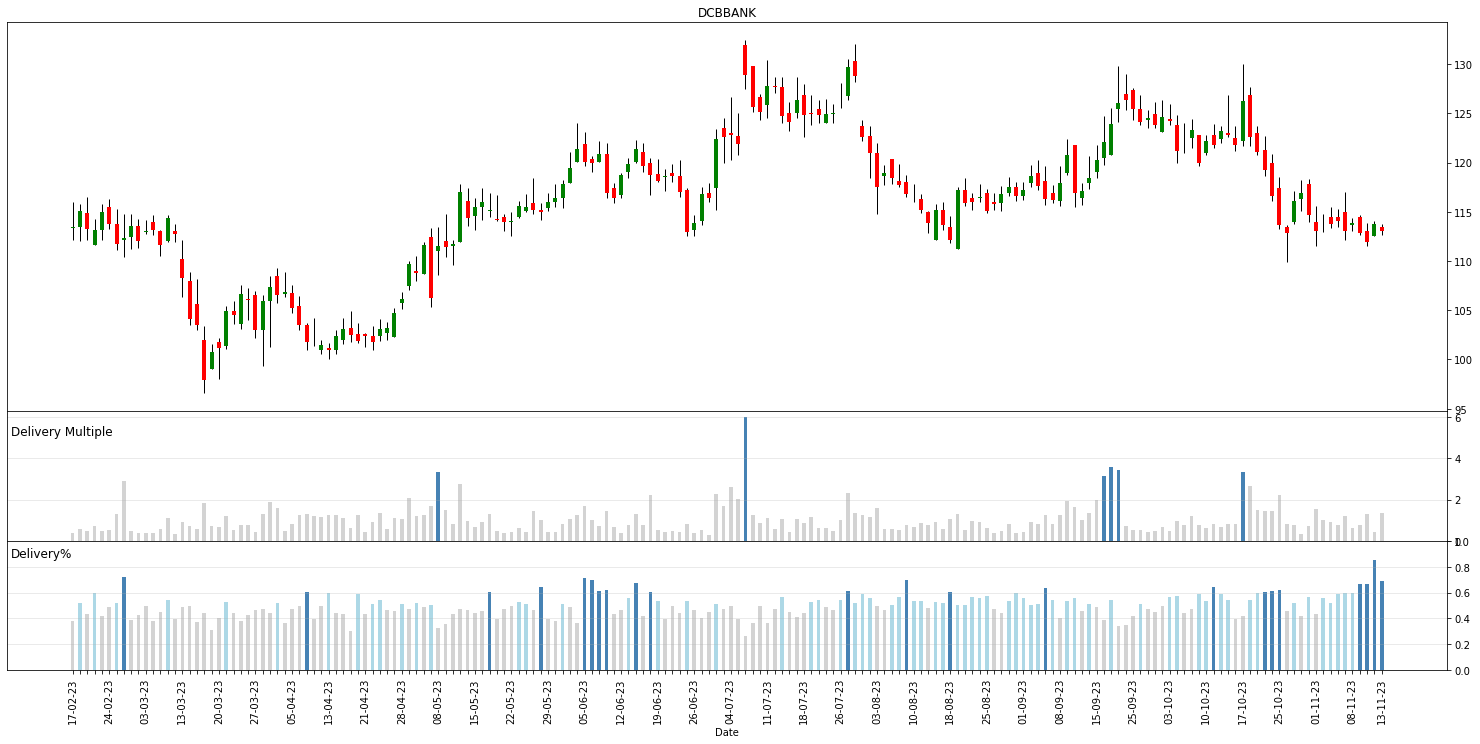

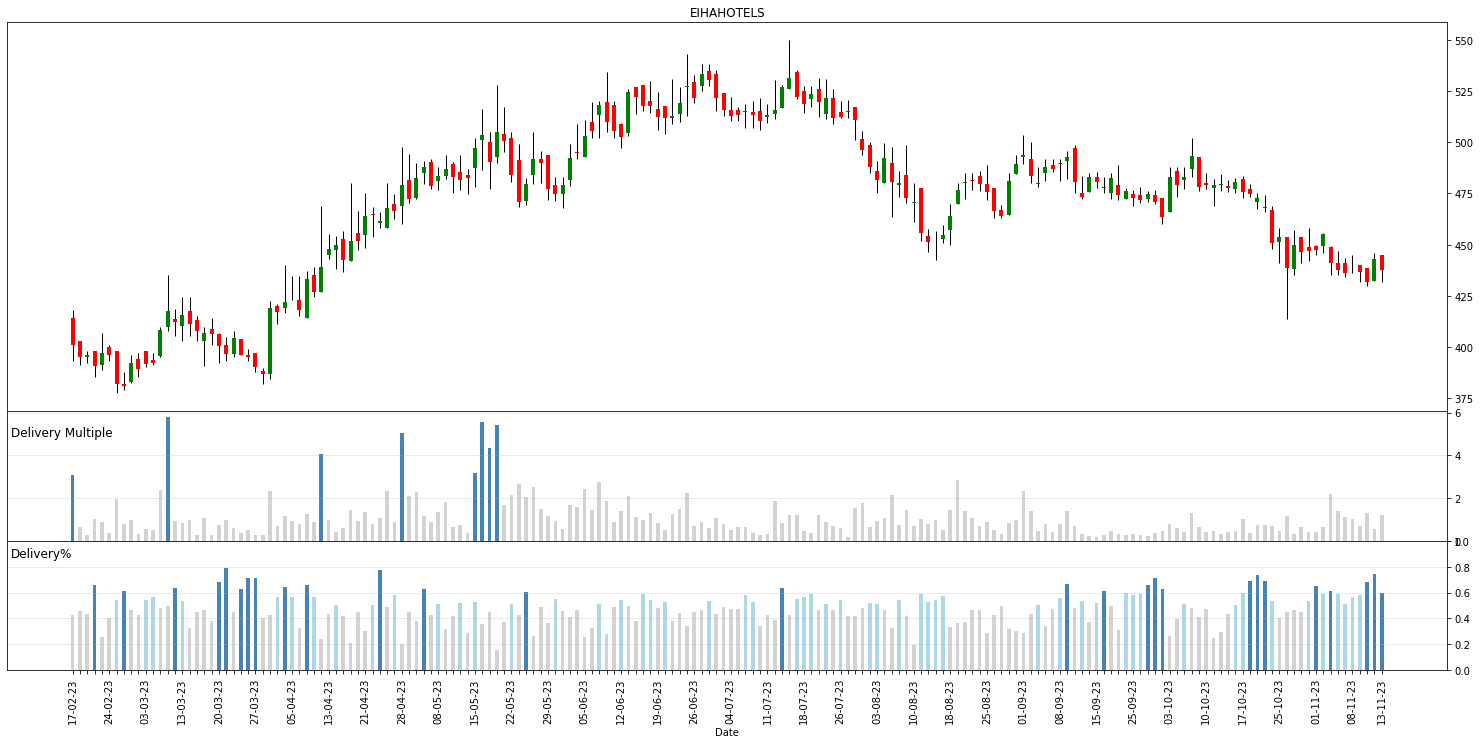

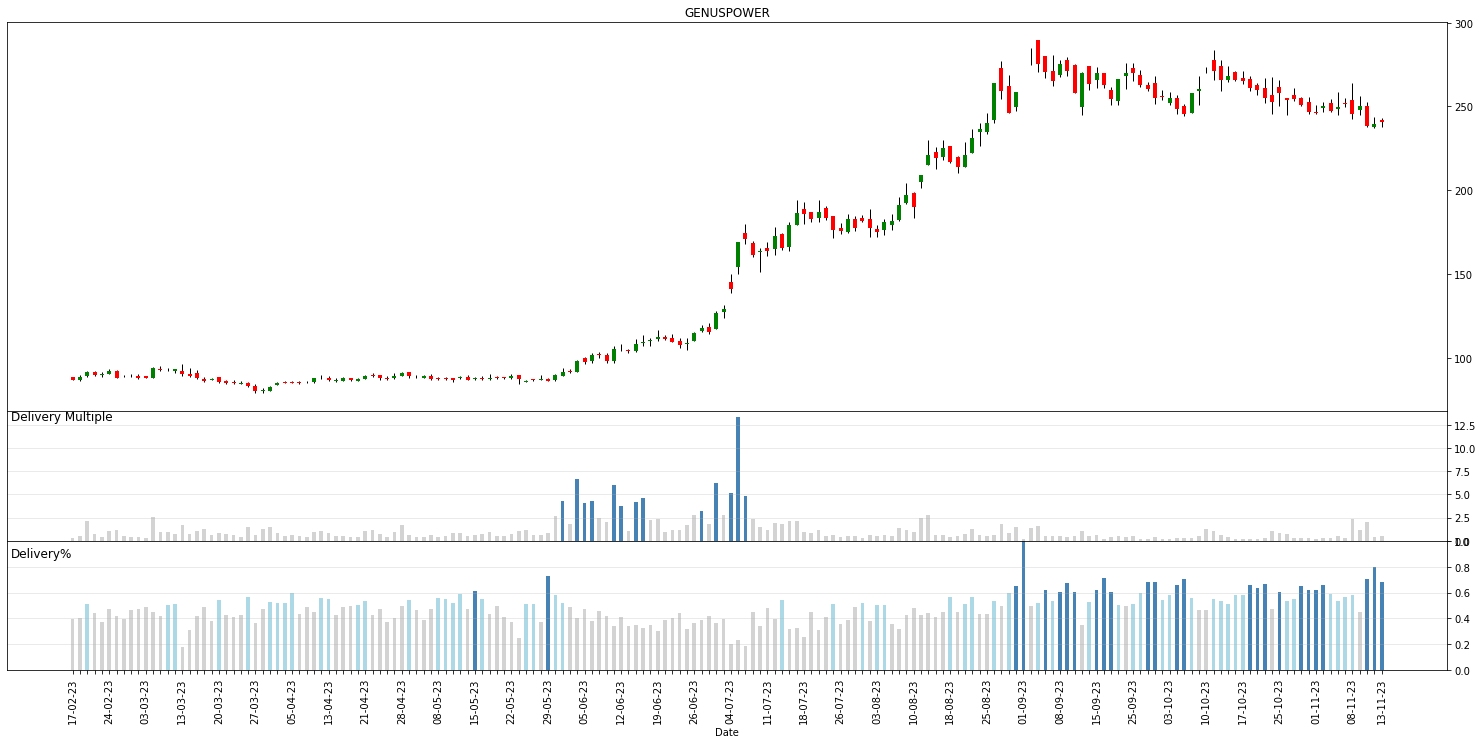

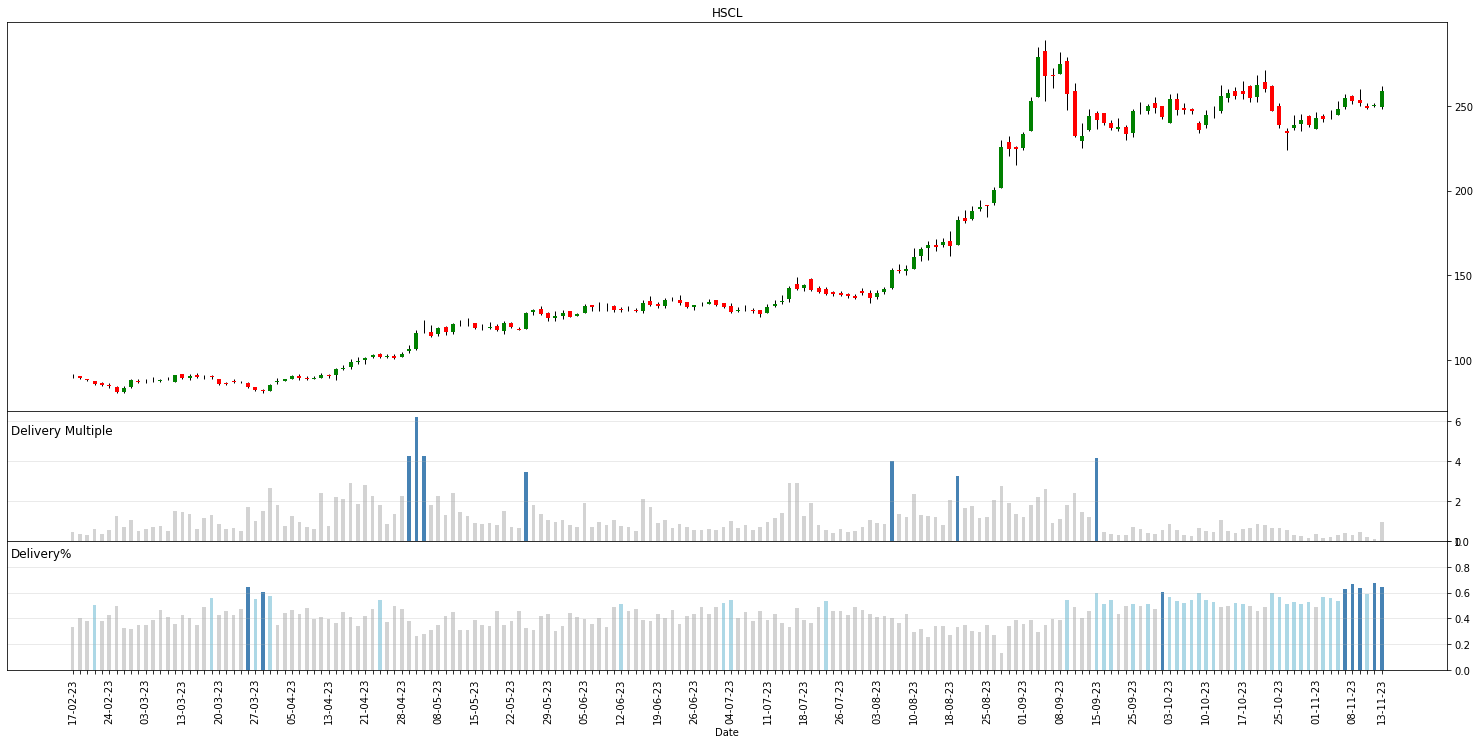

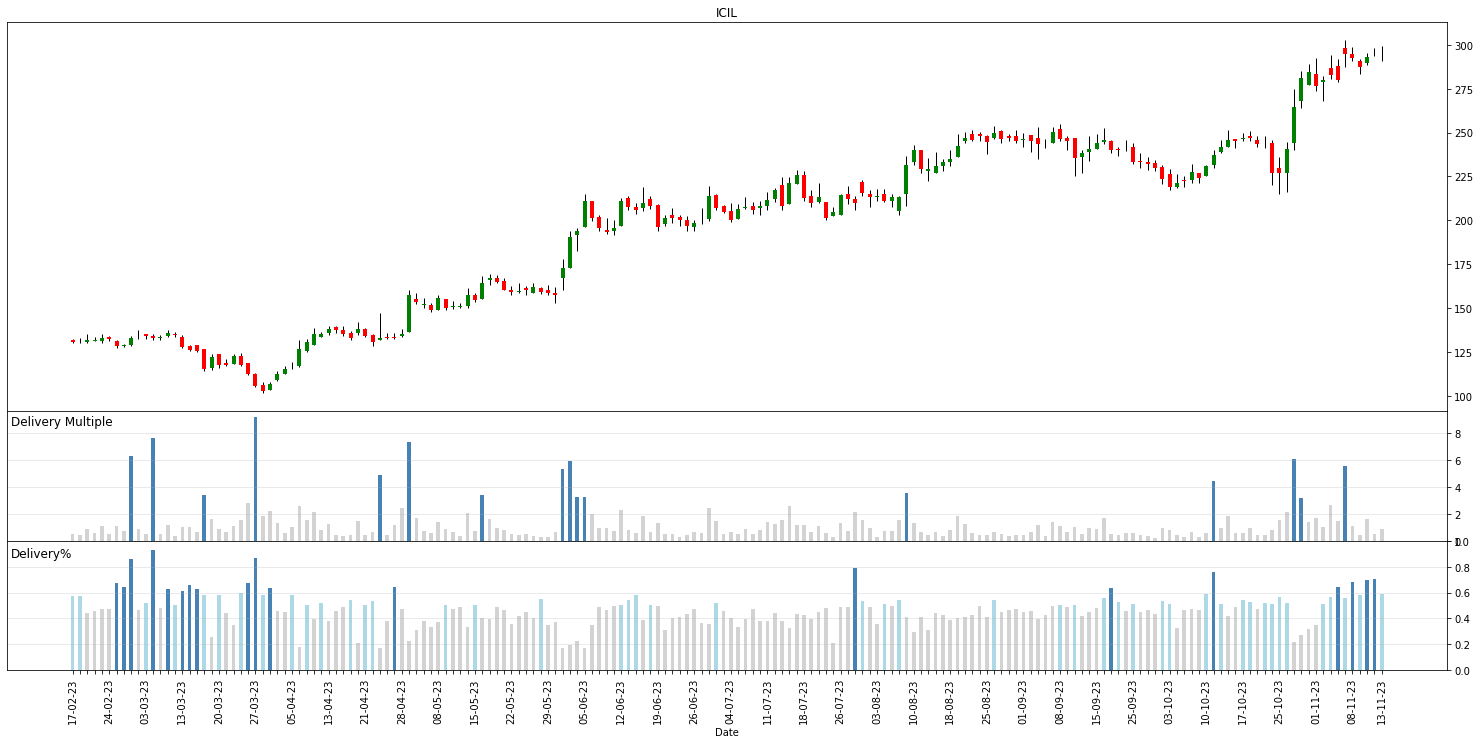

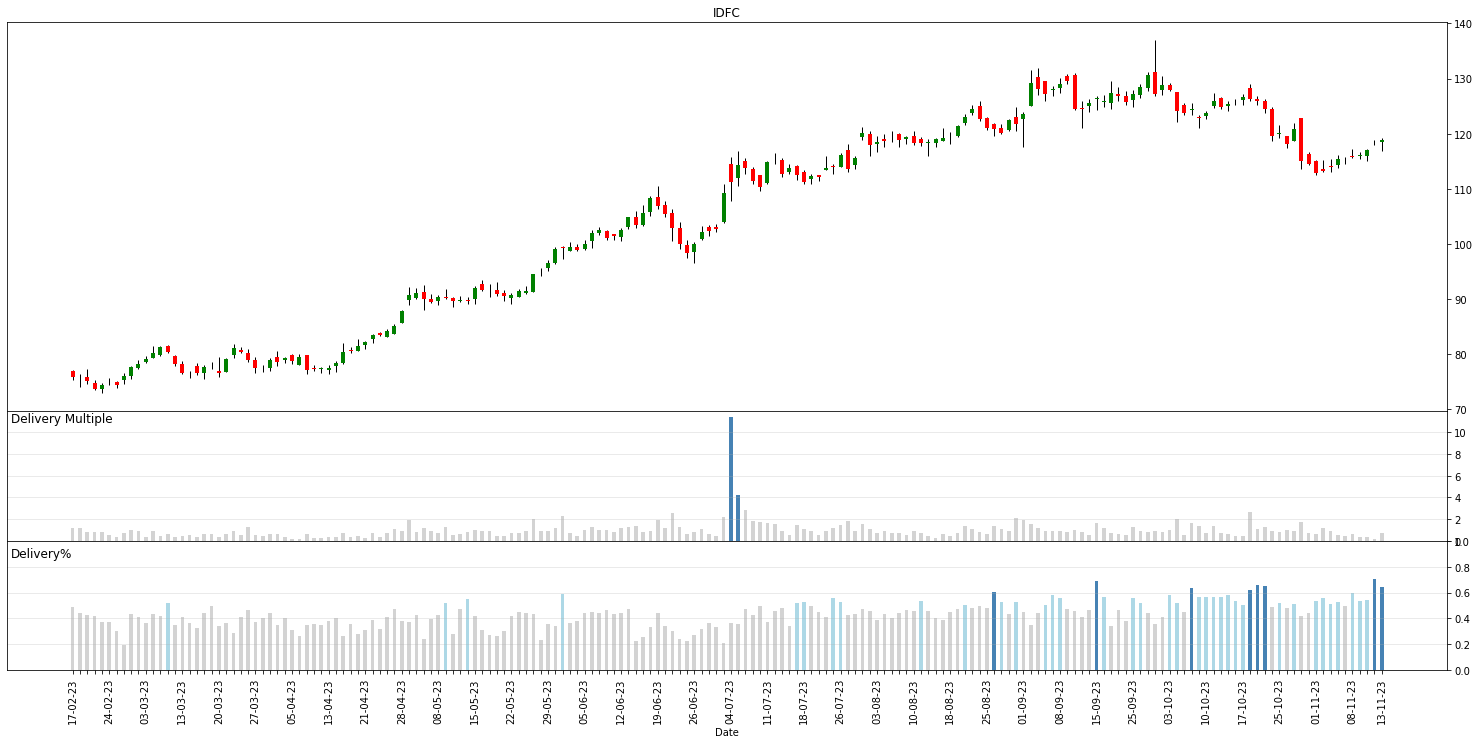

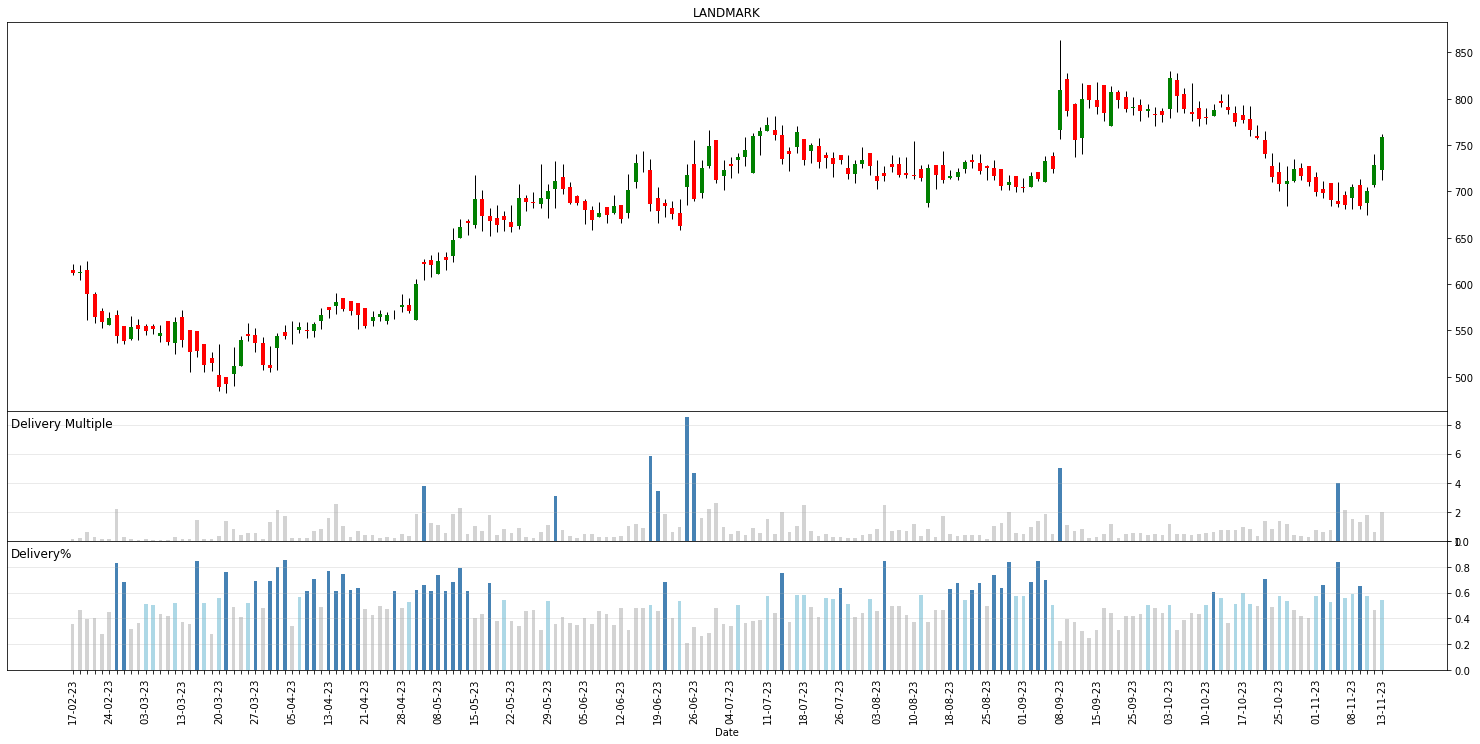

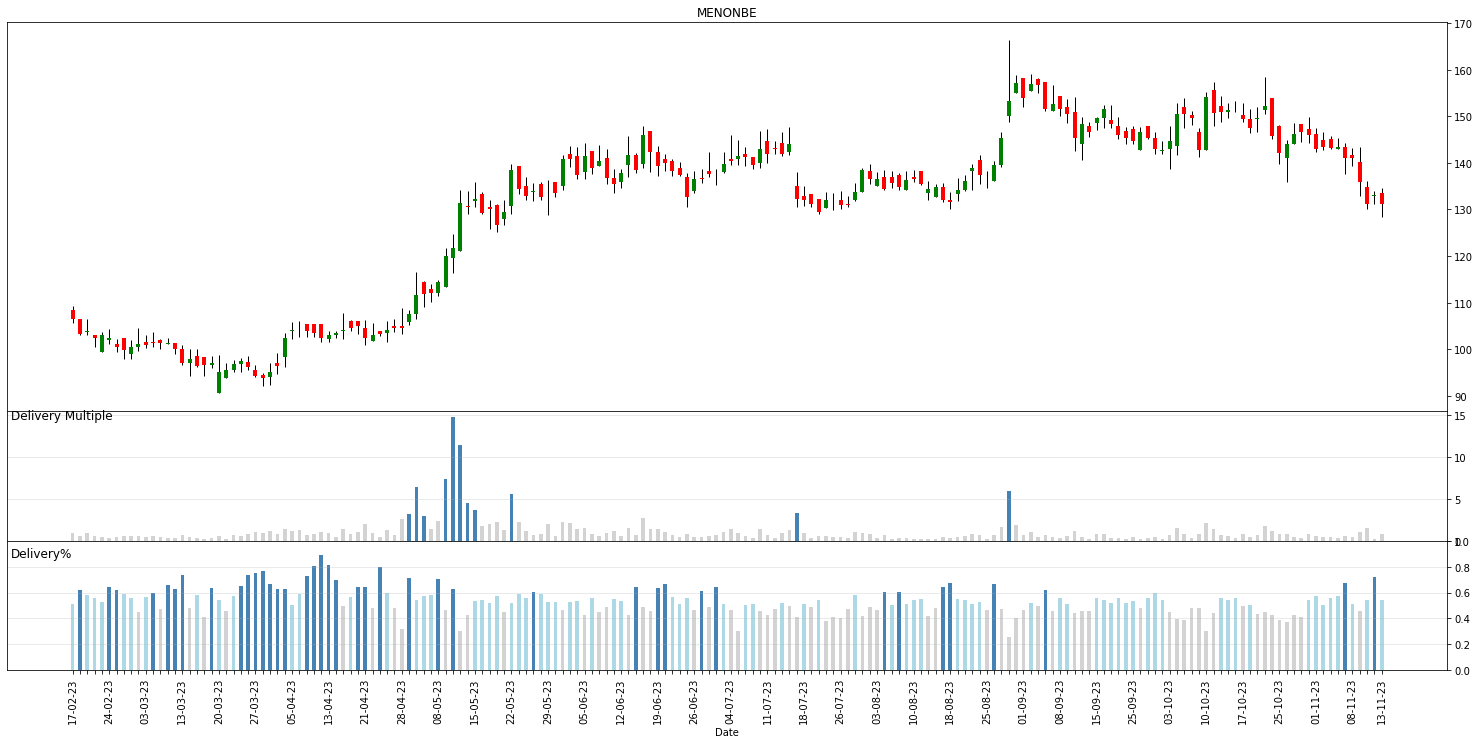

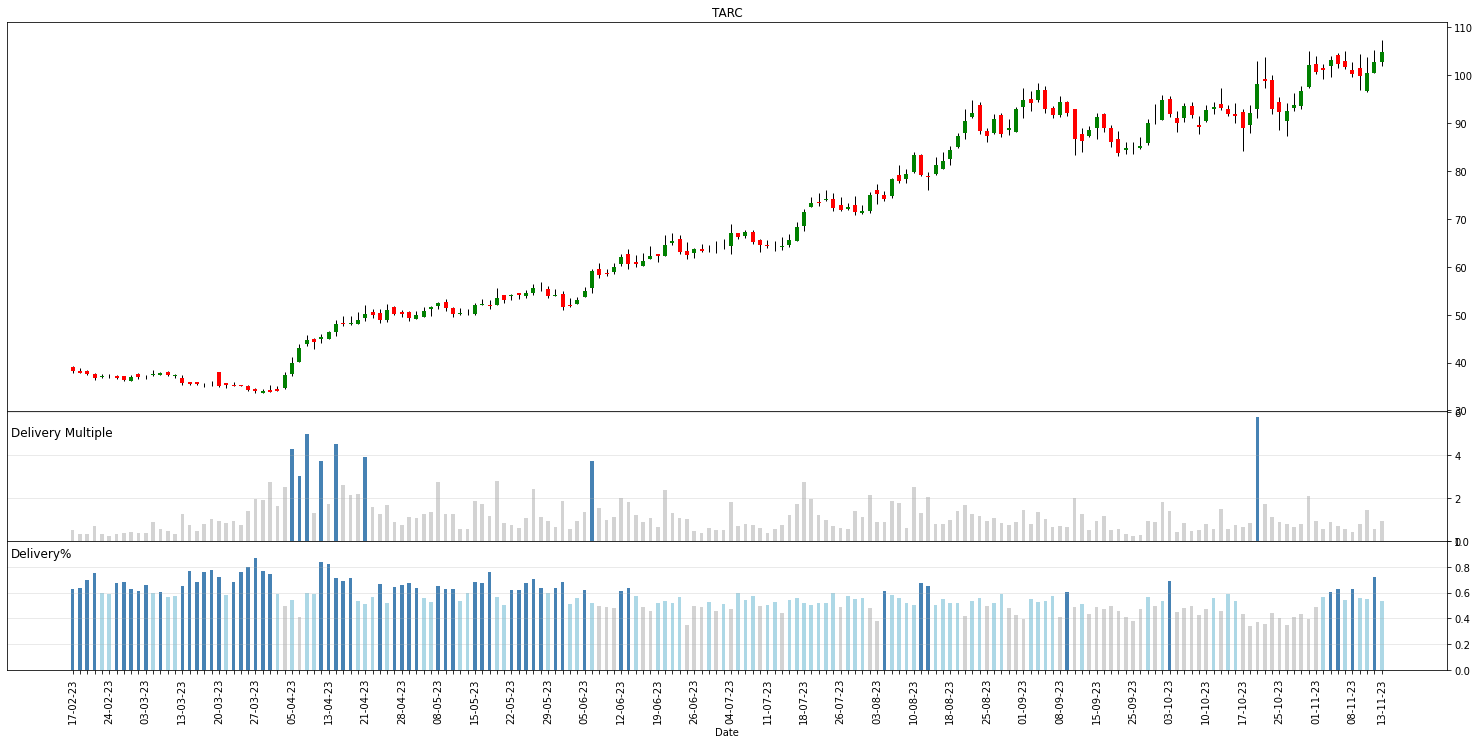

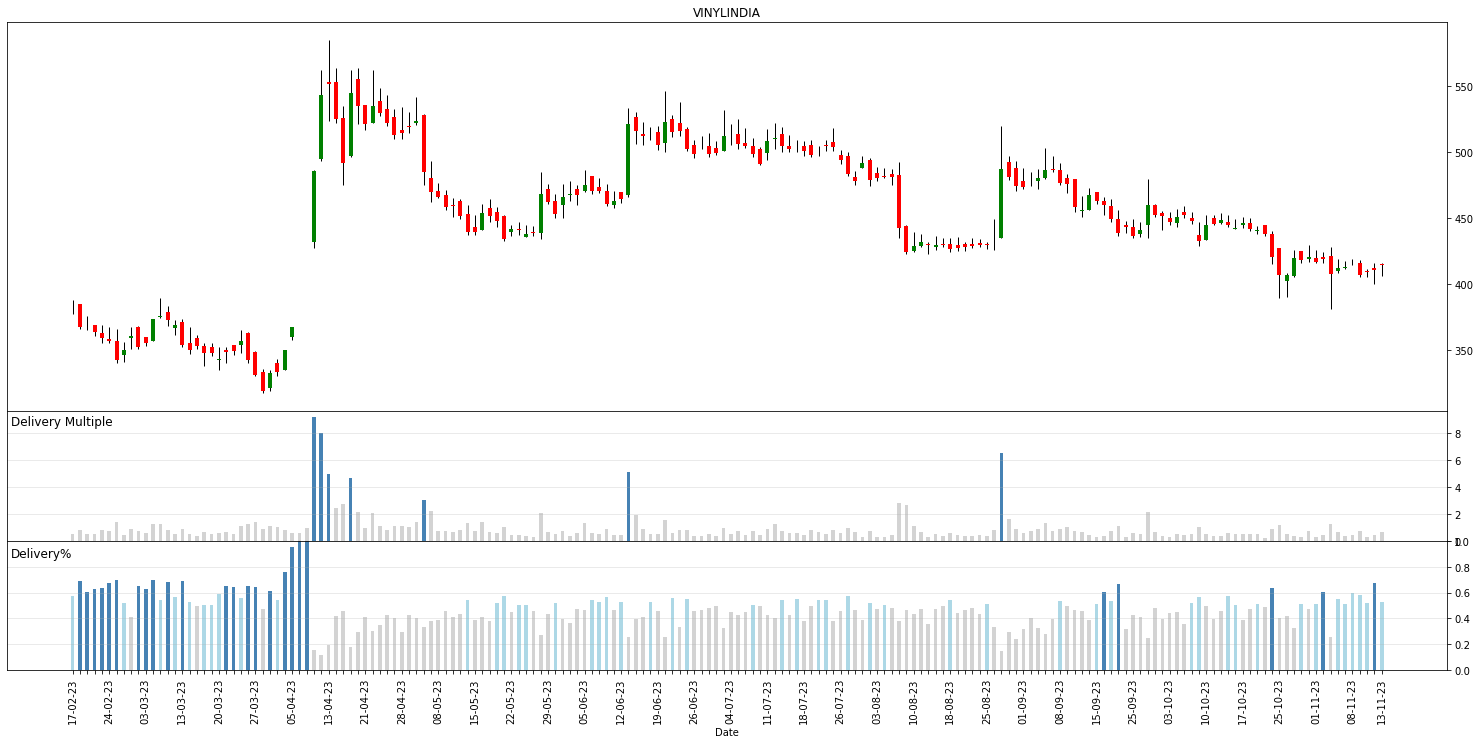

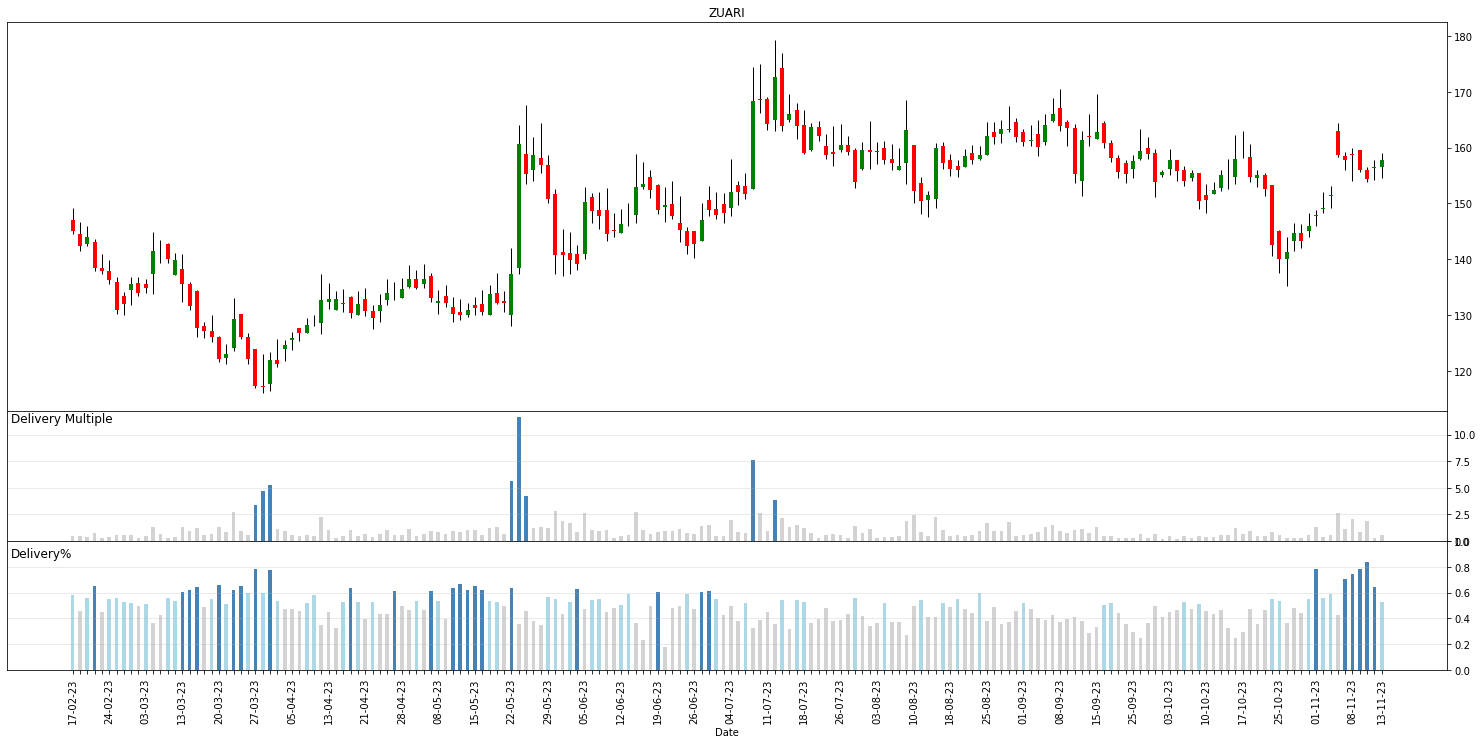

In [51]:
hax = chart(new_found_interest, data)

### Plots

#### Portfolio Watchlist

In [53]:
'LLOYDSENGG' in sym_list

True

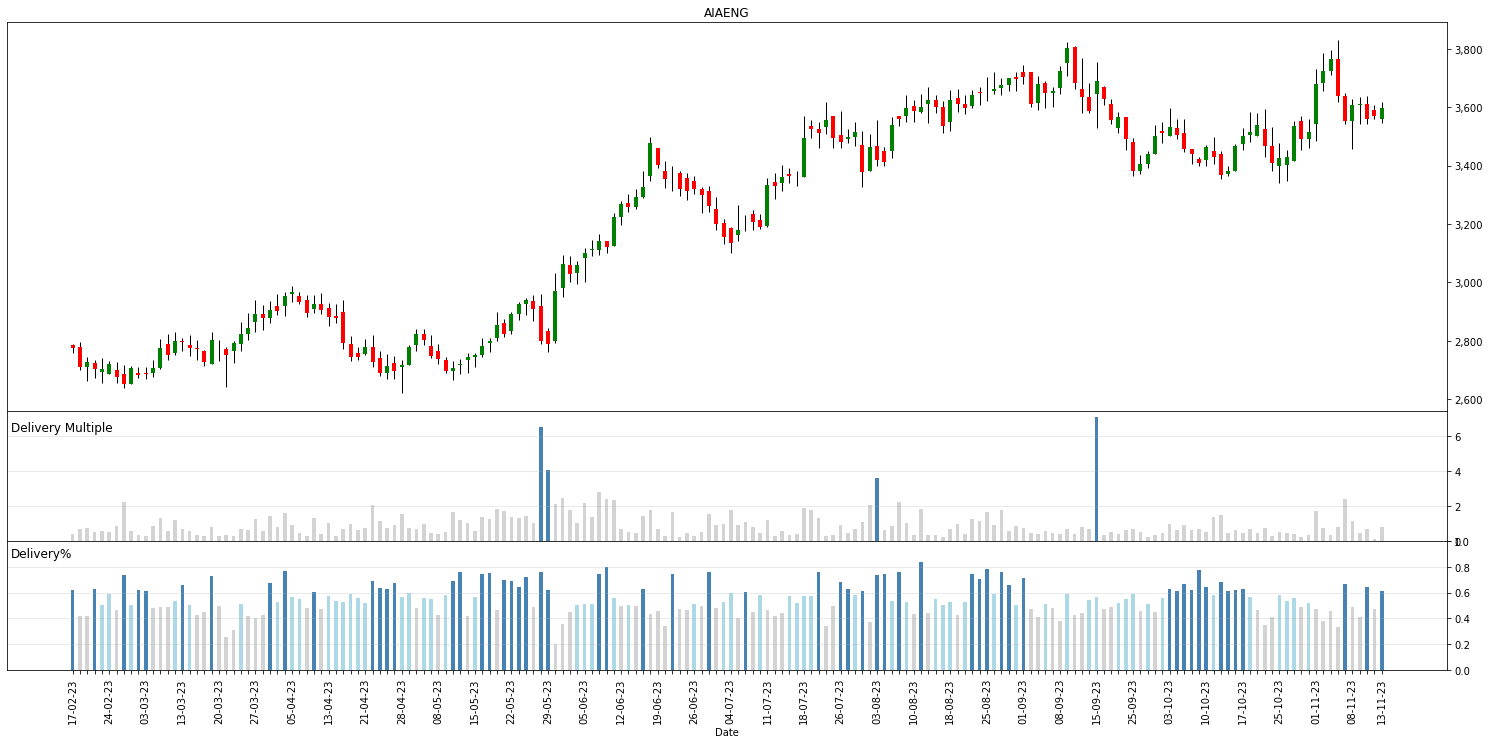

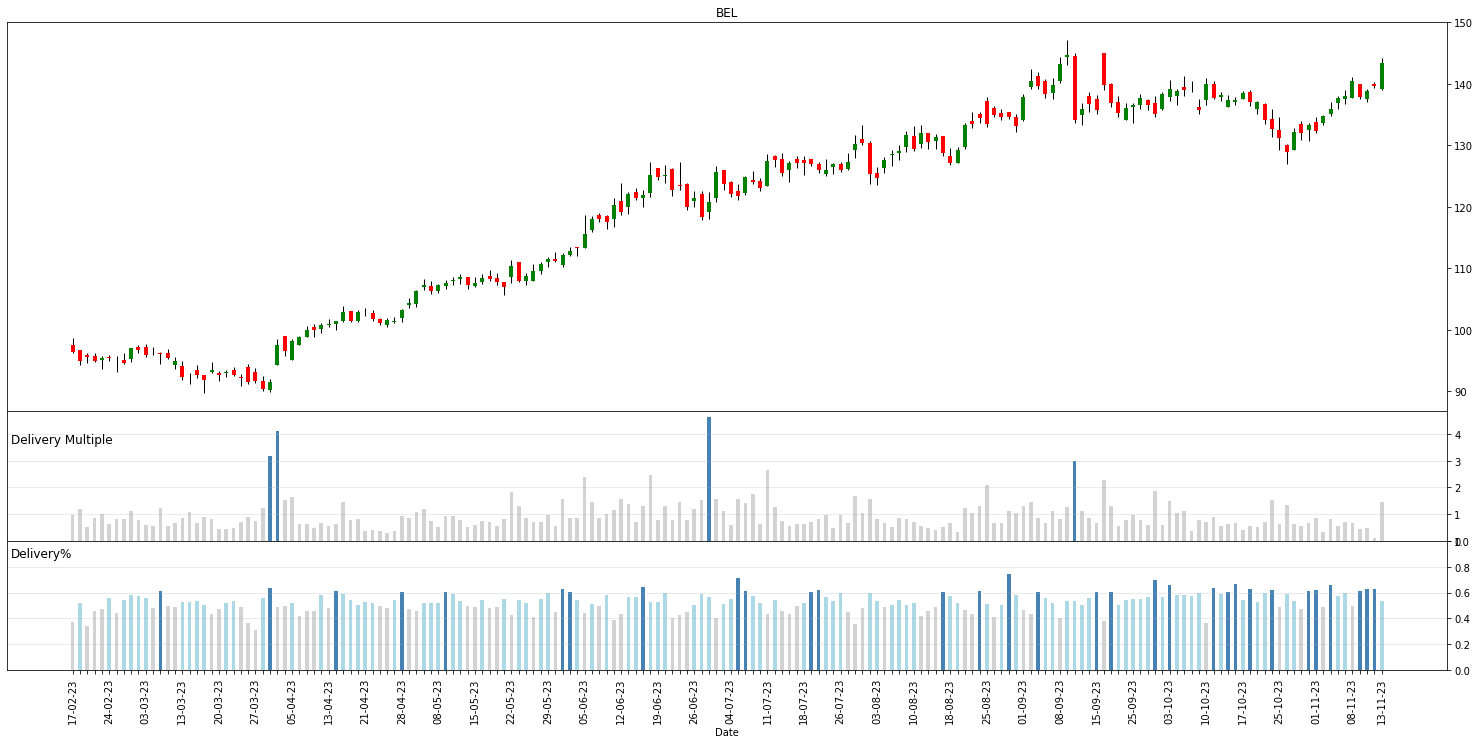

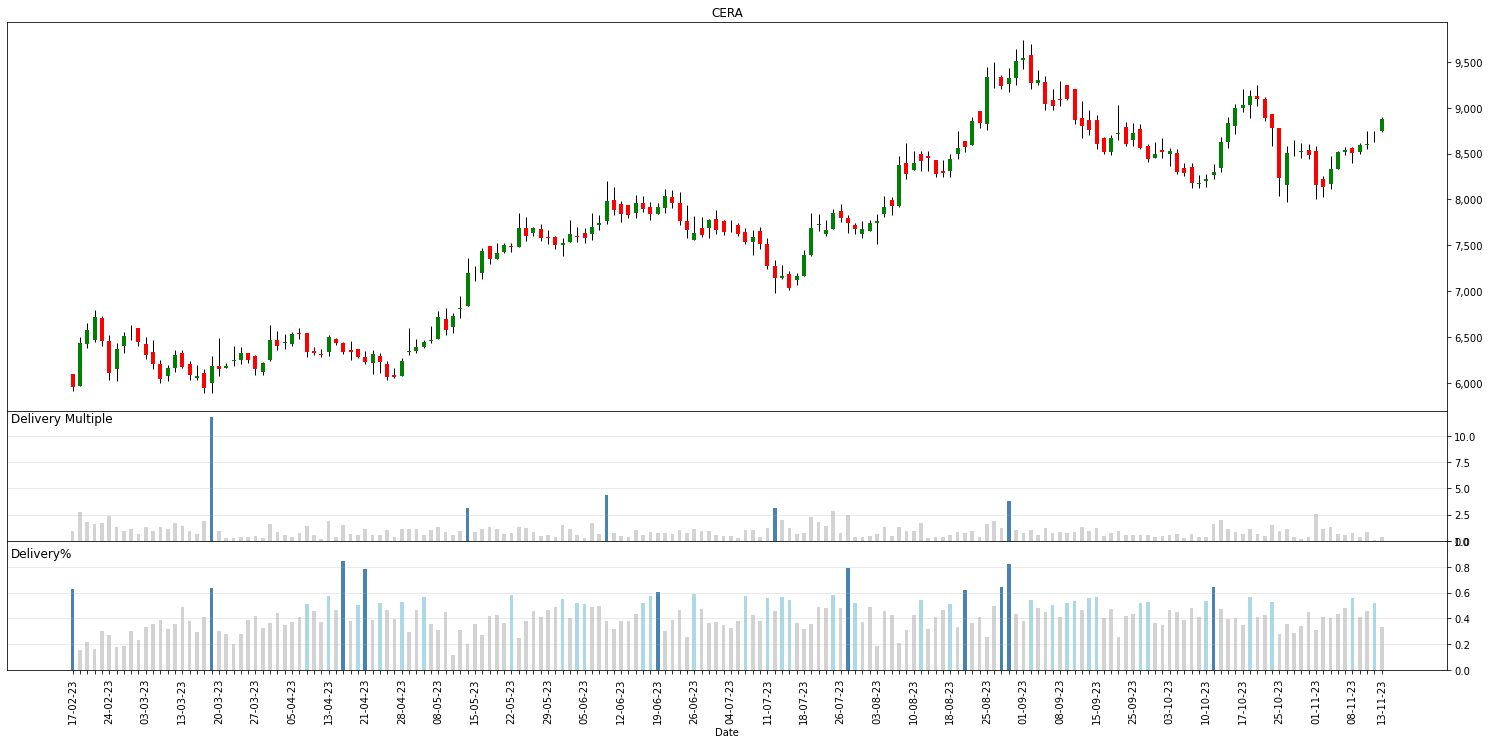

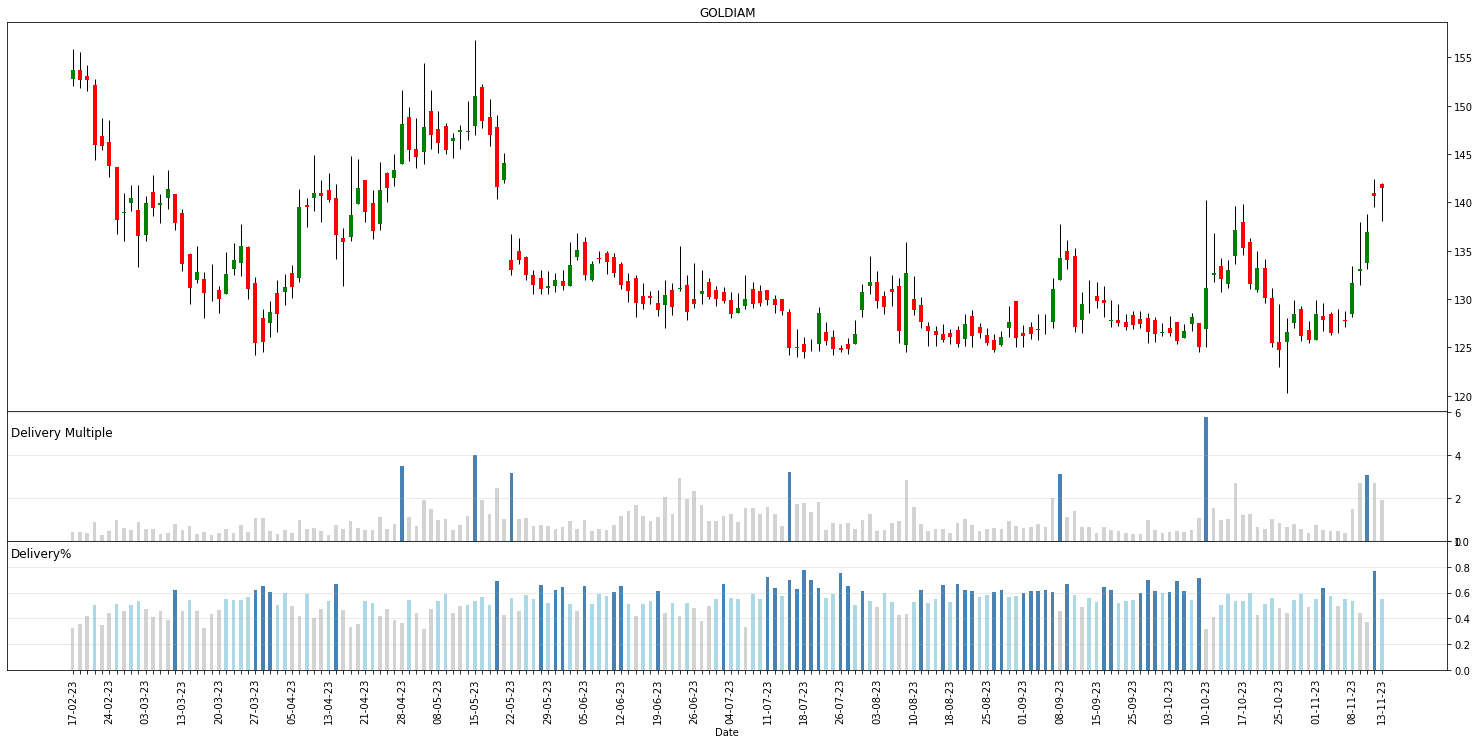

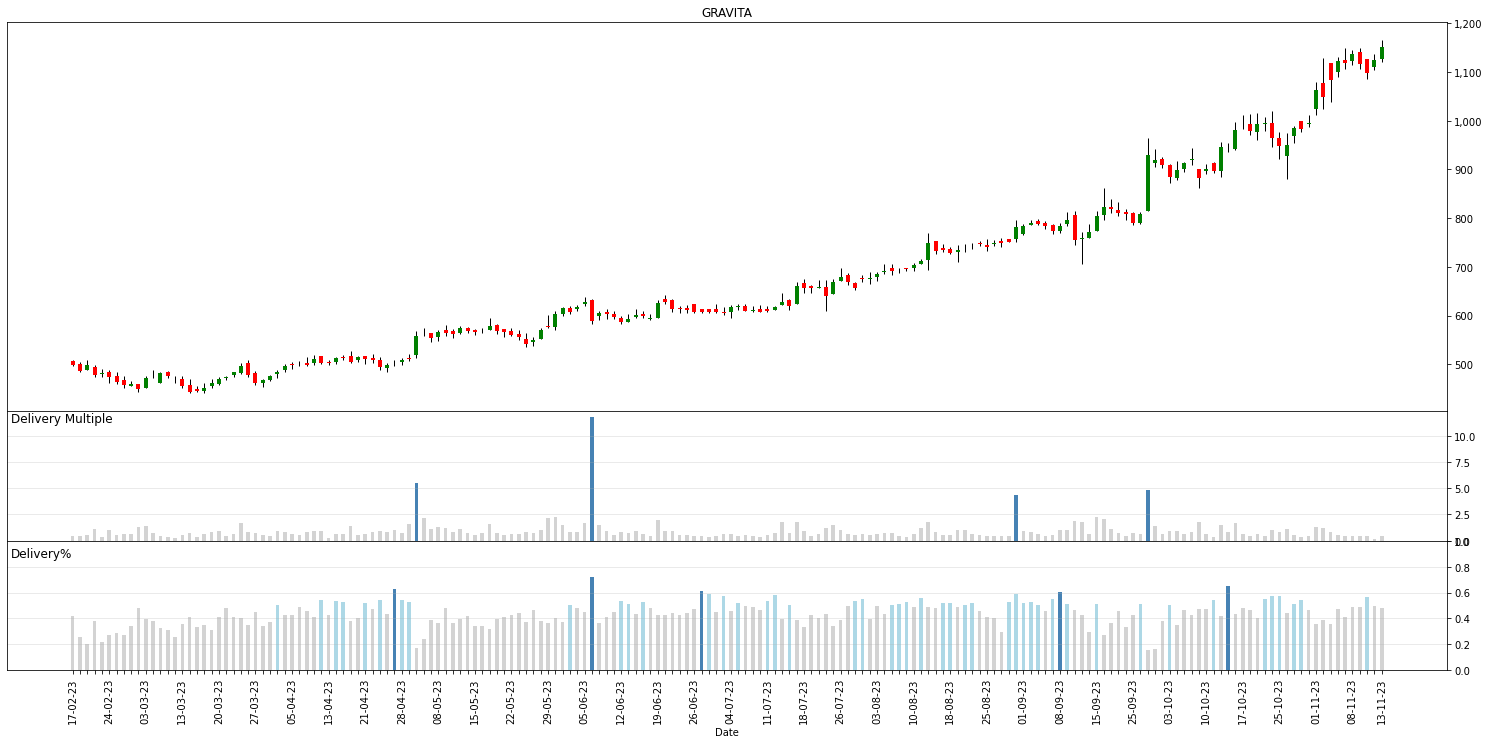

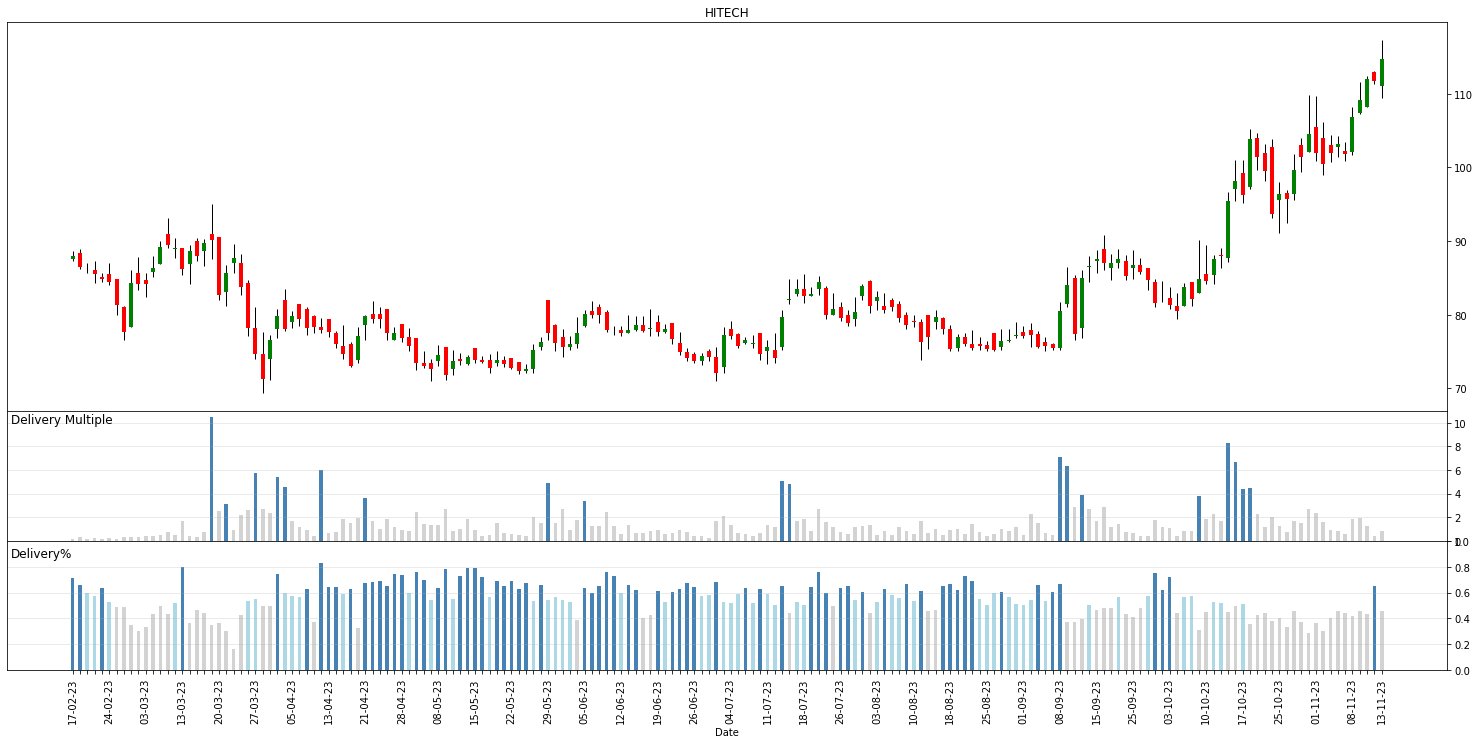

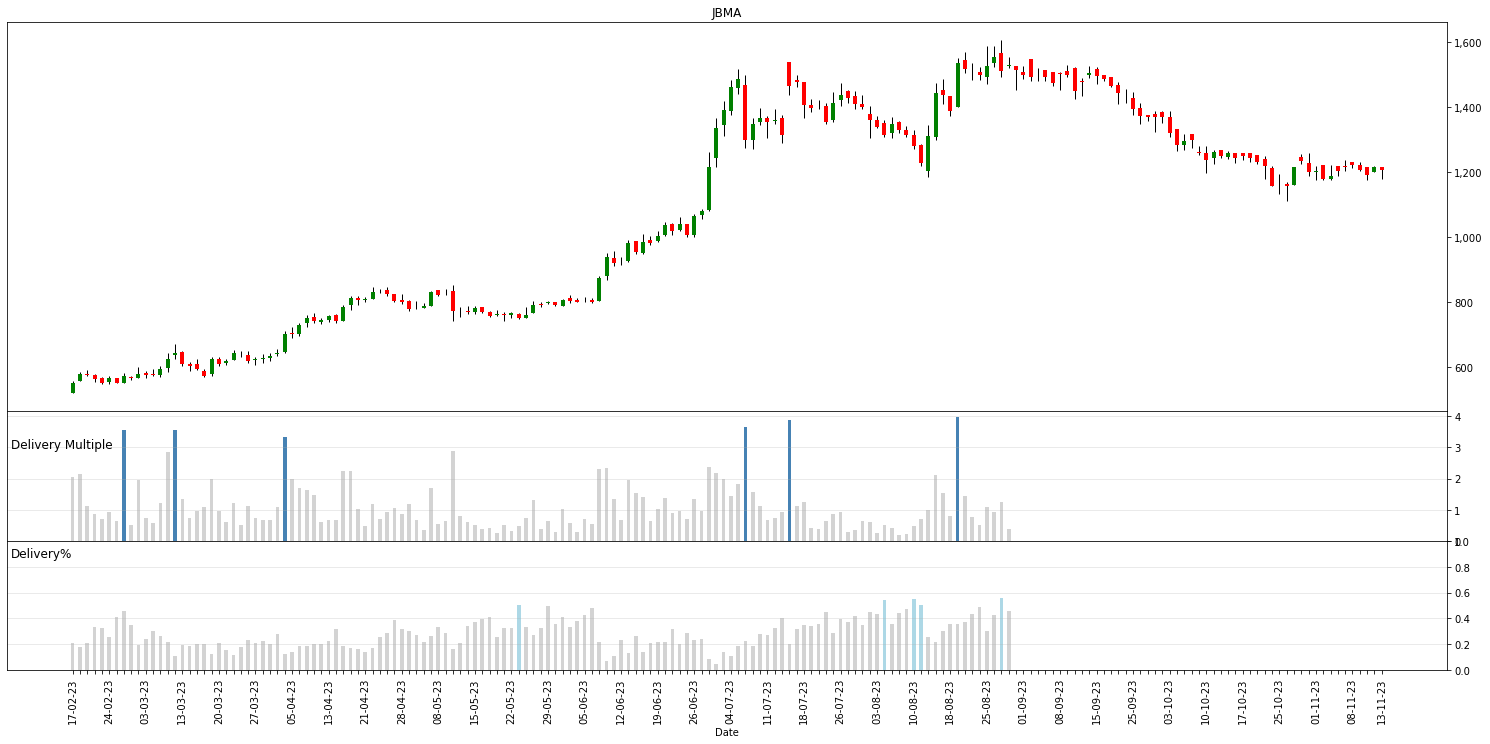

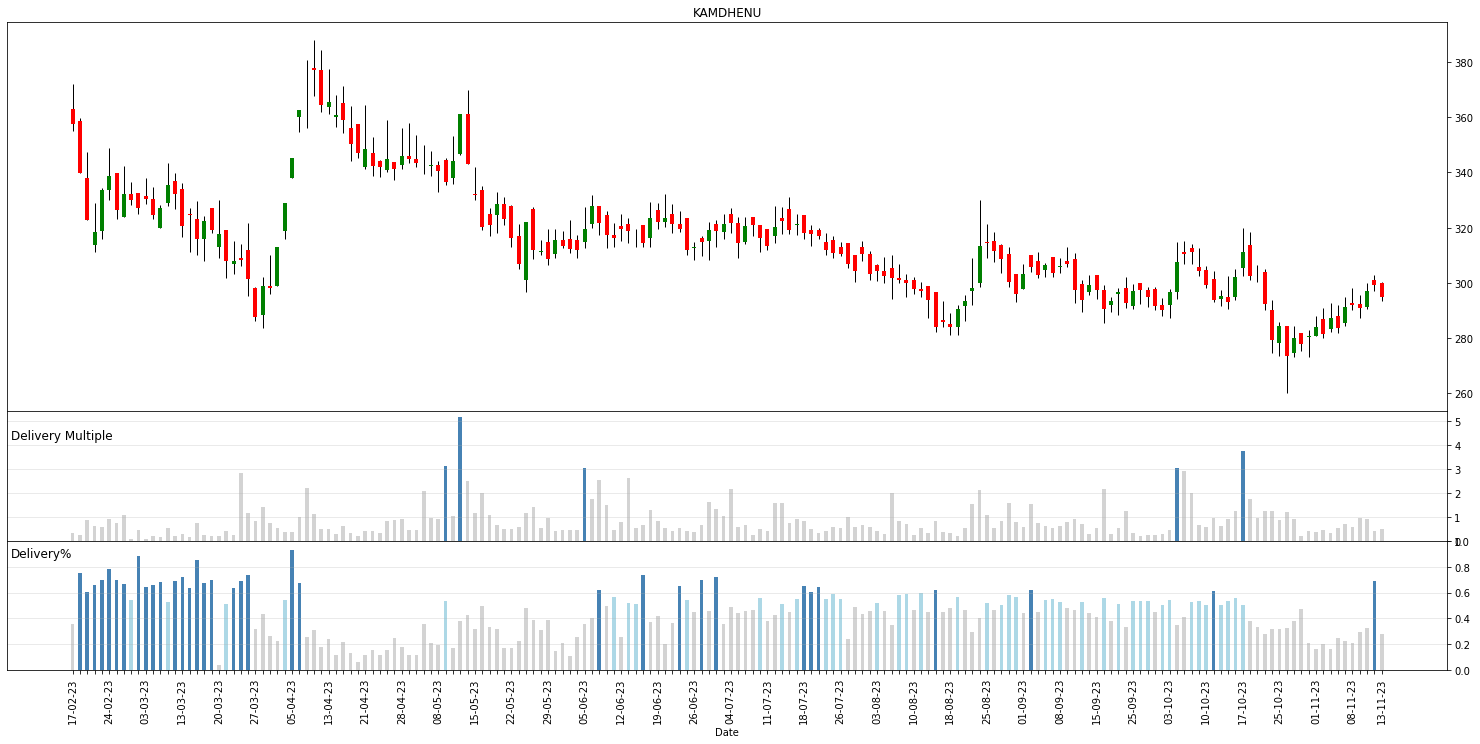

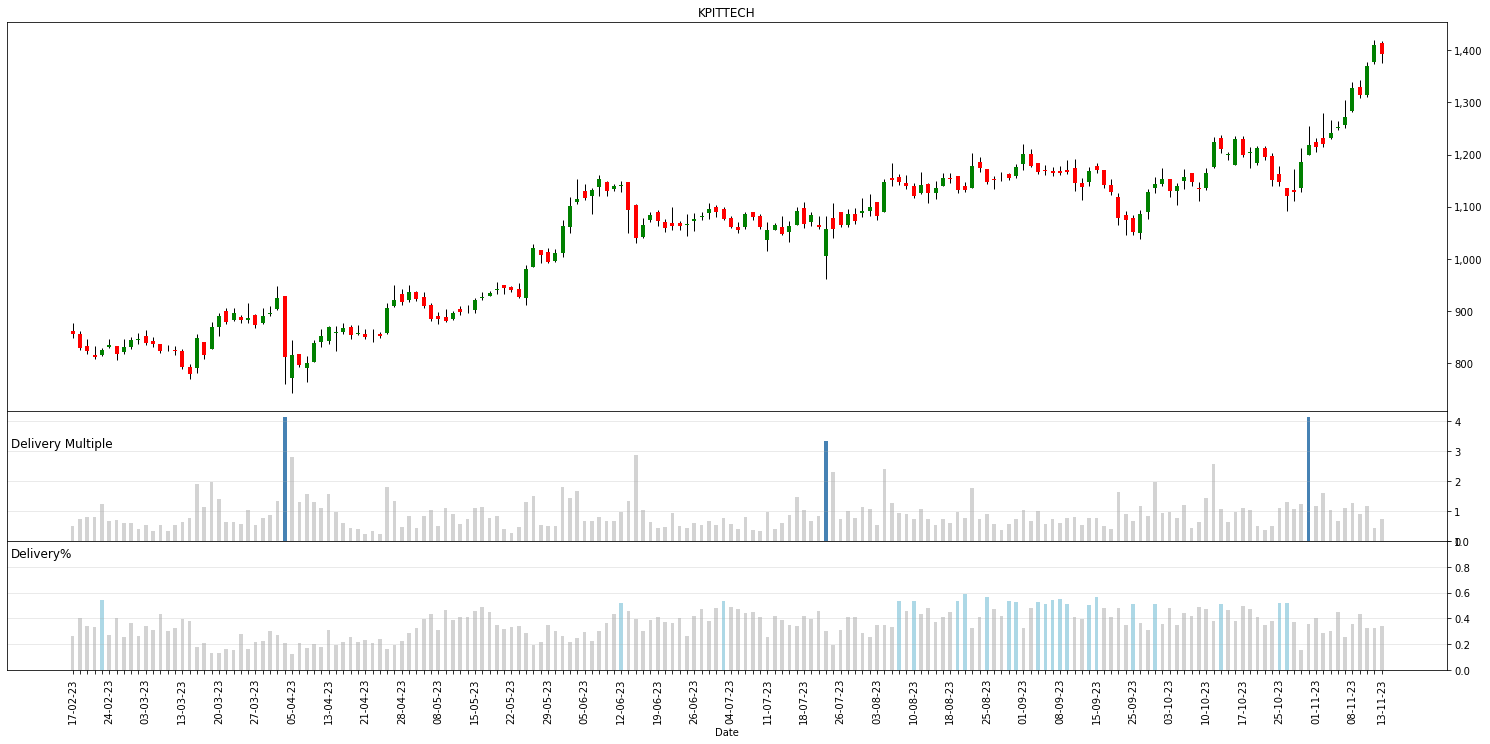

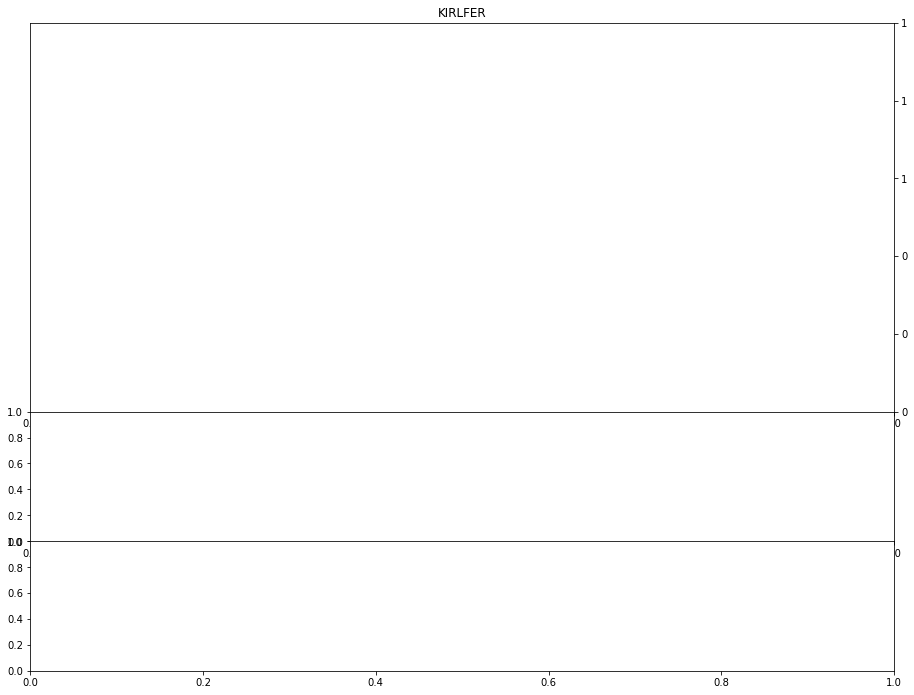

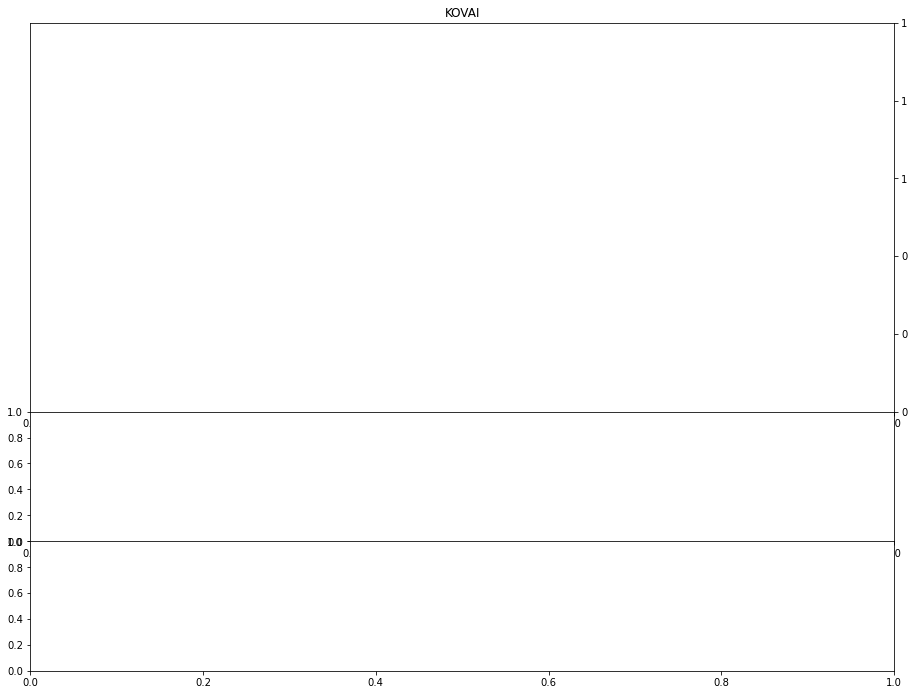

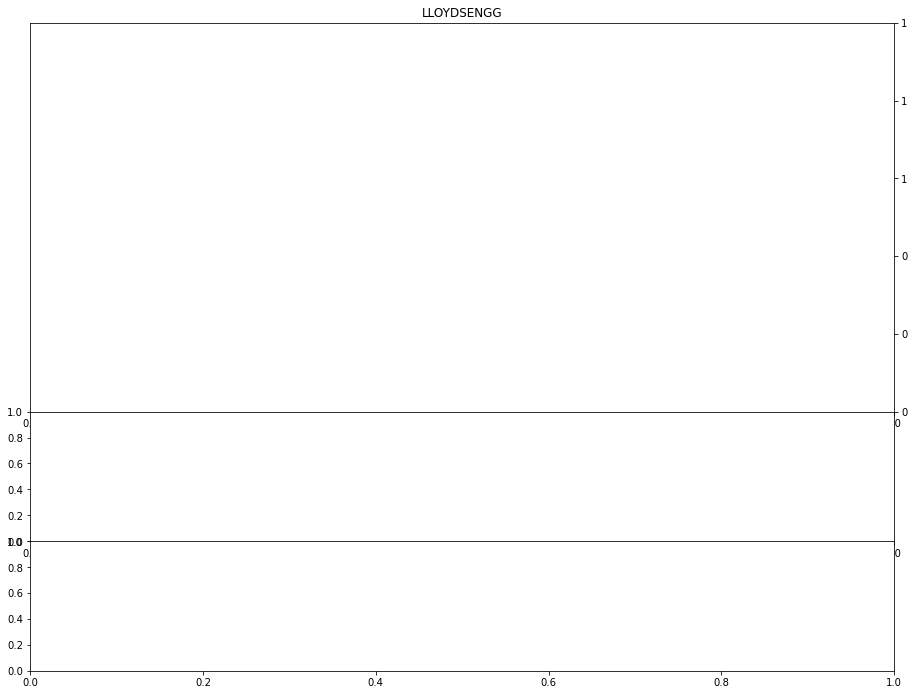

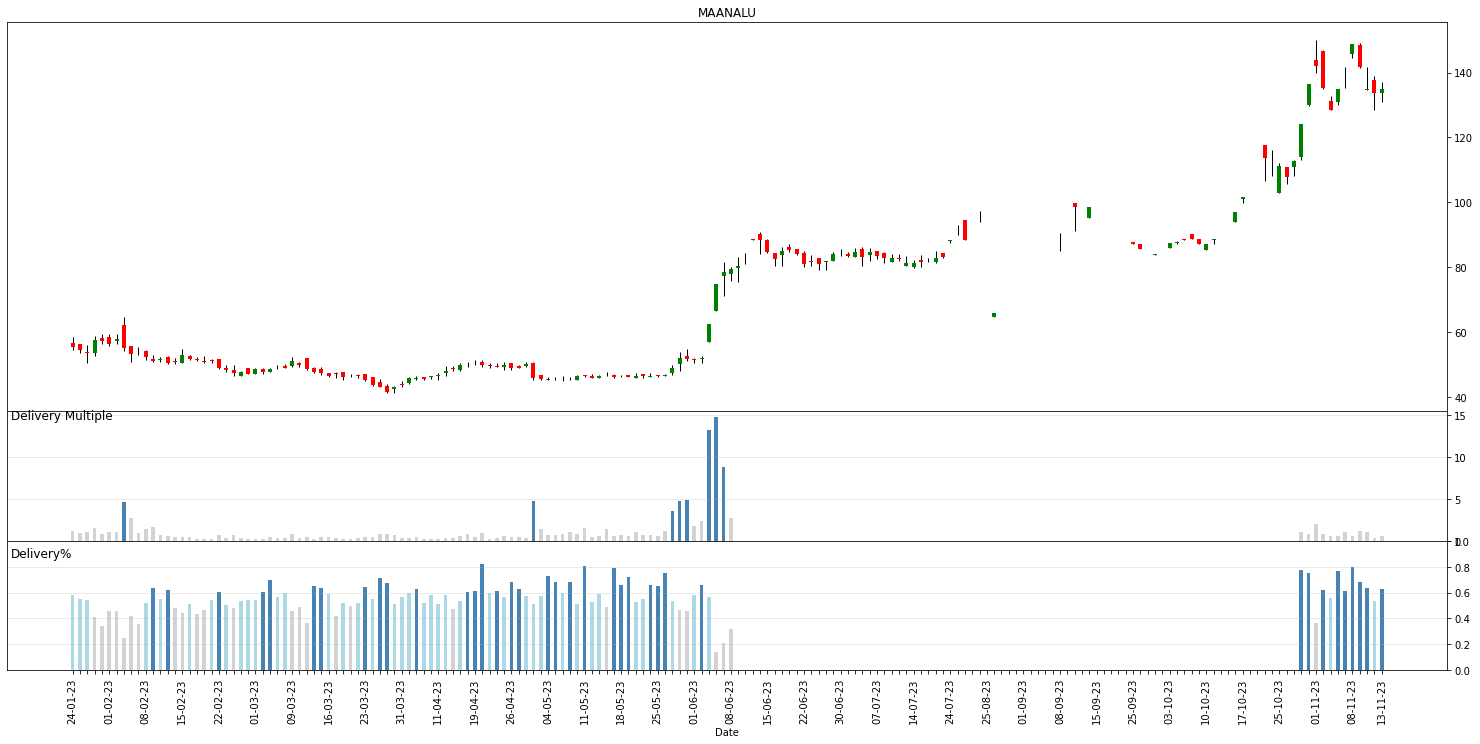

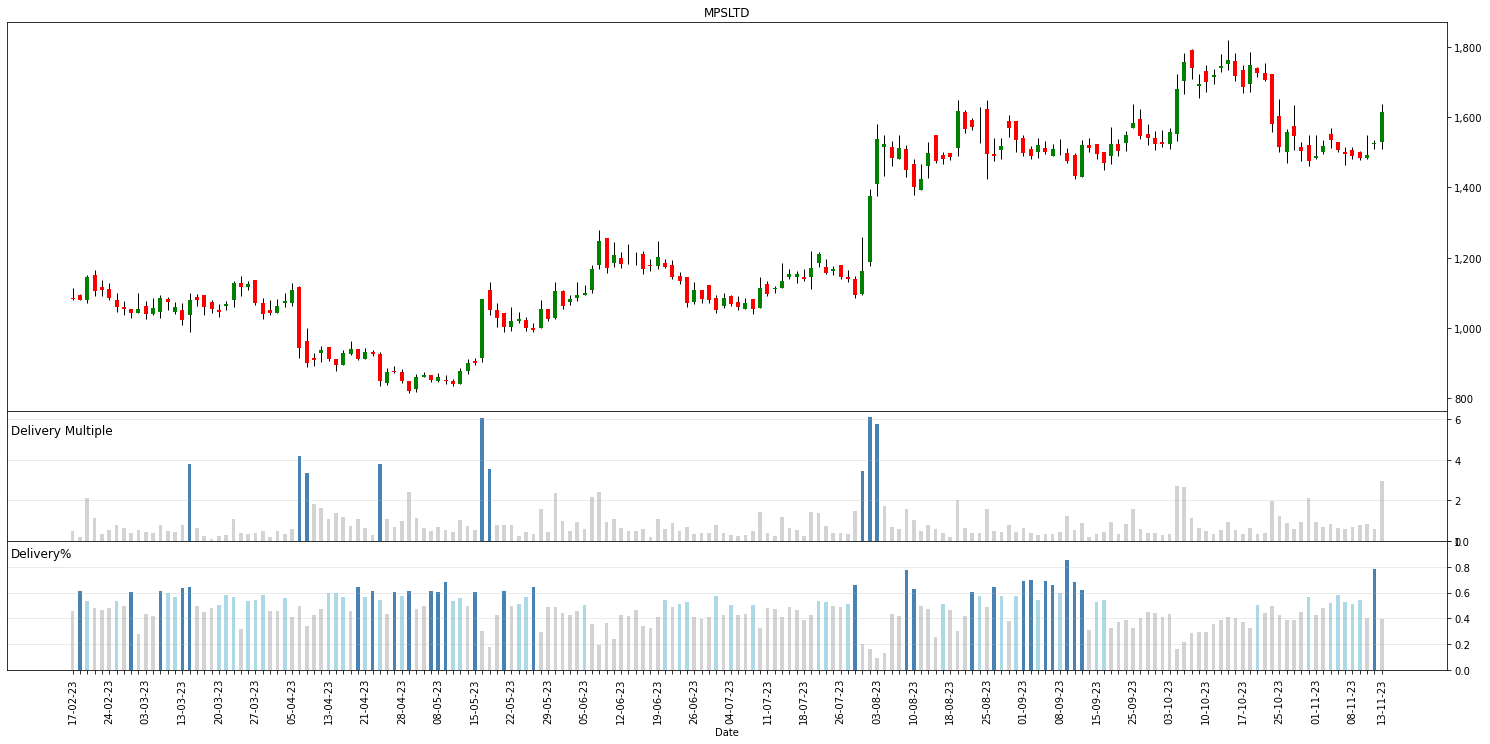

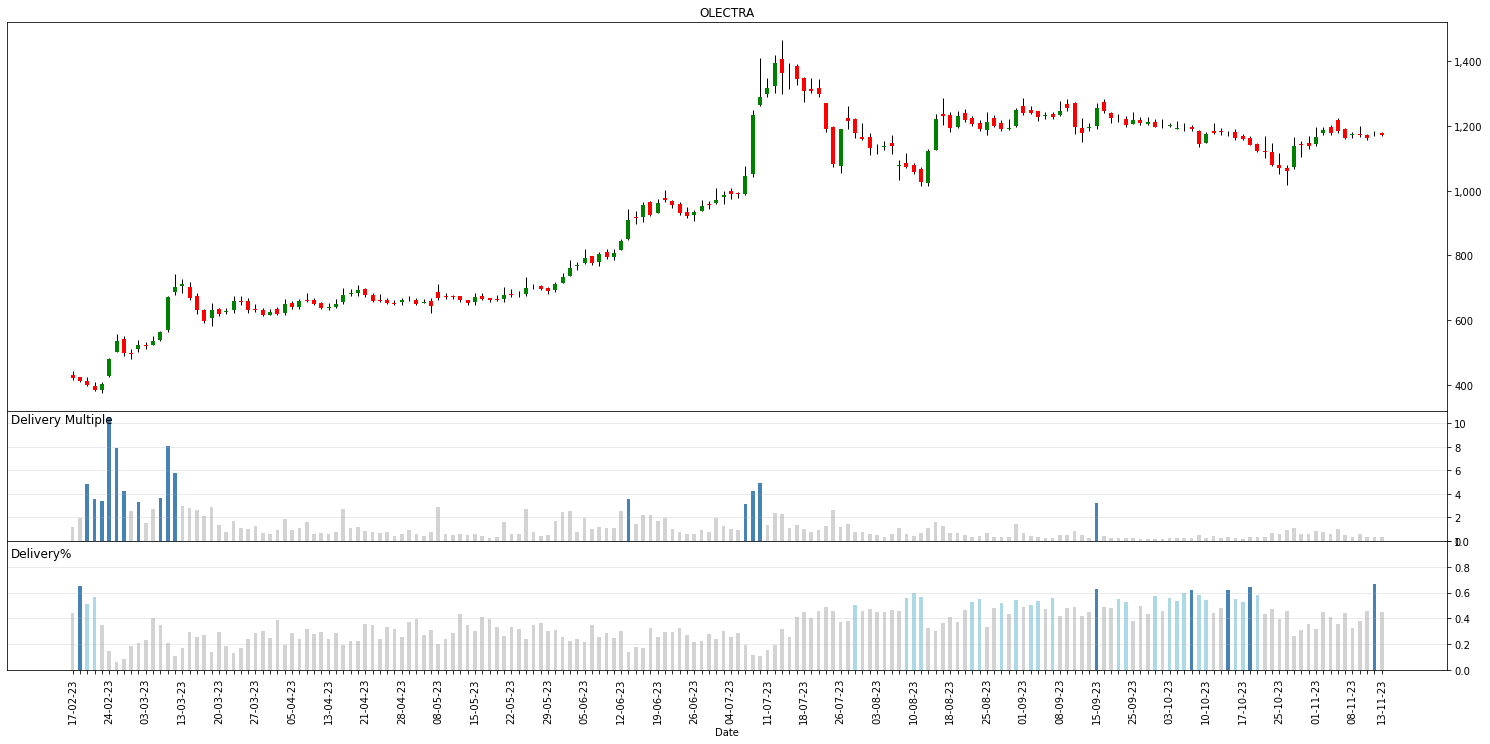

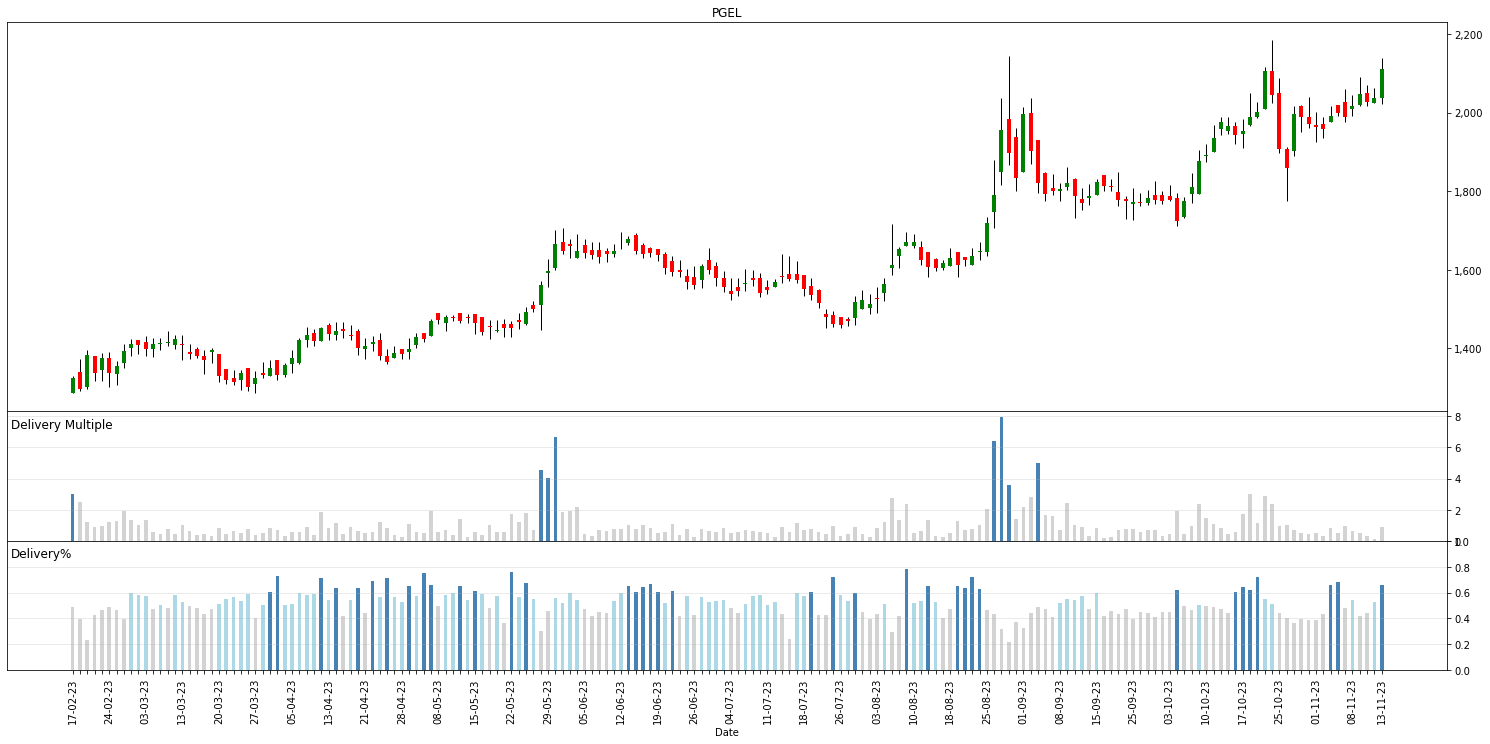

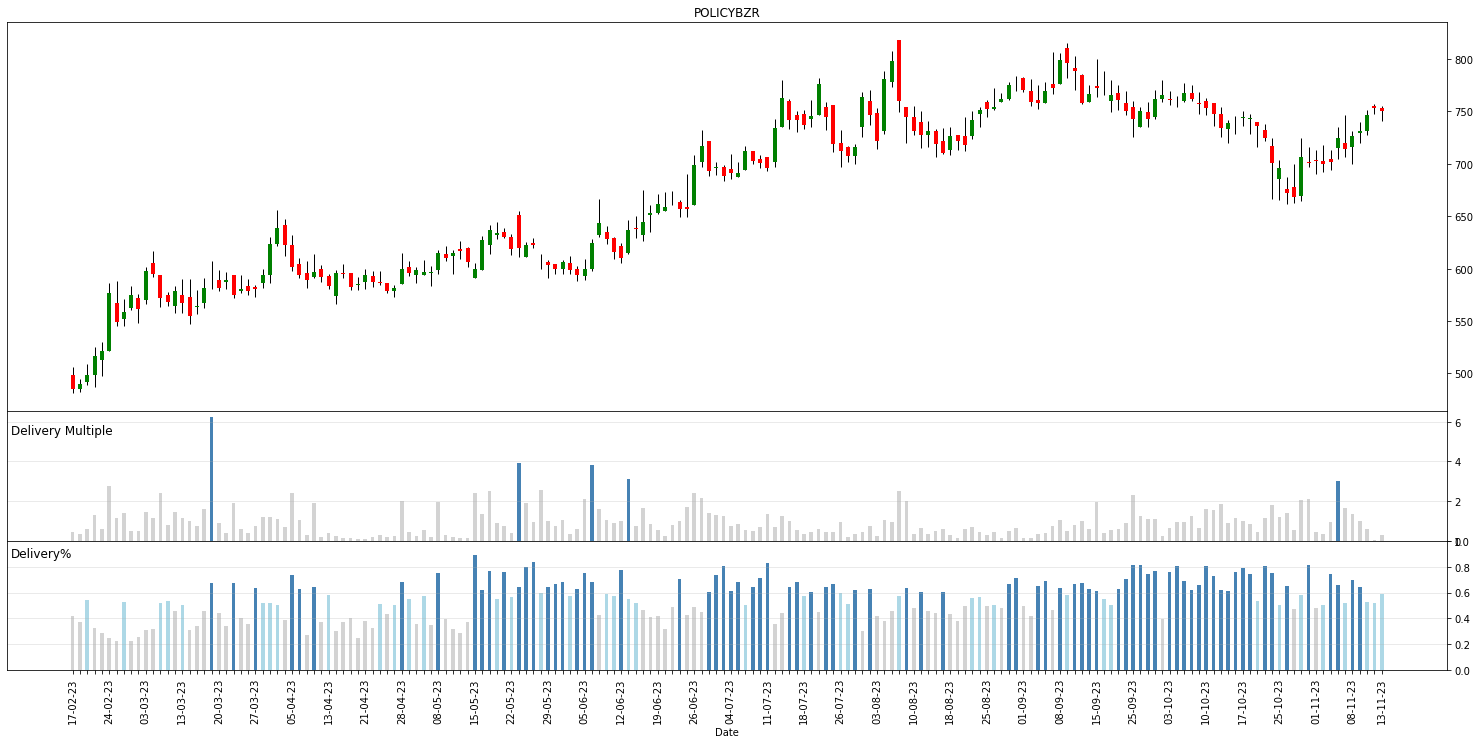

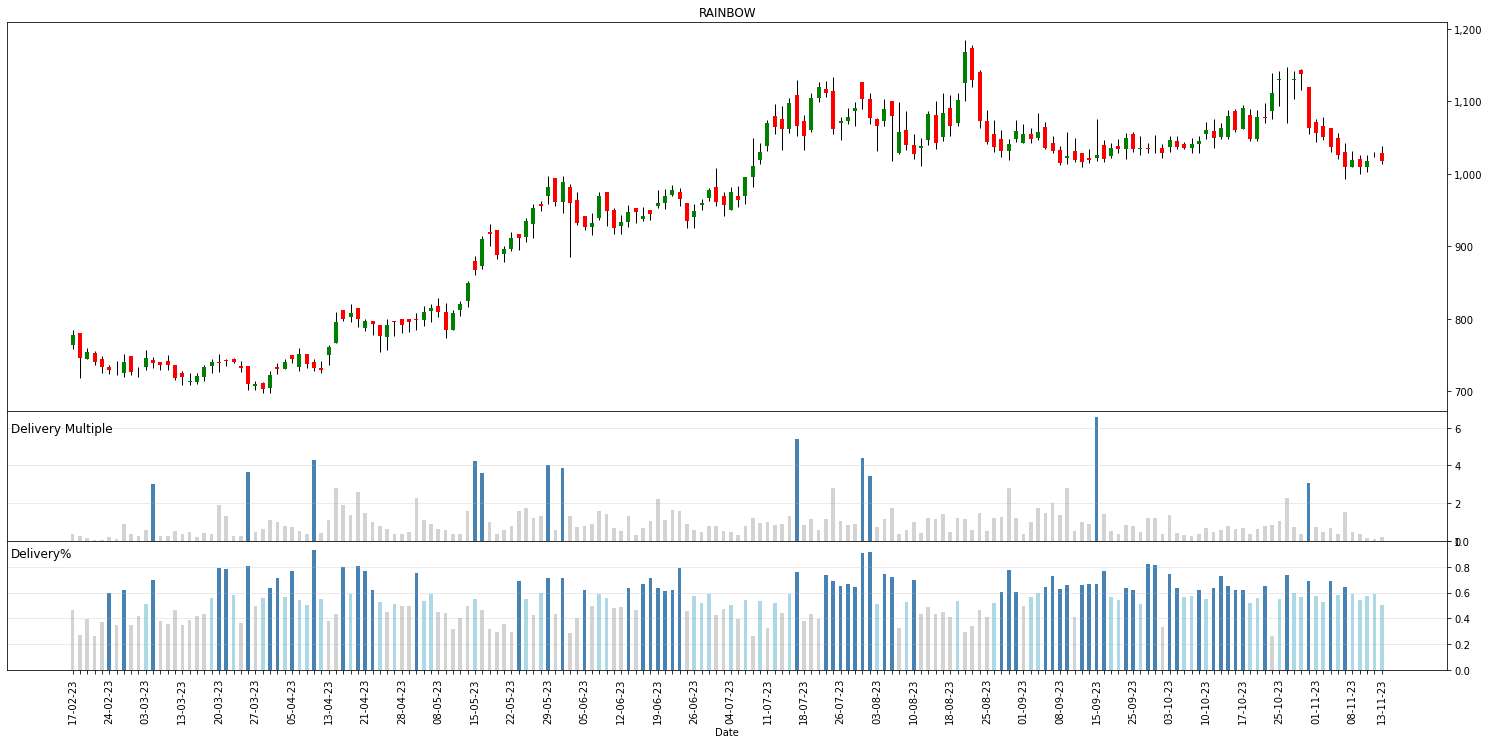

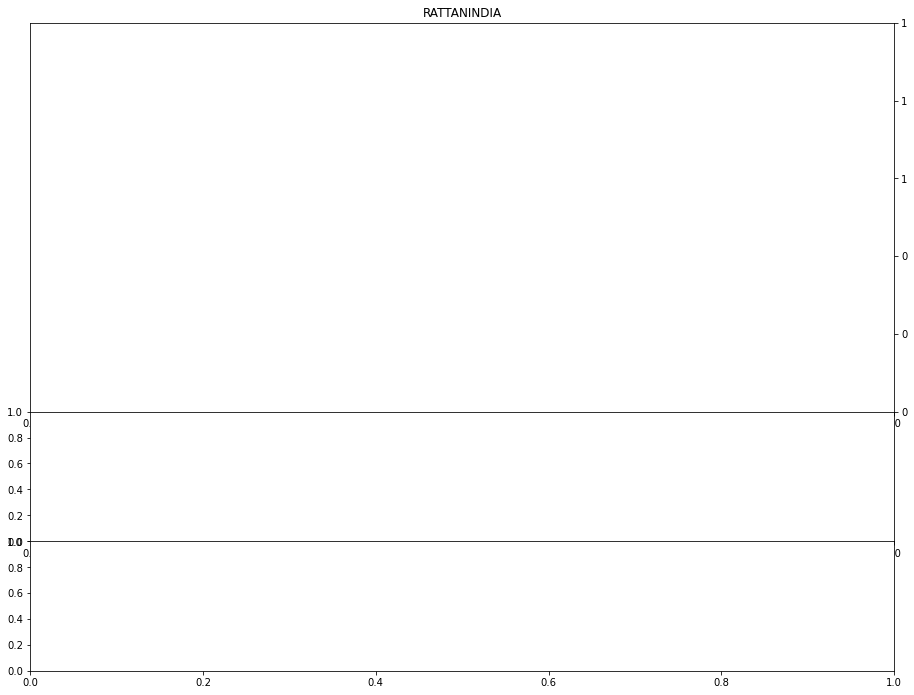

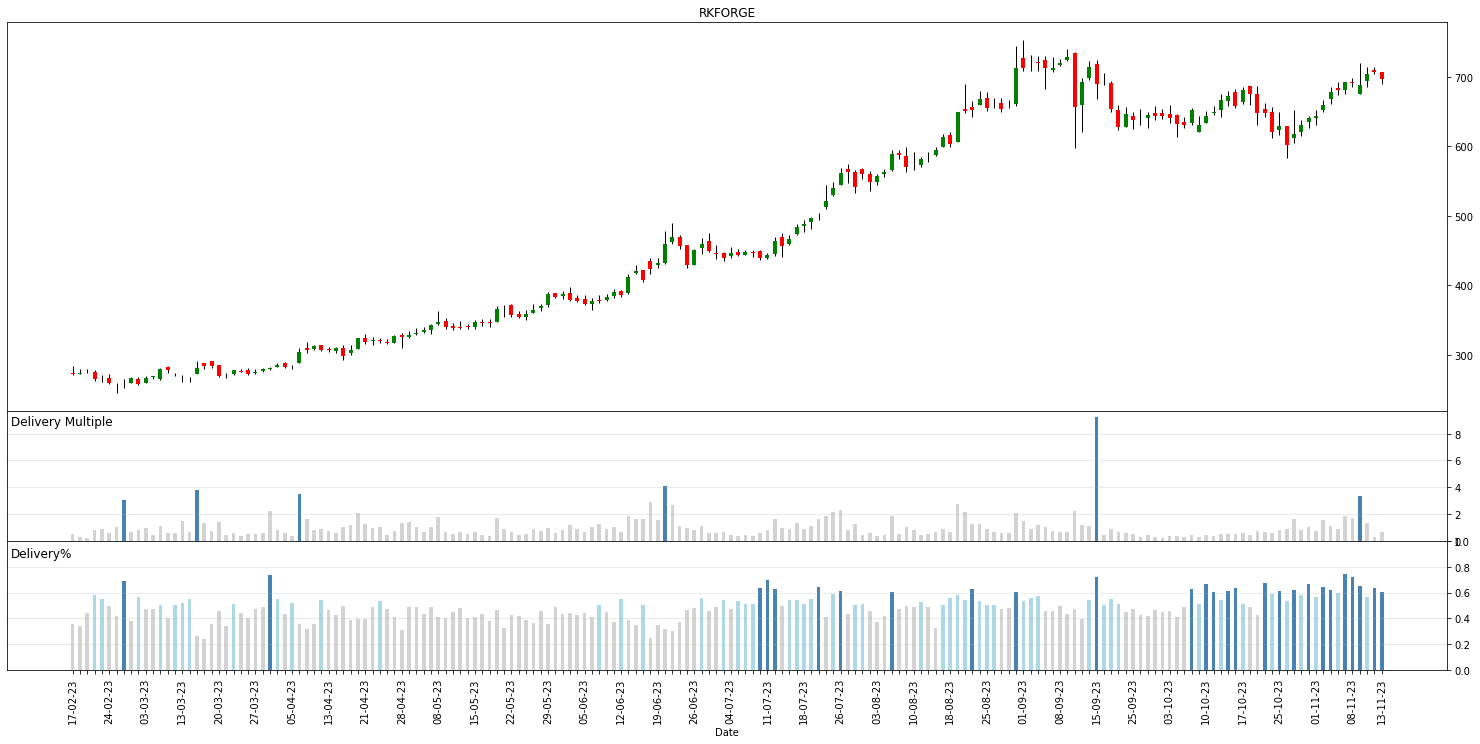

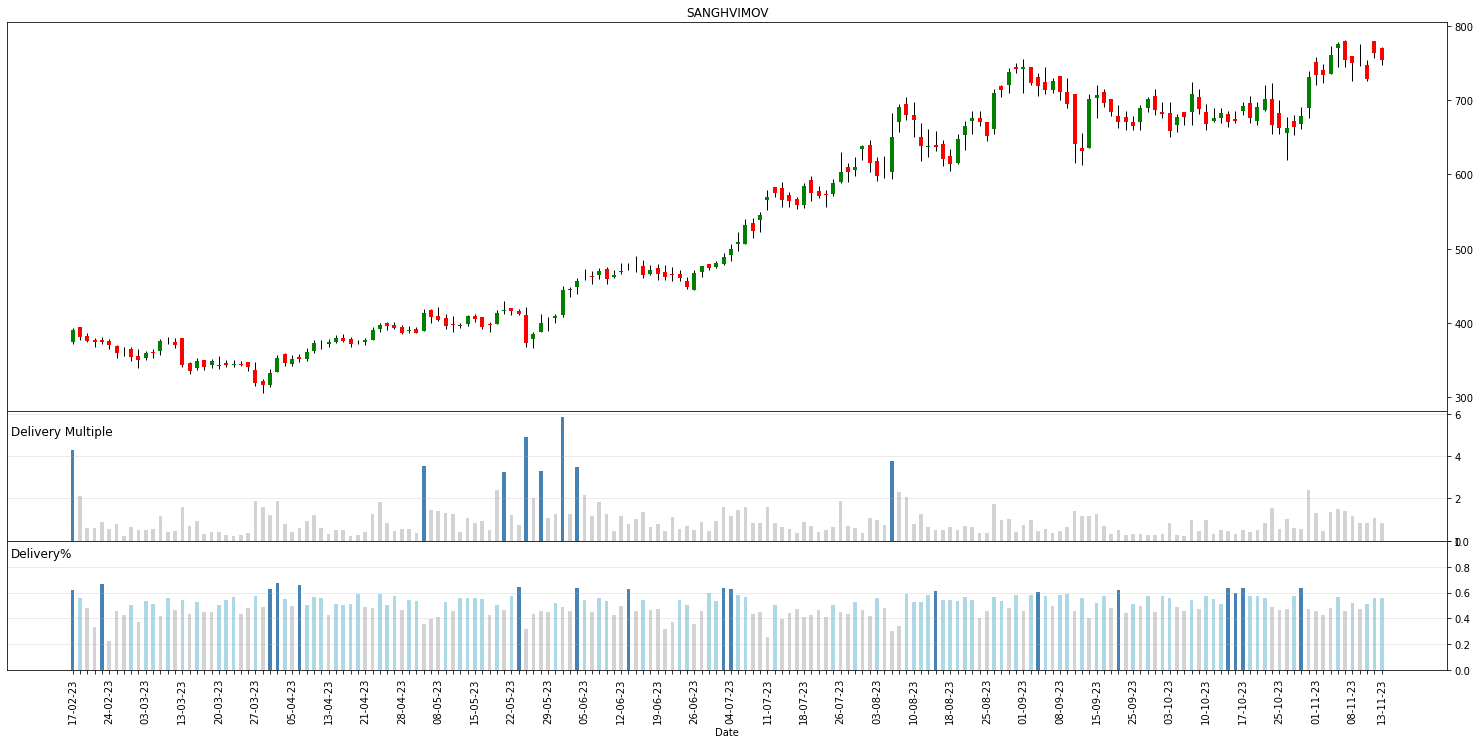

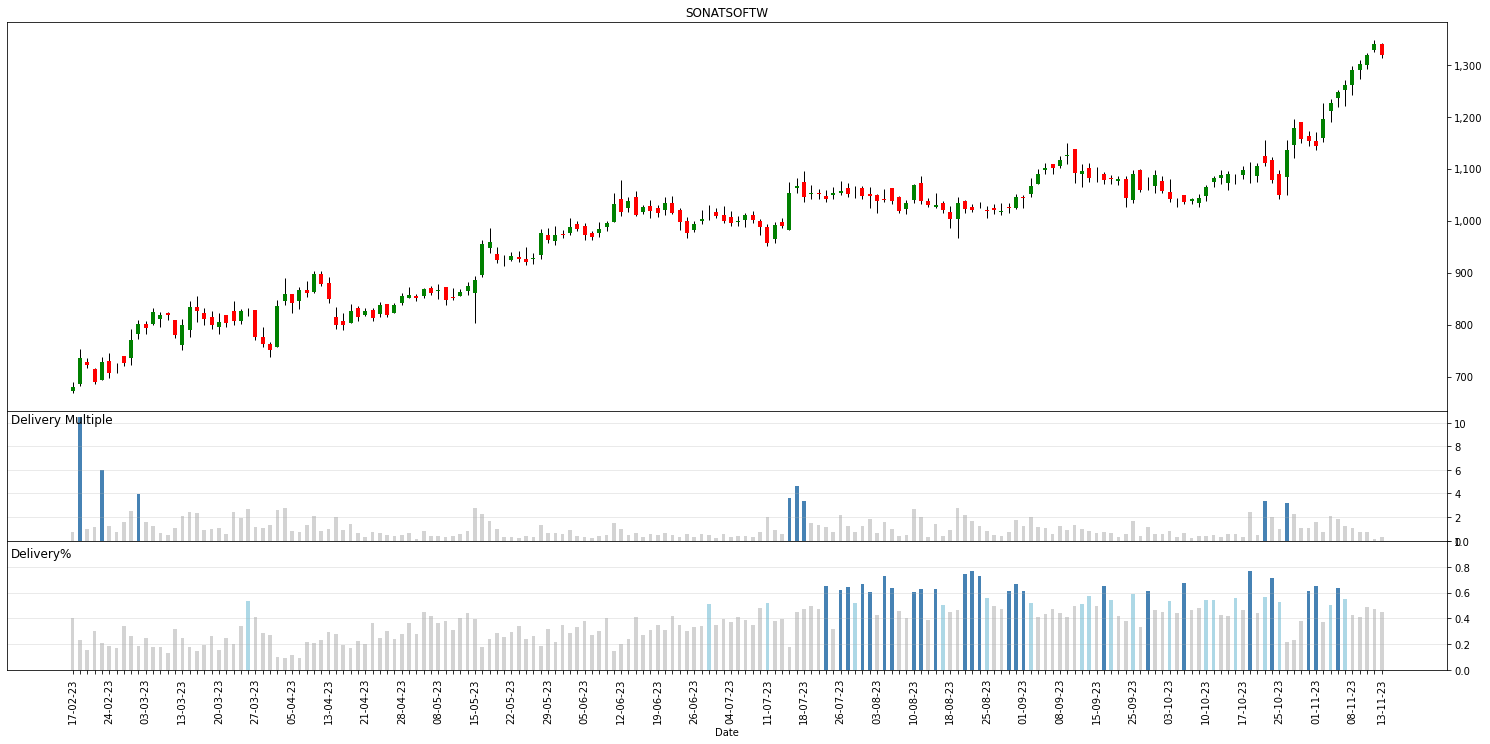

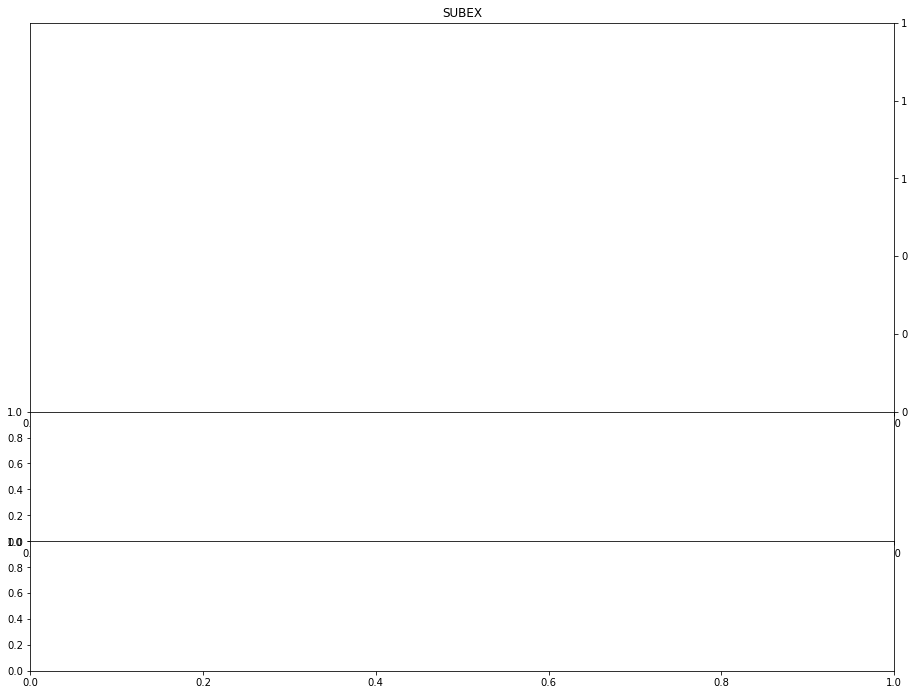

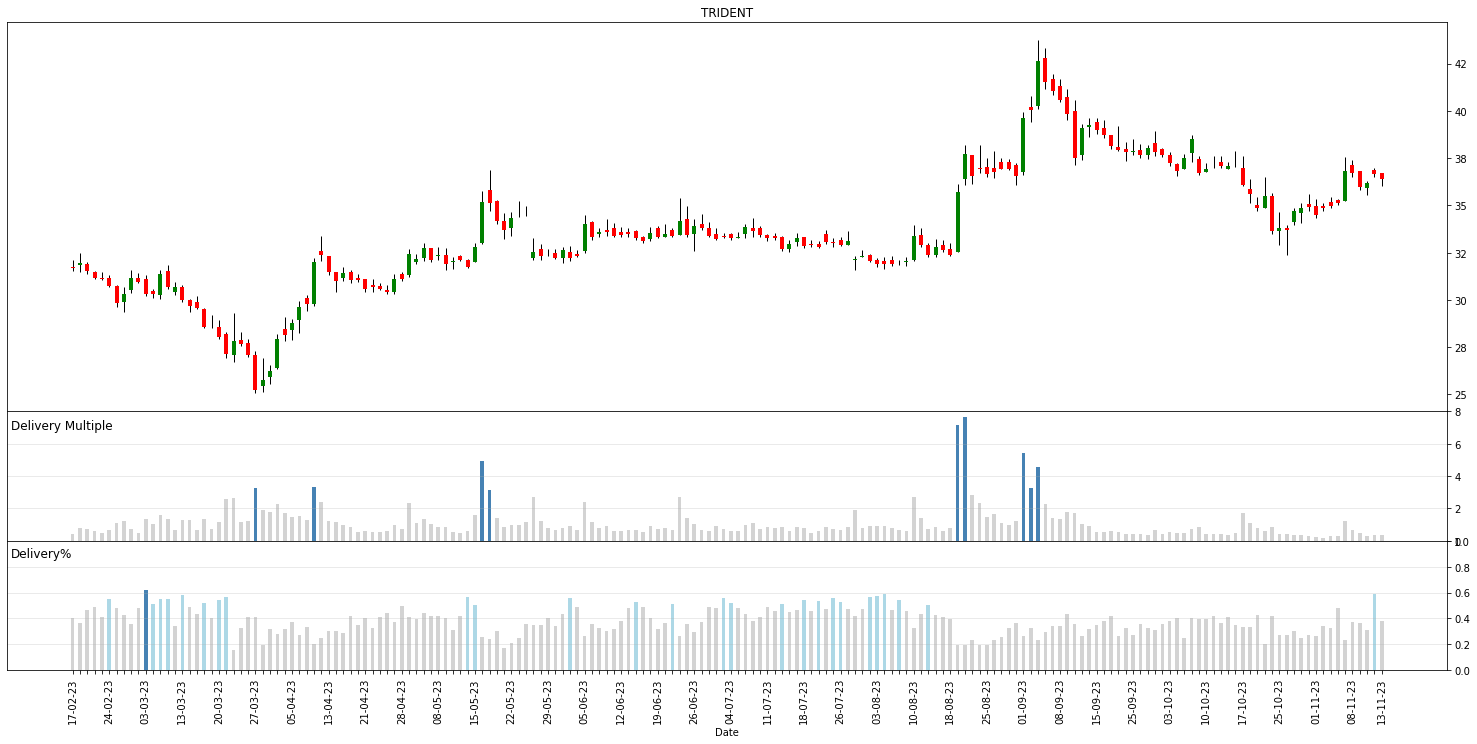

In [54]:
portfolio = ['AIAENG', 'BEL', 'CERA', 'GOLDIAM', 'GRAVITA', 'HITECH', 
             'JBMA', 'KAMDHENU', 'KPITTECH', 'KIRLFER', 'KOVAI', 'LLOYDSENGG', 
             'MAANALU', 'MPSLTD', 'OLECTRA', 'PGEL', 'POLICYBZR', 'RAINBOW', 
             'RATTANINDIA', 'RKFORGE', 'SANGHVIMOV', 'SONATSOFTW', 'SUBEX', 
             'TRIDENT']

hax = chart(portfolio, data)

#### Gainers on High Delivery

In [ ]:
# symblist1 = ['LOYALTEX', 'SADBHIN', 'PUNJABCHEM', 'GROBTEA', 
#              'THANGAMAYL', 'STEELXIND', 'IWEL', 'JAYNECOIND']
# symblist2 = high_del_high_pchange_df['Symbol'].tolist()
# symblist = [*set(symblist1 + symblist2)]

# for ticker in symblist2:
#     try:
#         ax = plot_ticker(data, ticker, 180, candle_width = 4)
#     except TypeError:
#         continue
#     plt.gcf().set_figwidth(20)
#     plt.show()

#### Banks

In [ ]:
tv_watchlist_path = r"C:\Users\Kushagra Saxena\Documents\Stock Investments\Trading View Watchlists"
banks = pd.read_excel(tv_watchlist_path + "\\banks.xlsx")

ax = chart(banks['Symbol'], data)

# for ticker in banks['Symbol']:
#     try:
#         ax = plot_ticker(data, ticker, 180, candle_width = 4)
#     except TypeError:
#         continue
#     except IndexError:
#         continue
#     plt.gcf().set_figwidth(20)
#     plt.show()

#### New Found Interest

In [ ]:
# for ticker in new_found_interest:
#     ax = plot_ticker(data, ticker, 180, candle_width = 4)
#     plt.gcf().set_figwidth(20)
#     plt.show()

#### Long Term Monthly Reversals

In [ ]:
symbols = ['ACCELYA','ENGINERSIN','COFORGE','SOTL','CONTROLPR',
           'CCL','DABUR','APLAPOLLO','PERSISTENT','IGL','MGL',
           'TCIEXP','ITC','SONATSOFTW','AMARAJABAT','GODREJCP',
           'PRECWIRE','RITES','TCS','HCLTECH','GSPL','SWARAJENG',
           'SKFINDIA','CUMMINSIND','HEROMOTOCO','MPSLTD','BEL',
           'GRINDWELL','BRITANNIA','KRBL','KEI','REDINGTON',
           'TRITURBINE','FINCABLES','ECLERX','AKZOINDIA',
           'MAITHANALL']

#for ticker in symbols:
#    try:
#        ax = plot_ticker(data, ticker, 180, candle_width = 4)
#    except TypeError:
#        continue
#    plt.gcf().set_figwidth(20)
#    plt.show()

#### Cyan Watchlist

In [ ]:
tv_watchlist_path = r"C:\Users\Kushagra Saxena\Documents\Stock Investments\Trading View Watchlists"
cyan_list = pd.read_excel(tv_watchlist_path + "\\cyan_list.xlsx")

ax = chart(cyan_list['Symbol'], data)

# for ticker in cyan_list['Symbol']:
#     try:
#         ax = plot_ticker(data, ticker, 180, candle_width = 4)
#     except TypeError:
#         continue
#     except IndexError:
#         continue
#     plt.gcf().set_figwidth(20)
#     plt.show()

#### High delivery multiple but low price change

In [ ]:
#for ticker in output_df['Symbol']:
#    ax = plot_ticker(data, ticker, 180, candle_width = 4)
#    plt.gcf().set_figwidth(20)
#    plt.show()
#    time.sleep(1)

#### Very high delivery multiple in last 10 days

In [ ]:
# for ticker in monster_del_df['Symbol'].unique():
#     ax = plot_ticker(data, ticker, 180, candle_width = 4)
#     plt.gcf().set_figwidth(20)
#     plt.show()
    #time.sleep(1)

In [ ]:
#Stocks with positive price change between 19-12-2022 and 23-12-2022
#tickers = get_tickers('2022-12-21', '2022-12-23', -0.05)
#len(tickers)
#for ticker in tickers:
#    ax = plot_ticker(data, ticker, 180, candle_width = 4)
#    plt.gcf().set_figwidth(20)
#    plt.show()
#    time.sleep(1)